# Exploring The Validity of FIFA Ratings

Due to the global pandemic, we found ourselves spending a lot more time at home. One of our favorite pastimes was the very popular soccer video game, FIFA. After playing hours of this game, we started to question some of the ratings of these players after seeing them perform very differently in real-life. We decided to investigate how FIFA comes up with their player ratings and see if we can predict these ratings.

# Data Acquisition and Cleaning

We have two main sources of data: 

1) Kaggle datasets with FIFA videogame ratings for players from 2015 to 2020.

2) Data scraped from [fbref.com](https://fbref.com/en/) with player statistics across the same years.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Getting the data from Kaggle was relatively easy, because we could just download .csv files. Here, we are reading the yearly statistics into separate dataframes.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

kaggle_2015_df = pd.read_csv("drive/MyDrive/CIS 545 Project/FIFA Data 2015 - 2020/players_15.csv")
kaggle_2016_df = pd.read_csv("drive/MyDrive/CIS 545 Project/FIFA Data 2015 - 2020/players_16.csv")
kaggle_2017_df = pd.read_csv("drive/MyDrive/CIS 545 Project/FIFA Data 2015 - 2020/players_17.csv")
kaggle_2018_df = pd.read_csv("drive/MyDrive/CIS 545 Project/FIFA Data 2015 - 2020/players_18.csv")
kaggle_2019_df = pd.read_csv("drive/MyDrive/CIS 545 Project/FIFA Data 2015 - 2020/players_19.csv")
kaggle_2020_df = pd.read_csv("drive/MyDrive/CIS 545 Project/FIFA Data 2015 - 2020/players_20.csv")


Now, let's concatenate the dataframes into one dataframe called `kaggle_df` with data from all of the years. Before doing so, we'll add a column called `Season` in order to preserve the year that the data is from.


In [ ]:
kaggle_2015_df["Season"] = "2015"
kaggle_2016_df["Season"] = "2016"
kaggle_2017_df["Season"] = "2017"
kaggle_2018_df["Season"] = "2018"
kaggle_2019_df["Season"] = "2019"
kaggle_2020_df["Season"] = "2020"
kaggle_df = pd.concat([kaggle_2015_df, kaggle_2016_df, kaggle_2017_df, kaggle_2018_df, kaggle_2019_df, kaggle_2020_df], axis=0)

After looking through the dataset, we decided that some initial cleaning was neccessary. First, we want to remove all punctuation from the club team name, as this may cause complications when trying to match the team name with the team name from the other dataset. We also want to remove all diacritical marks from the player name and the club name.

In [ ]:
kaggle_df["club"] = kaggle_df["club"].str.replace('[^\w\s]','')
kaggle_df["club"] = kaggle_df["club"].str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8')
kaggle_df["short_name"] = kaggle_df["short_name"].str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8')
kaggle_df["long_name"] = kaggle_df["long_name"].str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8')
kaggle_df

,sofifa_id,player_url,short_name,long_name,age,dob,height_cm,weight_kg,nationality,club,overall,potential,value_eur,wage_eur,player_positions,preferred_foot,international_reputation,weak_foot,skill_moves,work_rate,body_type,real_face,release_clause_eur,player_tags,team_position,team_jersey_number,loaned_from,joined,contract_valid_until,nation_position,nation_jersey_number,pace,shooting,passing,dribbling,defending,physic,gk_diving,gk_handling,gk_kicking,...,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_marking,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes,ls,st,rs,lw,lf,cf,rf,rw,lam,cam,ram,lm,lcm,cm,rcm,rm,lwb,ldm,cdm,rdm,rwb,lb,lcb,cb,rcb,rb,Season
0,158023,https://sofifa.com/player/158023/lionel-messi/...,L. Messi,Lionel Andres Messi Cuccittini,27,1987-06-24,169,67,Argentina,FC Barcelona,93,95,0,0,CF,Left,5,3,4,Medium/Low,Normal,Yes,NaN,"#Speedster, #Dribbler, #FK Specialist, #Acroba...",CF,10.0,NaN,2004-07-01,2018.0,CF,10.0,93.0,89.0,86.0,96.0,27.0,63.0,NaN,NaN,NaN,...,22,92-1,90,76,NaN,25,21,20,6,11,15,14,8,89+3,89+3,89+3,92+3,90+3,90+3,90+3,92+3,92+3,92+3,92+3,90+3,79+3,79+3,79+3,90+3,62+3,62+3,62+3,62+3,62+3,54+3,45+3,45+3,45+3,54+3,2015
1,20801,https://sofifa.com/player/20801/c-ronaldo-dos-...,Cristiano Ronaldo,Cristiano Ronaldo dos Santos Aveiro,29,1985-02-05,185,80,Portugal,Real Madrid,92,92,0,0,"LW, LM",Right,5,4,5,High/Low,Normal,Yes,NaN,"#Speedster, #Dribbler, #Distance Shooter, #Acr...",LW,7.0,NaN,2009-07-01,2018.0,LW,7.0,93.0,93.0,81.0,91.0,32.0,79.0,NaN,NaN,NaN,...,24,91+2,81,85,NaN,22,31,23,7,11,15,14,11,91+3,91+3,91+3,89+3,91+3,91+3,91+3,89+3,89+3,89+3,89+3,87+3,77+3,77+3,77+3,87+3,63+3,63+3,63+3,63+3,63+3,57+3,52+3,52+3,52+3,57+3,2015
2,9014,https://sofifa.com/player/9014/arjen-robben/15...,A. Robben,Arjen Robben,30,1984-01-23,180,80,Netherlands,FC Bayern Munchen,90,90,0,0,"RM, LM, RW",Left,5,2,4,High/Low,Normal,Yes,NaN,"#Speedster, #Dribbler, #Distance Shooter, #Acr...",SUB,10.0,NaN,2009-08-28,2017.0,RS,11.0,93.0,86.0,83.0,92.0,32.0,64.0,NaN,NaN,NaN,...,39+1,89+2,84+2,80+1,NaN,29,26+2,26+1,10,8,11,5,15,84+3,84+3,84+3,88+3,87+3,87+3,87+3,88+3,88+3,88+3,88+3,87+3,78+3,78+3,78+3,87+3,64+3,64+3,64+3,64+3,64+3,55+3,46+3,46+3,46+3,55+3,2015
3,41236,https://sofifa.com/player/41236/zlatan-ibrahim...,Z. Ibrahimovic,Zlatan Ibrahimovic,32,1981-10-03,195,95,Sweden,Paris SaintGermain,90,90,0,0,ST,Right,5,4,4,Medium/Low,Normal,Yes,NaN,"#Poacher, #Aerial Threat, #Distance Shooter, #...",ST,10.0,NaN,2012-07-01,2016.0,ST,10.0,76.0,91.0,81.0,86.0,34.0,86.0,NaN,NaN,NaN,...,20,86,83-1,91,NaN,25,41-8,27,13,15,10,9,12,87+3,87+3,87+3,84+3,86+3,86+3,86+3,84+3,86+3,86+3,86+3,83+3,76+3,76+3,76+3,83+3,61+3,65+3,65+3,65+3,61+3,56+3,55+3,55+3,55+3,56+3,2015
4,167495,https://sofifa.com/player/167495/manuel-neuer/...,M. Neuer,Manuel Neuer,28,1986-03-27,193,92,Germany,FC Bayern Munchen,90,90,0,0,GK,Right,5,4,1,Medium/Medium,Normal,Yes,NaN,NaN,GK,1.0,NaN,2011-07-01,2019.0,GK,1.0,NaN,NaN,NaN,NaN,NaN,NaN,87.0,85.0,92.0,...,30+8,25,20,37,NaN,25,25,25,87,85+3,92,90+6,86,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18273,245006,https://sofifa.com/player/245006/shuai-shao/20...,Shao Shuai,,22,1997-03-10,186,79,China PR,Beijing Renhe FC,48,56,40000,2000,CB,Right,1,3,2,Medium/High,Normal,No,70000.0,NaN,RES,36.0,NaN,2018-07-13,2019.0,NaN,NaN,57.0,23.0,28.0,33.0,47.0,51.0,NaN,NaN,NaN,...,48,28,25,39,41,45,50,52,5,5,13,5,14,32+2,32+2,32+2,31+2,31+2,31+2,31+2,31+2,31+2,31+2,31+2,33+2,33+2,33+2,

The process of acquiring the season statistics for each player was much more involved. 

The website [fbref.com](https://fbref.com/en/) has detailed statistics for each professional soccer player. In order to acquire this data, we developed a web-scraping algorithm using Beautiful Soup that visited each player's page and scraped their statistics. On each player's page, there are various types of statistics that are available: standard stats, playing time, defense stats, passing stats, shooting stats, goalkeeping stats, and miscellaneous stats. 

In [ ]:
# Create dataframes for each type of statistic with the appropriate columns

standard_stats_columns = ['name', 'season', 'age', 'squad', 'country', 'competition', 'league_rank', 'matches_played', 'starts', 'minutes', 'goals', 'assists', 'pk', 'pk_attempted', 'yellow_cards', 'red_cards']
standard_stats_df = pd.DataFrame(columns=standard_stats_columns)

playing_time_columns = ['name', 'season', 'age', 'squad', 'country', 'competition', 'league_rank', 'matches_played', 'minutes', 'min/MP', 'min %', 'min/90', 'starts', 'min/start', 'complete_matches', 'subs', 'min/sub', 'unused_sub', 'team_ppm', 'team_goals', 'team_goals_allowed', 'team_plus-minus', 'team_plus-minus_90', 'team_plus-minus_net']
playing_time_df = pd.DataFrame(columns=playing_time_columns)

miscellaneous_stats_columns = ['name', 'season', 'age', 'squad', 'country', 'competition', 'league_rank', 'min/90', 'yellow_cards', 'red_cards', 'second_yellow_cards', 'fouls', 'fouls_drawn', 'offsides', 'crosses', 'interceptions', 'tackles_won', 'pk_won', 'pk_conceded', 'own_goals']
miscellaneous_stats_df = pd.DataFrame(columns=miscellaneous_stats_columns)

goalkeeping_stats_columns = ['name', 'season', 'age', 'squad', 'country', 'competition', 'league_rank', 'matches_played', 'starts', 'minutes', 'goals_allowed', 'goals_allowed_90', 'sot_against', 'saves', 'save %', 'wins', 'draws', 'losses', 'clean_sheets', 'clean_sheet_percentage', 'pk_attempted', 'pk_allowed', 'pk_saved', 'pk_missed']
goalkeeping_stats_df = pd.DataFrame(columns=goalkeeping_stats_columns)

shooting_stats_columns = ['name', 'season', 'age', 'squad', 'country', 'competition', 'league_rank', 'min/90', 'goals', 'shots', 'shots_on_target', 'sot%', 'shots/90', 'sot/90', 'goals/shot', 'avg_distance', 'free_kicks', 'pk_made', 'pk_att']
shooting_stats_df = pd.DataFrame(columns=shooting_stats_columns)

passing_stats_columns = ['name', 'season', 'age', 'squad', 'country', 'competition', 'league_rank', 'min/90', 'passes_completed', 'passes_attempted', 'comp%', 'total_distance', 'prog_distance', 'short_comp', 'short_att', 'short_comp%', 'medium_comp', 'medium_att', 'medium_comp%', 'long_comp', 'long_att', 'long_comp%']
passing_stats_df = pd.DataFrame(columns=passing_stats_columns)

defense_stats_columns = ['name', 'season', 'age', 'squad', 'country', 'competition', 'league_rank', 'min/90', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23']
defense_stats_df = pd.DataFrame(columns=defense_stats_columns)

In [ ]:
import requests
from bs4 import BeautifulSoup

URL = 'https://fbref.com/en/players/'
page = requests.get(URL)

soup = BeautifulSoup(page.content, 'html.parser')

letter_list = soup.find("ul", class_="page_index")
letter_items = letter_list.find_all("li", recursive=False)
for letter in letter_items:
  links = letter.find_all("a")
  letterName = letter.find("span").text
  print(letterName)

  for link in links:
    print(link['href'])
    letter_page = requests.get('https://fbref.com' + link['href'])
    letter_soup = BeautifulSoup(letter_page.content, 'html.parser')

    player_list = letter_soup.find("div", class_="section_content")
    player_links = player_list.find_all("a")
    for player_link in player_links:
      player_page = requests.get('https://fbref.com' + player_link['href'])
      player_soup = BeautifulSoup(player_page.content, 'html.parser')

      # Check if player meta-data is available
      playerExists = True
      try:
        meta_div = player_soup.find("div", {"id": "meta"})
        name = meta_div.find("h1", {"itemprop": "name"}).text.replace('\n', '')
      except:
        playerExists = False

      if (playerExists):
        # Scrape standard stats if they exist
        exists = True
        try:
          standard_stats_table = player_soup.find("table", {"id": "stats_standard_dom_lg"})
          standard_stats_rows = standard_stats_table.find("tbody").find_all("tr", {"id": "stats"})
        except:
          exists = False
        if (exists):
          for row in standard_stats_rows:
            stat_row = []
            season = row.find("th").text
            stat_row.append(name)
            stat_row.append(season)

            children = row.find_all("td")
            i = 2
            for child in children:
              if (i < 16):
                stat_row.append(child.text)
                i = i + 1
            standard_stats_df.loc[len(standard_stats_df)] = stat_row

        # Scrape playing time stats if they exist
        exists = True
        try:
          playing_time_table = player_soup.find("table", {"id": "stats_playing_time_dom_lg"})
          playing_time_rows = playing_time_table.find("tbody").find_all("tr", {"id": "stats"})
        except:
          exists = False
        if (exists):
          for row in playing_time_rows:
            stat_row = []
            season = row.find("th").text
            stat_row.append(name)
            stat_row.append(season)

            children = row.find_all("td")
            for child in children:
              if (len(stat_row) < len(playing_time_columns)):
                stat_row.append(child.text)
            playing_time_df.loc[len(playing_time_df)] = stat_row

        # Scrape miscellaneous stats if they exist
        exists = True
        try:
          miscellaneous_stats_table = player_soup.find("table", {"id": "stats_misc_dom_lg"})
          miscellaneous_stats_rows = miscellaneous_stats_table.find("tbody").find_all("tr", {"id": "stats"})
        except:
          exists = False
        if (exists):
          for row in miscellaneous_stats_rows:
            stat_row = []
            season = row.find("th").text
            stat_row.append(name)
            stat_row.append(season)

            children = row.find_all("td")
            for child in children:
              if (len(stat_row) < len(miscellaneous_stats_columns)):
                stat_row.append(child.text)
            miscellaneous_stats_df.loc[len(miscellaneous_stats_df)] = stat_row

        # Scrape goalkeeping stats if they exist
        exists = True
        try:
          goalkeeping_stats_table = player_soup.find("table", {"id": "stats_keeper_dom_lg"})
          goalkeeping_stats_rows = goalkeeping_stats_table.find("tbody").find_all("tr", {"id": "stats"})
        except:
          exists = False
        if (exists):
          for row in goalkeeping_stats_rows:
            stat_row = []
            season = row.find("th").text
            stat_row.append(name)
            stat_row.append(season)

            children = row.find_all("td")
            for child in children:
              if (len(stat_row) < len(goalkeeping_stats_columns)):
                stat_row.append(child.text)
            goalkeeping_stats_df.loc[len(goalkeeping_stats_df)] = stat_row

        # Scrape shooting stats if they exist
        exists = True
        try:
          shooting_stats_table = player_soup.find("table", {"id": "stats_shooting_dom_lg"})
          shooting_stats_rows = shooting_stats_table.find("tbody").find_all("tr", {"id": "stats"})
        except:
          exists = False
        if (exists):
          for row in shooting_stats_rows:
            stat_row = []
            season = row.find("th").text
            stat_row.append(name)
            stat_row.append(season)

            children = row.find_all("td")
            for child in children:
              if (len(stat_row) < len(shooting_stats_columns)):
                stat_row.append(child.text)
            shooting_stats_df.loc[len(shooting_stats_df)] = stat_row

        # Scrape passing stats if they exist
        exists = True
        try:
          passing_stats_table = player_soup.find("table", {"id": "stats_passing_dom_lg"})
          passing_stats_rows = passing_stats_table.find("tbody").find_all("tr", {"id": "stats"})
        except:
          exists = False
        if (exists):
          for row in passing_stats_rows:
            stat_row = []
            season = row.find("th").text
            stat_row.append(name)
            stat_row.append(season)

            children = row.find_all("td")
            for child in children:
              if (len(stat_row) < len(passing_stats_columns)):
                stat_row.append(child.text)
            passing_stats_df.loc[len(passing_stats_df)] = stat_row

        # Scrape defense stats if they exist
        exists = True
        try:
          defense_stats_table = player_soup.find("table", {"id": "stats_defense_dom_lg"})
          defense_stats_rows = defense_stats_table.find("tbody").find_all("tr", {"id": "stats"})
        except:
          exists = False
        if (exists):
          for row in defense_stats_rows:
            stat_row = []
            season = row.find("th").text
            stat_row.append(name)
            stat_row.append(season)

            children = row.find_all("td")
            for child in children:
              if (len(stat_row) < len(defense_stats_columns)):
                stat_row.append(child.text)
            defense_stats_df.loc[len(defense_stats_df)] = stat_row

After looking at all of the dataframes that we generated and navigating the football reference website, we noticed that most players only have standard stats, playing time stats, and miscellaneous stats. Therefore, in order to ensure that our model is working with as much data as possible, we will only use these three types of statistics moving forward.

Before we started working with the Football Reference data, we needed to convert the seasons to a uniform format to match the Kaggle datasets. In the Football Reference data, seasons were in the format "year-year+1". To match the Kaggle datasets, we want to transform the season column into the form "year+1." In addition, since the Kaggle datasets range from 2015 to 2020, we only want to keep Football Reference data from those years. 

In [ ]:
miscellaneous_stats_df['season'] = miscellaneous_stats_df.season.str.split('-').str[-1]
standard_stats_df['season'] = standard_stats_df.season.str.split('-').str[-1]
playing_time_df['season'] = playing_time_df.season.str.split('-').str[-1]

miscellaneous_stats_df = miscellaneous_stats_df.loc[(miscellaneous_stats_df.season=="2015") | (miscellaneous_stats_df.season=="2016") | (miscellaneous_stats_df.season=="2017") | (miscellaneous_stats_df.season=="2018") | (miscellaneous_stats_df.season=="2019") | (miscellaneous_stats_df.season=="2020")]
standard_stats_df = standard_stats_df.loc[(standard_stats_df.season=="2015") | (standard_stats_df.season=="2016") | (standard_stats_df.season=="2017") | (standard_stats_df.season=="2018") | (standard_stats_df.season=="2019") | (standard_stats_df.season=="2020")]
playing_time_df = playing_time_df.loc[(playing_time_df.season=="2015") | (playing_time_df.season=="2016") | (playing_time_df.season=="2017") | (playing_time_df.season=="2018") | (playing_time_df.season=="2019") | (playing_time_df.season=="2020")]

Now, let's merge `miscelaneous_stats_df`, `standard_stats_df`, and `playing_time_df`, and clean the resulting dataframe. Similar to what we did for the Kaggle data, we removed diacritical marks from the club names and player names and re-formatted some of the other columns. We also noticed that the country and competition columns had some extra characters at the beginning of the string, so let's remove those.

In [ ]:
merge1 = pd.merge(standard_stats_df, miscellaneous_stats_df, how="left", left_on=["name", "season", "squad"], right_on=["name", "season", "squad"])
stats_df = pd.merge(merge1, playing_time_df, how="left", left_on=["name", "season", "squad"], right_on=["name", "season", "squad"])
stats_df = stats_df.drop(['age_y', 'country_y', 'competition_y', 'league_rank_y', 'matches_played_y', 'starts_y', 'minutes_y', 'yellow_cards_y', 'red_cards_y', 'min/90_y', 'age', 'country', 'competition', 'league_rank', 'min/90_x', 'min/MP', 'min/start', 'min/sub'], axis=1)
stats_df = stats_df.rename(columns={"age_x": "age", "country_x": "country", 'competition_x': "competition", 'league_rank_x': 'league_rank', 'matches_played_x': 'matches_played', 'starts_x': 'starts', 'minutes_x': 'minutes', 'yellow_cards_x': 'yellow_cards', 'red_cards_x': 'red_cards'})
stats_df = stats_df.reset_index()
stats_df = stats_df.loc[stats_df.age != '']
stats_df['age'] = stats_df['age'].astype(int)
stats_df["squad"] = stats_df["squad"].str.replace('[^\w\s]','')
stats_df["squad"] = stats_df["squad"].str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8')
stats_df["name"] = stats_df["name"].str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8')
stats_df['country'] = stats_df.country.apply(lambda x: x.split(" ")[-1])
stats_df['competition'] = stats_df.competition.apply(lambda x: x.split(". ")[-1])

In order to match player names between the Kaggle datasets and Football Reference, we found that using the short names of players (ex. "L. Messi" instead of "Lionel Andres Messi Cuccittini") resulted in the most accurate join. So, let's create a `short_name` column in the Football Reference dataframe using the `name` column. 

In [ ]:
stats_df['name'] = stats_df['name'].str.strip()
def get_short(x):
  if (x.find(" ") != -1):
    return x.split(" ")[0][0] + ". " + x.split(" ")[-1]
  else:
    return x
stats_df['short_name'] = stats_df.name.apply(get_short)

Now that we've scraped and clean the Football Reference data, let's take a look at `stats_df`.

In [ ]:
stats_df

,index,name,season,age,squad,country,competition,league_rank,matches_played,starts,minutes,goals,assists,pk,pk_attempted,yellow_cards,red_cards,second_yellow_cards,fouls,fouls_drawn,offsides,crosses,interceptions,tackles_won,pk_won,pk_conceded,own_goals,min %,complete_matches,subs,unused_sub,team_ppm,team_goals,team_goals_allowed,team_plus-minus,team_plus-minus_90,team_plus-minus_net,short_name
0,0,Jamal Aabbou,2019,18,Lommel SK,BEL,First Division B,7th,8,0,153,0,0,0,0,0,0,0,,,,,,,,,0,5.0,0,8,15,0.63,1,2,-1,-0.59,-0.25,J. Aabbou
1,1,Jamal Aabbou,2020,19,Lommel SK,BEL,First Division B,6th,17,8,766,3,1,0,0,5,0,0,,,,,,,,,0,30.4,1,9,3,1.29,6,7,-1,-0.12,+0.65,J. Aabbou
2,2,Kim Aabech,2015,31,Nordsjlland,DEN,Superliga,6th,2,1,116,2,0,0,1,0,0,,,,,,,,,,,3.9,1,1,1,1.50,4,2,+2,+1.55,+1.77,K. Aabech
3,3,Kim Aabech,2016,32,AGF,DEN,Superliga,10th,32,22,"2,163",6,4,2,2,3,0,,19,,,,,,,,,72.8,15,10,0,1.06,32,37,-5,-0.21,-0.54,K. Aabech
4,4,Kim Aabech,2017,33,Horsens,DEN,Superliga,13th,30,23,"2,018",7,2,2,2,3,0,0,17,0,0,0,0,0,0,0,0,70.1,10,7,2,1.10,25,34,-9,-0.40,+0.64,K. Aabech
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
224849,224849,Micha Zyro,2018,24,Charlton Ath,ENG,League One,6th,13,8,733,3,1,0,0,1,0,0,9,0,0,0,0,0,0,0,0,17.7,4,5,5,0.86,11,10,+1,+0.12,-0.04,M. Zyro
224850,224850,Micha Zyro,2019,25,Pogon Szczecin,POL,Ekstraklasa,7th,12,2,286,1,0,0,0,0,0,0,,,,,,,,,0,8.6,0,10,3,1.17,7,6,+1,+0.31,+0.26,M. Zyro
224851,224851,Micha Zyro,2020,26,Korona Kielce,POL,Ekstraklasa,15th,13,4,487,0,1,0,0,0,0,0,,,,,,,,,0,14.6,2,9,7,0.77,2,9,-7,-1.29,-0.91,M. Zyro
224852,224852,Mateusz Zytko,2015,31,Cracovia,POL,Ekstraklasa,9th,21,21,"1,885",1,0,1,1,5,1,,,,,,,,,,,56.6,19,0,2,1.20,17,26,-9,-0.43,-1.36,M. Zytko


The next step is to join `kaggle_df` and `stats_df` on rows with the same player name, team, and season. In order to do so, for each season from 2015 to 2020, we first used a Jaccard join on the player's `short_name`. Upon doing so, we noticed that some of the matches with high sim scores were not the correct names. So, we decided to also match on the club name. On the resulting dataframe from the first Jaccard join, we used another Jaccard join on the club team names. In order to ensure that the rows being matched were actually the same player from the same team, we only considered rows that had a maximal sim score between club team names. Then, out of the players from the same team, we only kept the player name with the highest sim score.

In [ ]:
%%capture
!pip3 install py_stringsimjoin
!pip install python-Levenshtein

In [ ]:
#MATCH BY NAME THEN CLUB
import py_stringsimjoin as ssj
import py_stringmatching as sm

years = ['2015', '2016', '2017', '2018', '2019', '2020']
final_df = pd.DataFrame()

for year in years:
  stats_df_year = stats_df.loc[stats_df.season == year]
  kaggle_df_year = kaggle_df.loc[kaggle_df.Season == year]

  tokenizer = sm.tokenizer.qgram_tokenizer.QgramTokenizer(qval=3)
  answer_df = ssj.join.jaccard_join.jaccard_join(stats_df_year, kaggle_df_year, 'index', 'sofifa_id', 'short_name', 'short_name', tokenizer, 0.36, l_out_attrs=['name', 'short_name', 'squad', 'age'], r_out_attrs=['long_name', 'short_name', 'club', 'age'])

  left_names = answer_df[['_id', 'l_index', 'l_name', 'l_squad']]
  right_names = answer_df[['_id', 'r_sofifa_id', 'r_long_name', 'r_club', '_sim_score']]
  jaccard2 = ssj.join.jaccard_join.jaccard_join(left_names, right_names, '_id', '_id', 'l_squad', 'r_club', tokenizer, 0.35, l_out_attrs=['l_name', 'l_squad'], r_out_attrs=['r_long_name', 'r_club', '_sim_score'])
  jaccard2 = jaccard2.loc[jaccard2['l__id'] == jaccard2['r__id']]
  jaccard2 = jaccard2.sort_values(by=['l_l_name', 'r__sim_score'], ascending=False)

  matchings = jaccard2.loc[jaccard2.groupby('l_l_name')['_sim_score'].idxmax()]
  matchings = matchings.drop(['_id', 'l__id', 'r__id', 'r__sim_score', '_sim_score'], axis=1)
  matchings.columns = ['stats_name', 'stats_squad', 'kaggle_name', 'kaggle_club']
  merged_with_stats = pd.merge(matchings, stats_df_year, left_on=['stats_name', 'stats_squad'], right_on=['name', 'squad'])

  result_df = pd.merge(merged_with_stats, kaggle_df_year, left_on=['kaggle_name', 'kaggle_club'], right_on=['long_name', 'club'])
  result_df = result_df.drop(['stats_squad', 'kaggle_name', 'index', 'name', 'age_y', 'squad', 'short_name_x', 'sofifa_id', 'player_url', 'short_name_y', 'long_name', 'dob', 'club', 'Season'], axis=1)
  final_df = pd.concat([final_df, result_df], axis=0)
  final_df = final_df.drop_duplicates(subset = ['stats_name','kaggle_club','season','competition','league_rank'])
  final_df = final_df.sort_values(by = 'matches_played').drop_duplicates(subset=['stats_name', 'kaggle_club','season'], keep='last')

# Exploratory Data Analysis


We were curious about a lot of things in our data. The first thing we wanted to see was the nationalities of all of the players. 

In [ ]:
!pip install pandasql

In [ ]:
import pandasql as ps 

map_df = final_df[["nationality","season","stats_name"]]
map_df = map_df.rename(columns = {"nationality": "country", "season": "year", "stats_name": "pop"})

query2015 = "SELECT * FROM map_df WHERE year = 2015"
map_2015 = ps.sqldf(query2015)
map_2015 = map_2015.groupby(['country']).count()
map_2015['year'][0:144] = 2015
map_2015.reset_index(inplace=True)
map_2015

query2016 = "SELECT * FROM map_df WHERE year = 2016"
map_2016 = ps.sqldf(query2016)
map_2016 = map_2016.groupby(['country']).count()
map_2016['year'][0:145] = 2016
map_2016.reset_index(inplace=True)
map_2016

query2017 = "SELECT * FROM map_df WHERE year = 2017"
map_2017 = ps.sqldf(query2017)
map_2017 = map_2017.groupby(['country']).count()
map_2017['year'][0:150] = 2017
map_2017.reset_index(inplace=True)
map_2017

query2018 = "SELECT * FROM map_df WHERE year = 2018"
map_2018 = ps.sqldf(query2018)
map_2018 = map_2018.groupby(['country']).count()
map_2018['year'][0:152] = 2018
map_2018.reset_index(inplace=True)
map_2018

query2019 = "SELECT * FROM map_df WHERE year = 2019"
map_2019 = ps.sqldf(query2019)
map_2019 = map_2019.groupby(['country']).count()
map_2019['year'][0:150] = 2019
map_2019.reset_index(inplace=True)
map_2019

query2020 = "SELECT * FROM map_df WHERE year = 2020"
map_2020 = ps.sqldf(query2020)
map_2020 = map_2020.groupby(['country']).count()
map_2020['year'][0:150] = 2020
map_2020.reset_index(inplace=True)
map_2020


final_mapdf = pd.concat((map_2015,map_2016,map_2017,map_2018,map_2019,map_2020),axis=0)

# Bubble Map showing where players originate from
import plotly.express as px
df = px.data.gapminder()

fig = px.scatter_geo(final_mapdf, locations="country", locationmode="country names", color = "country",
                     hover_name="country", size="pop",
                     animation_frame="year",
                     projection="natural earth",opacity=.5)

fig.show()

As expected, the vast majority of the players in each season originate from Europe with South America having the second greatest number of players from a continent. It was interesting to see that from 2015 to 2020 there was an increase in the diversity of nationalities which FIFA players represented.

Next, we wanted to investigate racism against those of darker colored skin due to FIFA's long and twisted history with racism. Just this past week, we saw that in a Champion's League match against PSG, one of the biggest superteams in modern soccer, the opposing team Basaksehir walked off in the middle of the match because there were racist comments made towards Black coaching staff on their team. Although we hope to see that this racism doesn't carry over to FIFA's assigning of video game scores to individual players, we wanted to see the effect of nationality on the overall FIFA score of players when looking at the top ten percent of players in the aspects of goals scored, assists, minutes played, and complete matches played.


/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:4582: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-ve

Text(0.5, 1.0, 'Overall Ratings of Top Players vs. Nationality')

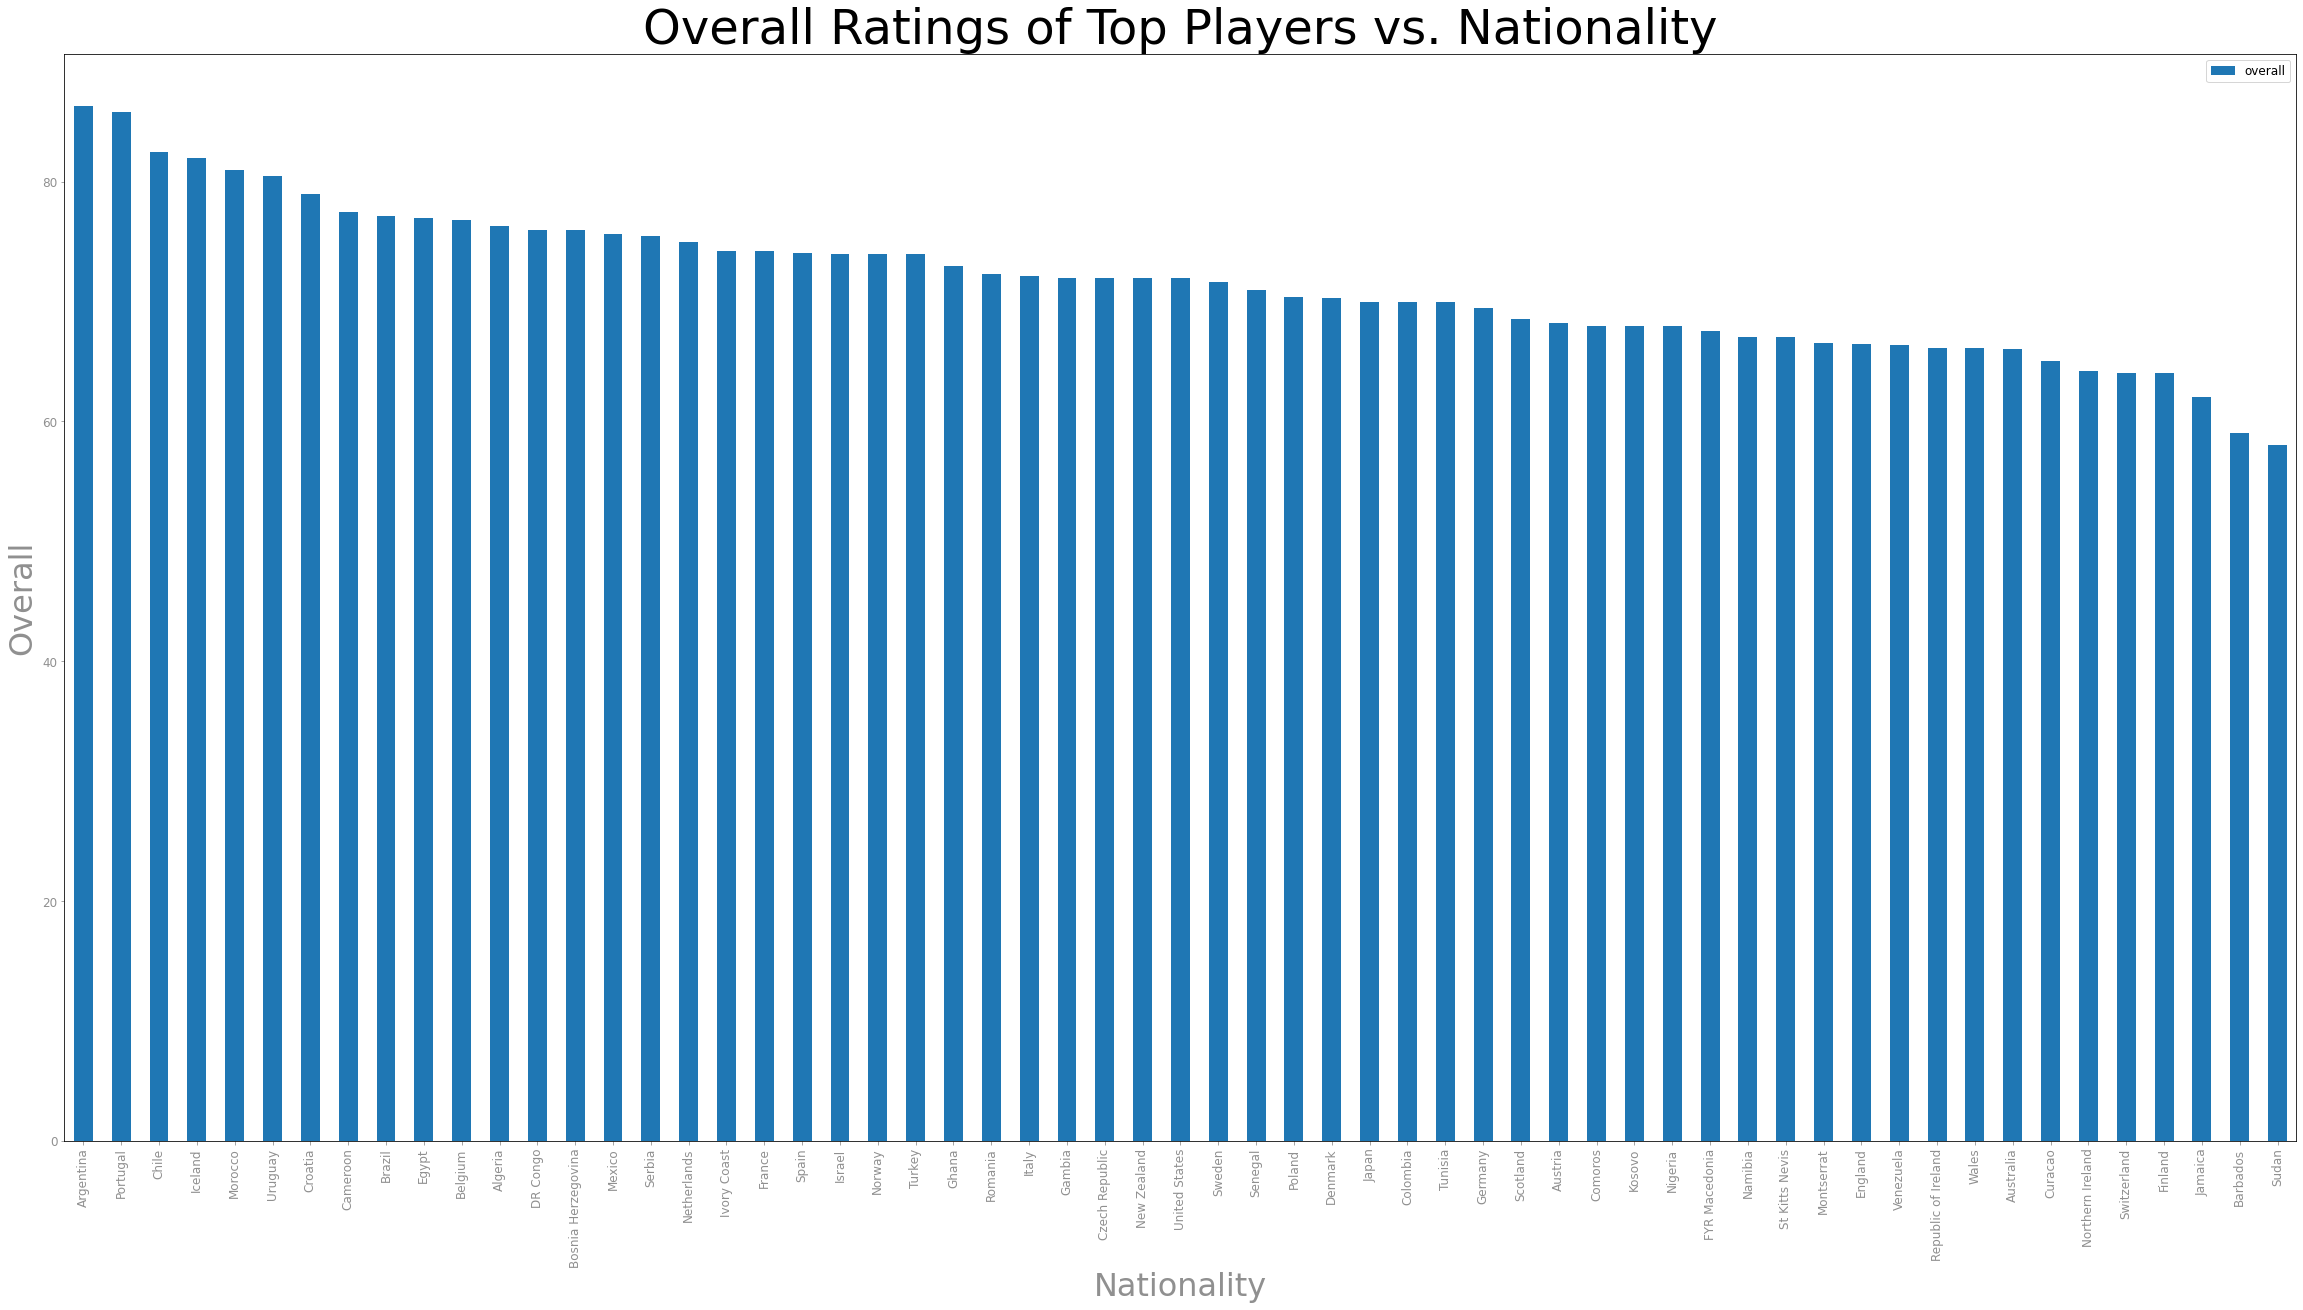

In [ ]:
# EDA - Racism | Overall Score while Looking at Top 10% of Players in Several Statistics

nationality_rating_df = final_df[["nationality","overall","goals","minutes","assists","complete_matches"]]
nationality_rating_df.loc[nationality_rating_df.goals == '', "goals"] = 0
nationality_rating_df.loc[nationality_rating_df.minutes == '', "minutes"] = 0
nationality_rating_df.loc[nationality_rating_df.assists == '', "assists"] = 0
nationality_rating_df.loc[nationality_rating_df.complete_matches == '', "complete_matches"] = 0
nationality_rating_df["goals"] = nationality_rating_df["goals"].astype(int)
nationality_rating_df["minutes"].replace(',','',regex=True,inplace=True)
nationality_rating_df["minutes"] = nationality_rating_df["minutes"].astype(int)
nationality_rating_df["assists"] = nationality_rating_df["assists"].astype(int)
nationality_rating_df["complete_matches"] = nationality_rating_df["complete_matches"].astype(int)

top_nationality_rating_df = nationality_rating_df
np.quantile(top_nationality_rating_df["goals"],.9) # 5.0
np.quantile(top_nationality_rating_df["minutes"],.9) # 2691.0
np.quantile(top_nationality_rating_df["assists"],.9) # 3
np.quantile(top_nationality_rating_df["complete_matches"],.9) # 26.0

top_nationality_rating_df = nationality_rating_df[nationality_rating_df.goals > 5]
top_nationality_rating_df = top_nationality_rating_df[top_nationality_rating_df.minutes > 2691]
top_nationality_rating_df = top_nationality_rating_df[top_nationality_rating_df.assists > 3]
top_nationality_rating_df = top_nationality_rating_df[top_nationality_rating_df.complete_matches > 26]

top_nationality_rating_df = top_nationality_rating_df.groupby('nationality').mean()
top_nationality_rating_df.reset_index(inplace=True)
top_nationality_rating_df.sort_values(by = "overall", ascending = False,inplace=True)
ax1 = top_nationality_rating_df.plot.bar(x = "nationality", y = "overall",figsize = (40,20))

ax1.set_ylabel('Overall',fontdict={'fontsize':32})
ax1.set_xlabel('Nationality',fontdict={'fontsize':32})
ax1.set_title("Overall Ratings of Top Players vs. Nationality", fontdict={'fontsize':48})

Luckily, we see from this bar chart that there isn't any significant change in the overall ratings of players from nationality to nationality. However, we are cognizant that we looked at this data at a more macro-level by taking averages over the players from each nation. If we had more time and resources to look at individual players, it would be interesting to see if we would be able to see more micro-aggressions against colored players in terms of overall rating.


We decided to continue investigating if there was obvious racism present in the soccer universe. This time, we decided to look at the real life statistics of all the players from different nationalities and see which nation on average had the highest number of yellow cards given to them by referees. It was our hope to see that there wasn't any country with significantly more yellow cards given to their players.

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:5170: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Text(0.5, 1.0, '# of Yellow Cards vs. Nationality')

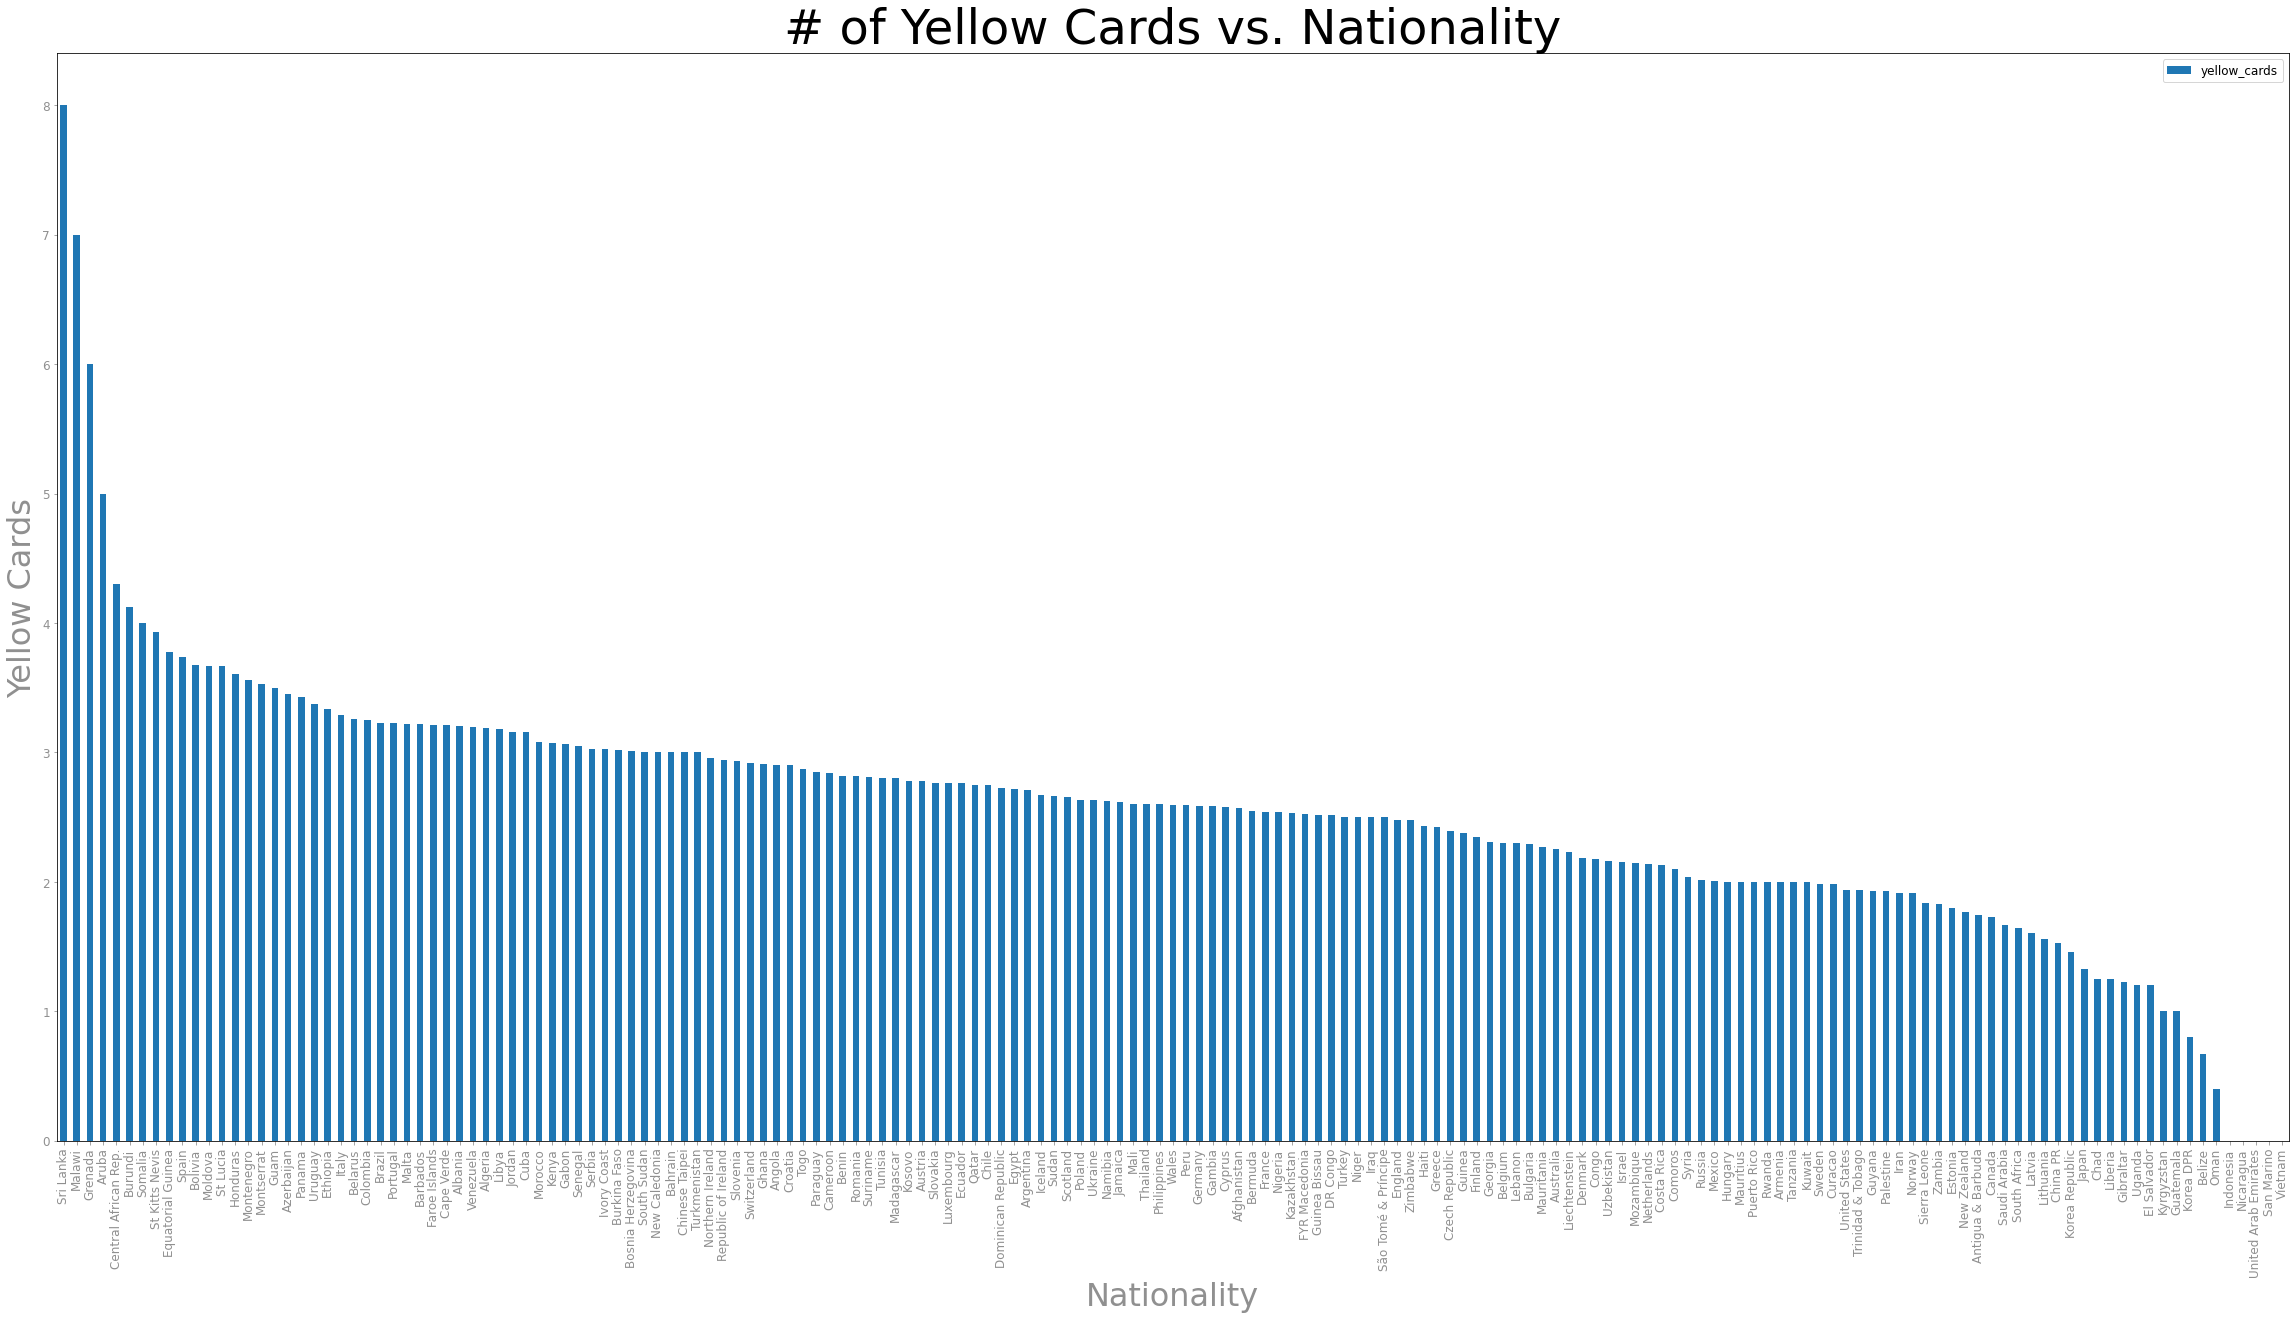

In [ ]:
# EDA - Racism | Yellow Cards based on Nationality

race_df = final_df[["nationality","yellow_cards"]]
race_df.loc[race_df.yellow_cards == '', "yellow_cards"] = 0

race_df.yellow_cards = race_df.yellow_cards.astype(int)

race_df = race_df.groupby("nationality").mean()
race_df = race_df.sort_values(by="yellow_cards",ascending=False)
race_df.reset_index()

ax2 = race_df.plot.bar(figsize=(40,20))

ax2.set_ylabel('Yellow Cards',fontdict={'fontsize':32})
ax2.set_xlabel('Nationality',fontdict={'fontsize':32})
ax2.set_title("# of Yellow Cards vs. Nationality", fontdict={'fontsize':48})

There was no country which had significantly more yellow cards given to their players. Again, this doesn't mean that there isn't any racism within referee behavior towards players - it just means that there weren't any significant signs of this within the average data we analyzed. In the future, we hope to be able to see this at a more granular player level to see what kind of new information we can uncover.

A common dispute among football fans is which of the major leagues is superior. In football, there are numerous leagues with every major country having their own league featuring multiple tiers. The best players tend to play in a select few leagues, so we wanted to find the top leagues based on the average overall rating of their players.

Text(0.5, 1.0, 'Average Overall Rating in Top Leagues')

<Figure size 432x288 with 0 Axes>

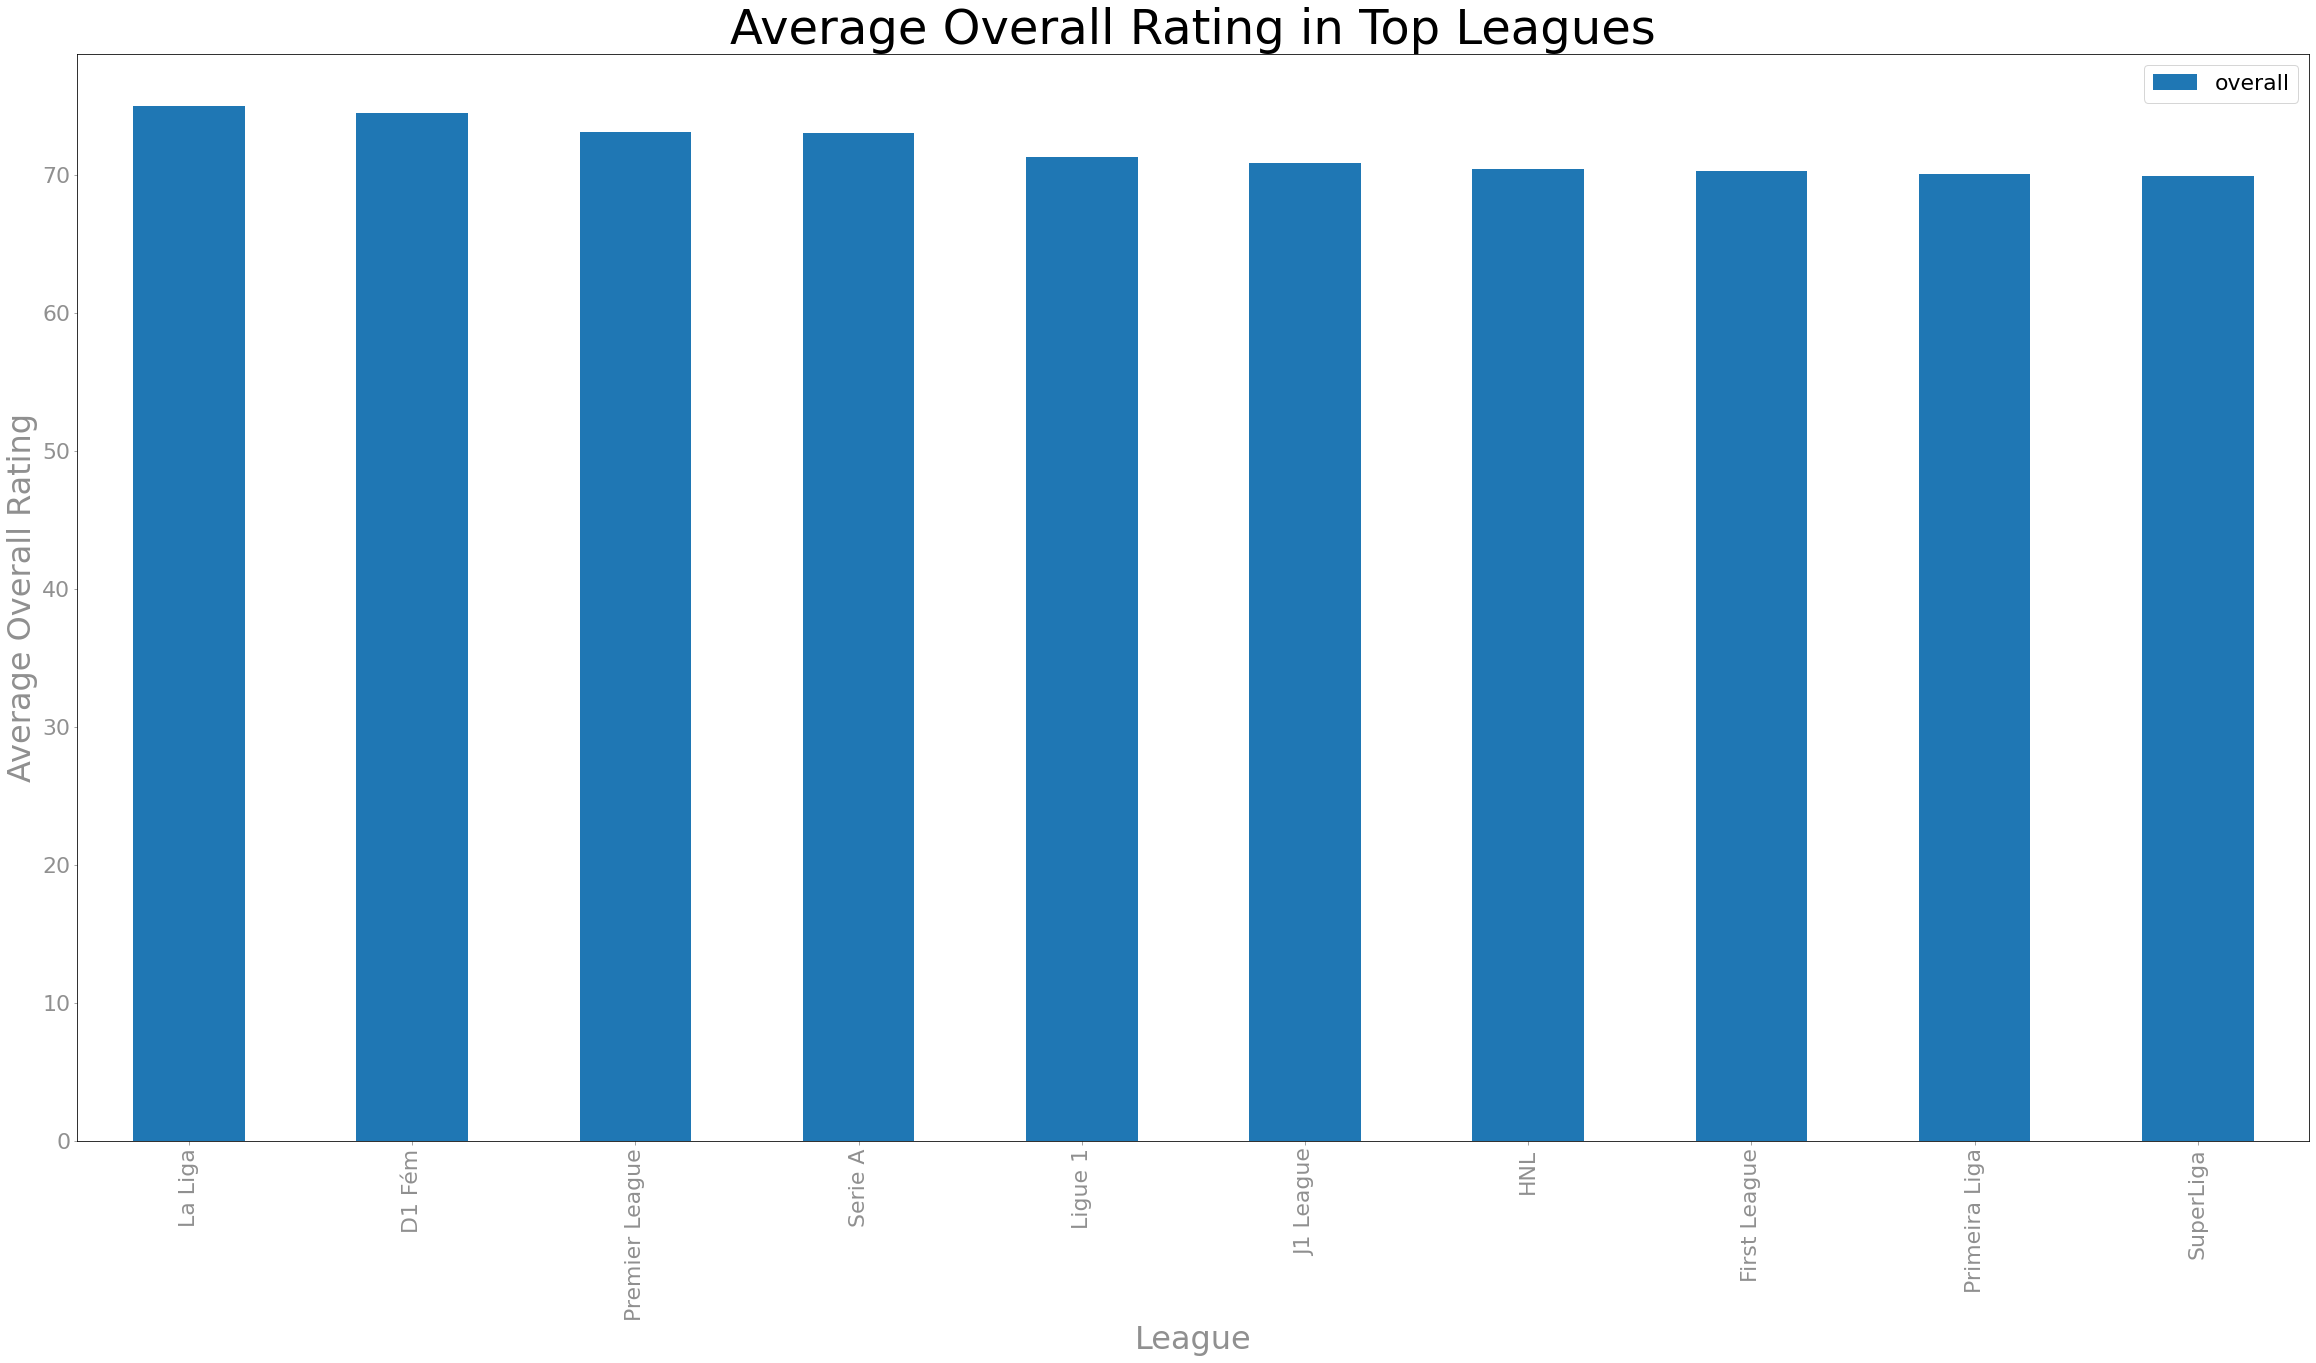

In [ ]:
# EDA | Which League in the Champions League has the highest Overall Rating

league_df = final_df[["stats_name","kaggle_club","goals","assists","league_rank","competition","season","overall","shooting"]]
new_df = league_df.groupby(["competition"]).mean()
new_df = new_df.sort_values(by = "overall", ascending = False)
new_df.reset_index(inplace = True)

plt.figure()
plt.rcParams.update({'font.size': 22}) # must set in top
plot_df = new_df[["competition","overall"]]
ax = plot_df.head(10).plot.bar(x = "competition", y = "overall",figsize = (40,20))

ax.set_ylabel('Average Overall Rating',fontdict={'fontsize':32})
ax.set_xlabel('League',fontdict={'fontsize':32})

ax.set_title('Average Overall Rating in Top Leagues',fontdict={'fontsize':48})

We see here that Spaniards and other fans of Spanish soccer would be very happy looking at these results! La Liga, the premier soccer league within Spain, has the highest overall ratings compared to any of the other premier leagues in their respective nations. This doesn't come as any surprise to us, as in the past couple of years, many of the top players in the world such as Lionel Messi, Cristiano Ronaldo, Luiz Suarez, and more have all played in this league.

Many fans are convinced that some players are overrated due to the success of their team, or vice versa that their players are underrated due to the failures of their team. We decided to take a closer look and see how team rank affects the overall rating of players, while controlling for the number of goals scored. We wanted to ensure that we were looking at similar calibers of players so we looked at only the top three leagues as determined from our analysis above.

Text(0.5, 1.0, 'Average Overall Ratings of Players on Clubs in Ligue 1 vs. Club Ranking')

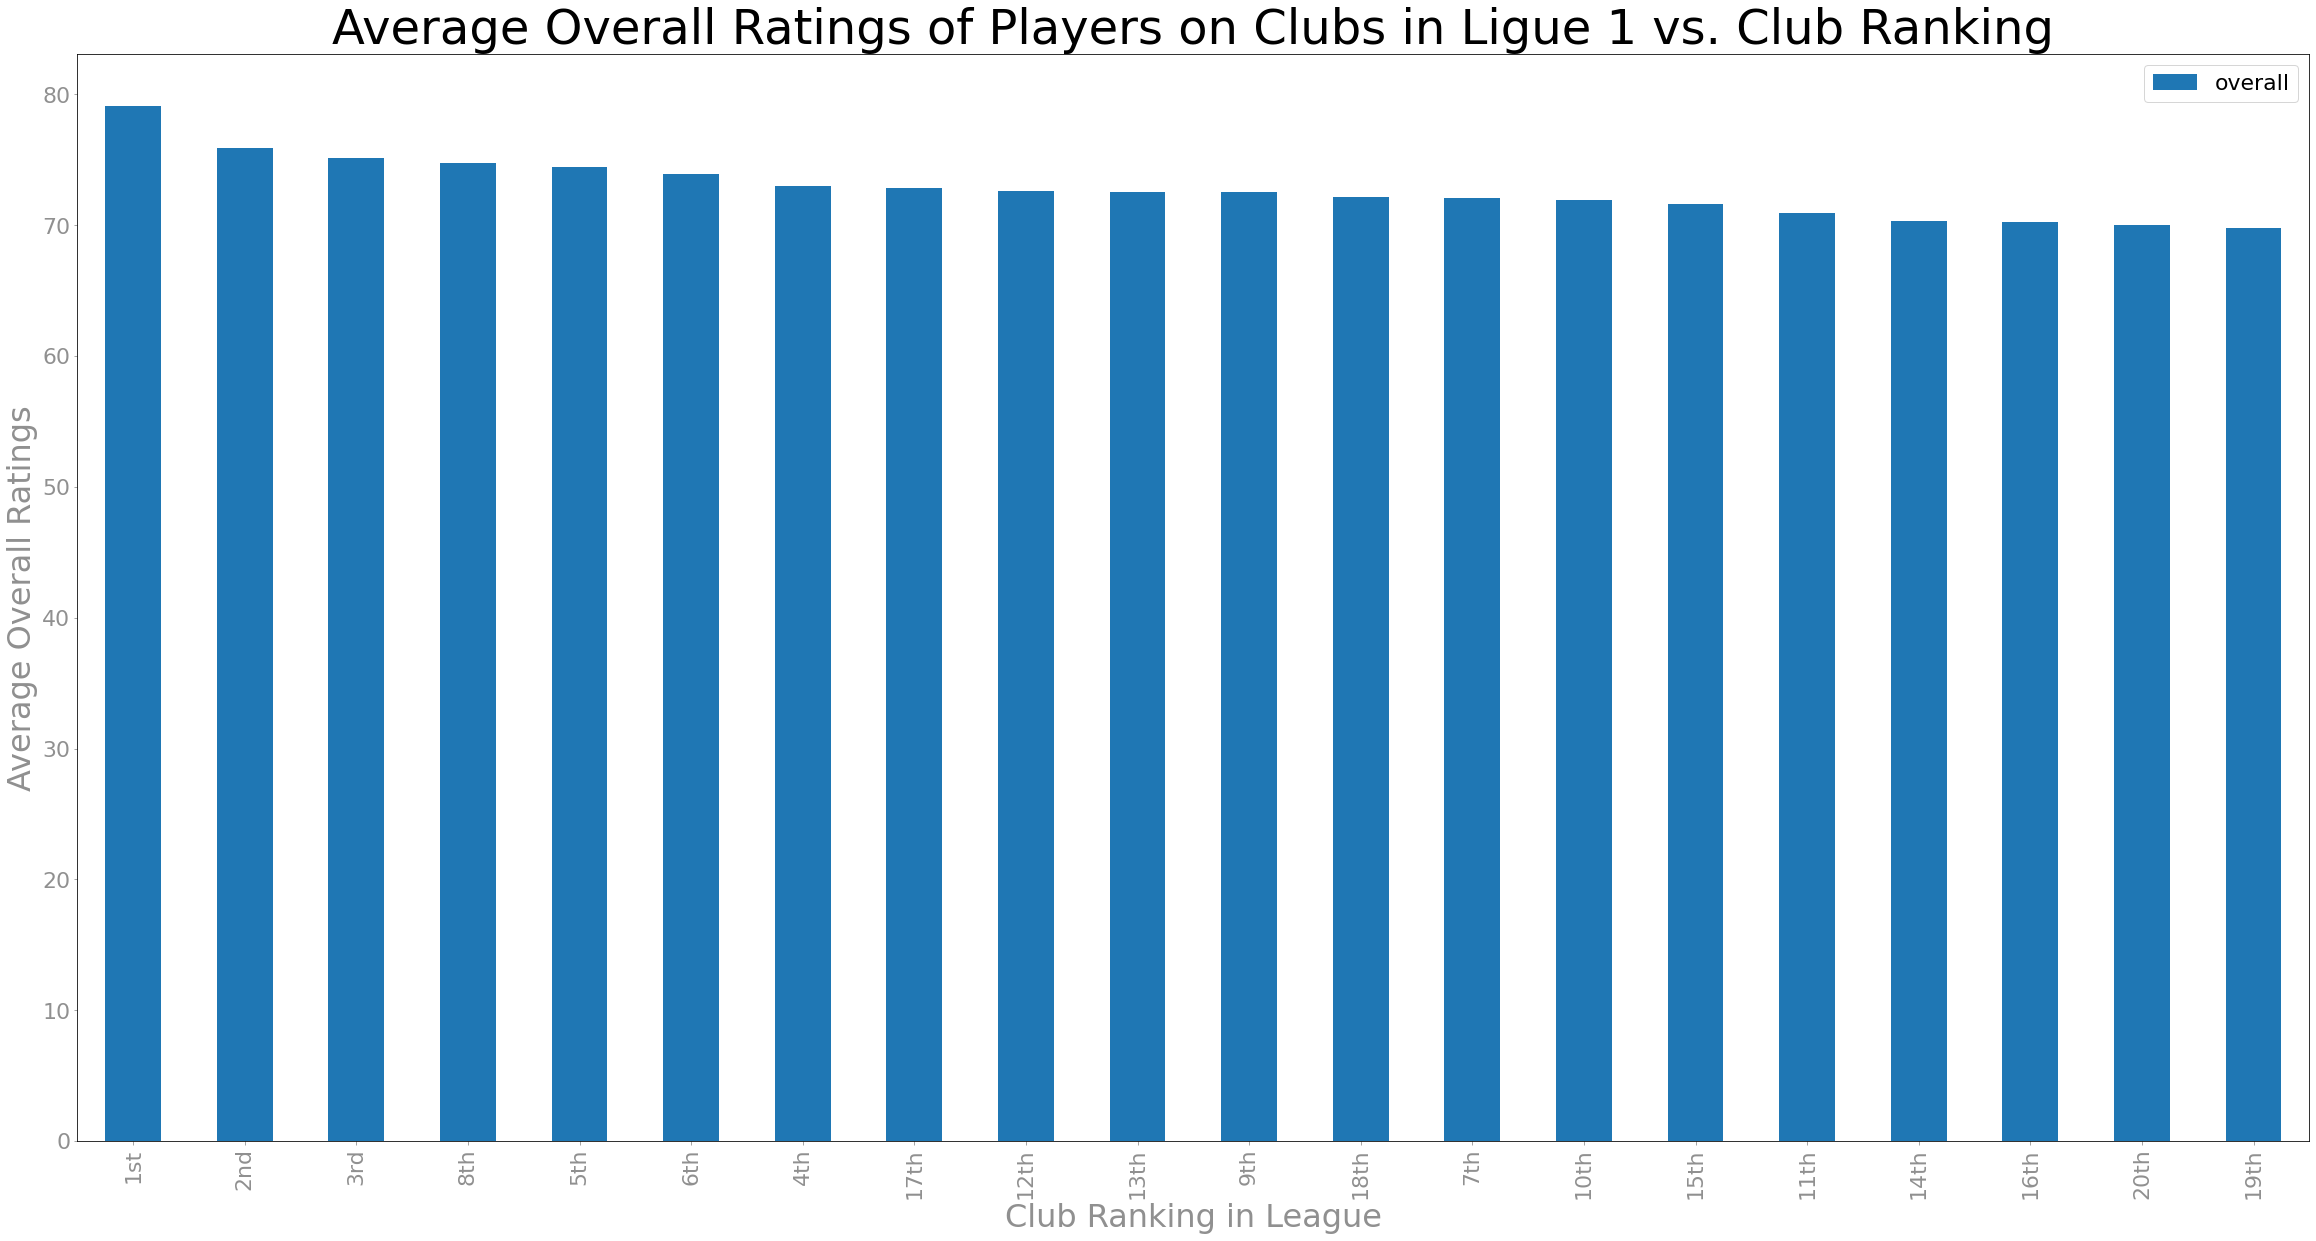

In [ ]:
# Within a league, Let's look at if your team rank affects your rating (controlling on goals scored) 
# only looking at top three leagues

league_df = league_df[league_df.goals != '']
league_df = league_df[league_df.assists != '']
league_df["goals"] = league_df.goals.astype(int)
league_df["assists"] = league_df.assists.astype(int)

# Find average FIFA rating in each league (plot top 10)
serieA_df = league_df.loc[league_df['competition'] == 'Serie A']
ligue1_df = league_df.loc[league_df['competition'] == 'Ligue 1']
premier_df = league_df.loc[league_df['competition'] == 'Premier League']


# Ligue 1
np.quantile(ligue1_df["goals"],.5) # 0
np.quantile(ligue1_df["goals"],.9) # 5
ligue1_df = ligue1_df[(ligue1_df["goals"] > 0) & (ligue1_df["goals"] < 5)]
ligue1_df = ligue1_df.groupby(["league_rank"]).mean()
ligue1_df = ligue1_df.sort_values(by = "overall", ascending = False)
ligue1_df.reset_index(inplace = True)
ax4 = ligue1_df.plot.bar(x = "league_rank", y = "overall",figsize = (40,20))


ax4.set_ylabel('Average Overall Ratings',fontdict={'fontsize':32})
ax4.set_xlabel('Club Ranking in League',fontdict={'fontsize':32})

ax4.set_title('Average Overall Ratings of Players on Clubs in Ligue 1 vs. Club Ranking',fontdict={'fontsize':48})

Text(0.5, 1.0, 'Average Overall Ratings of Players on Clubs in Serie A vs. Club Ranking')

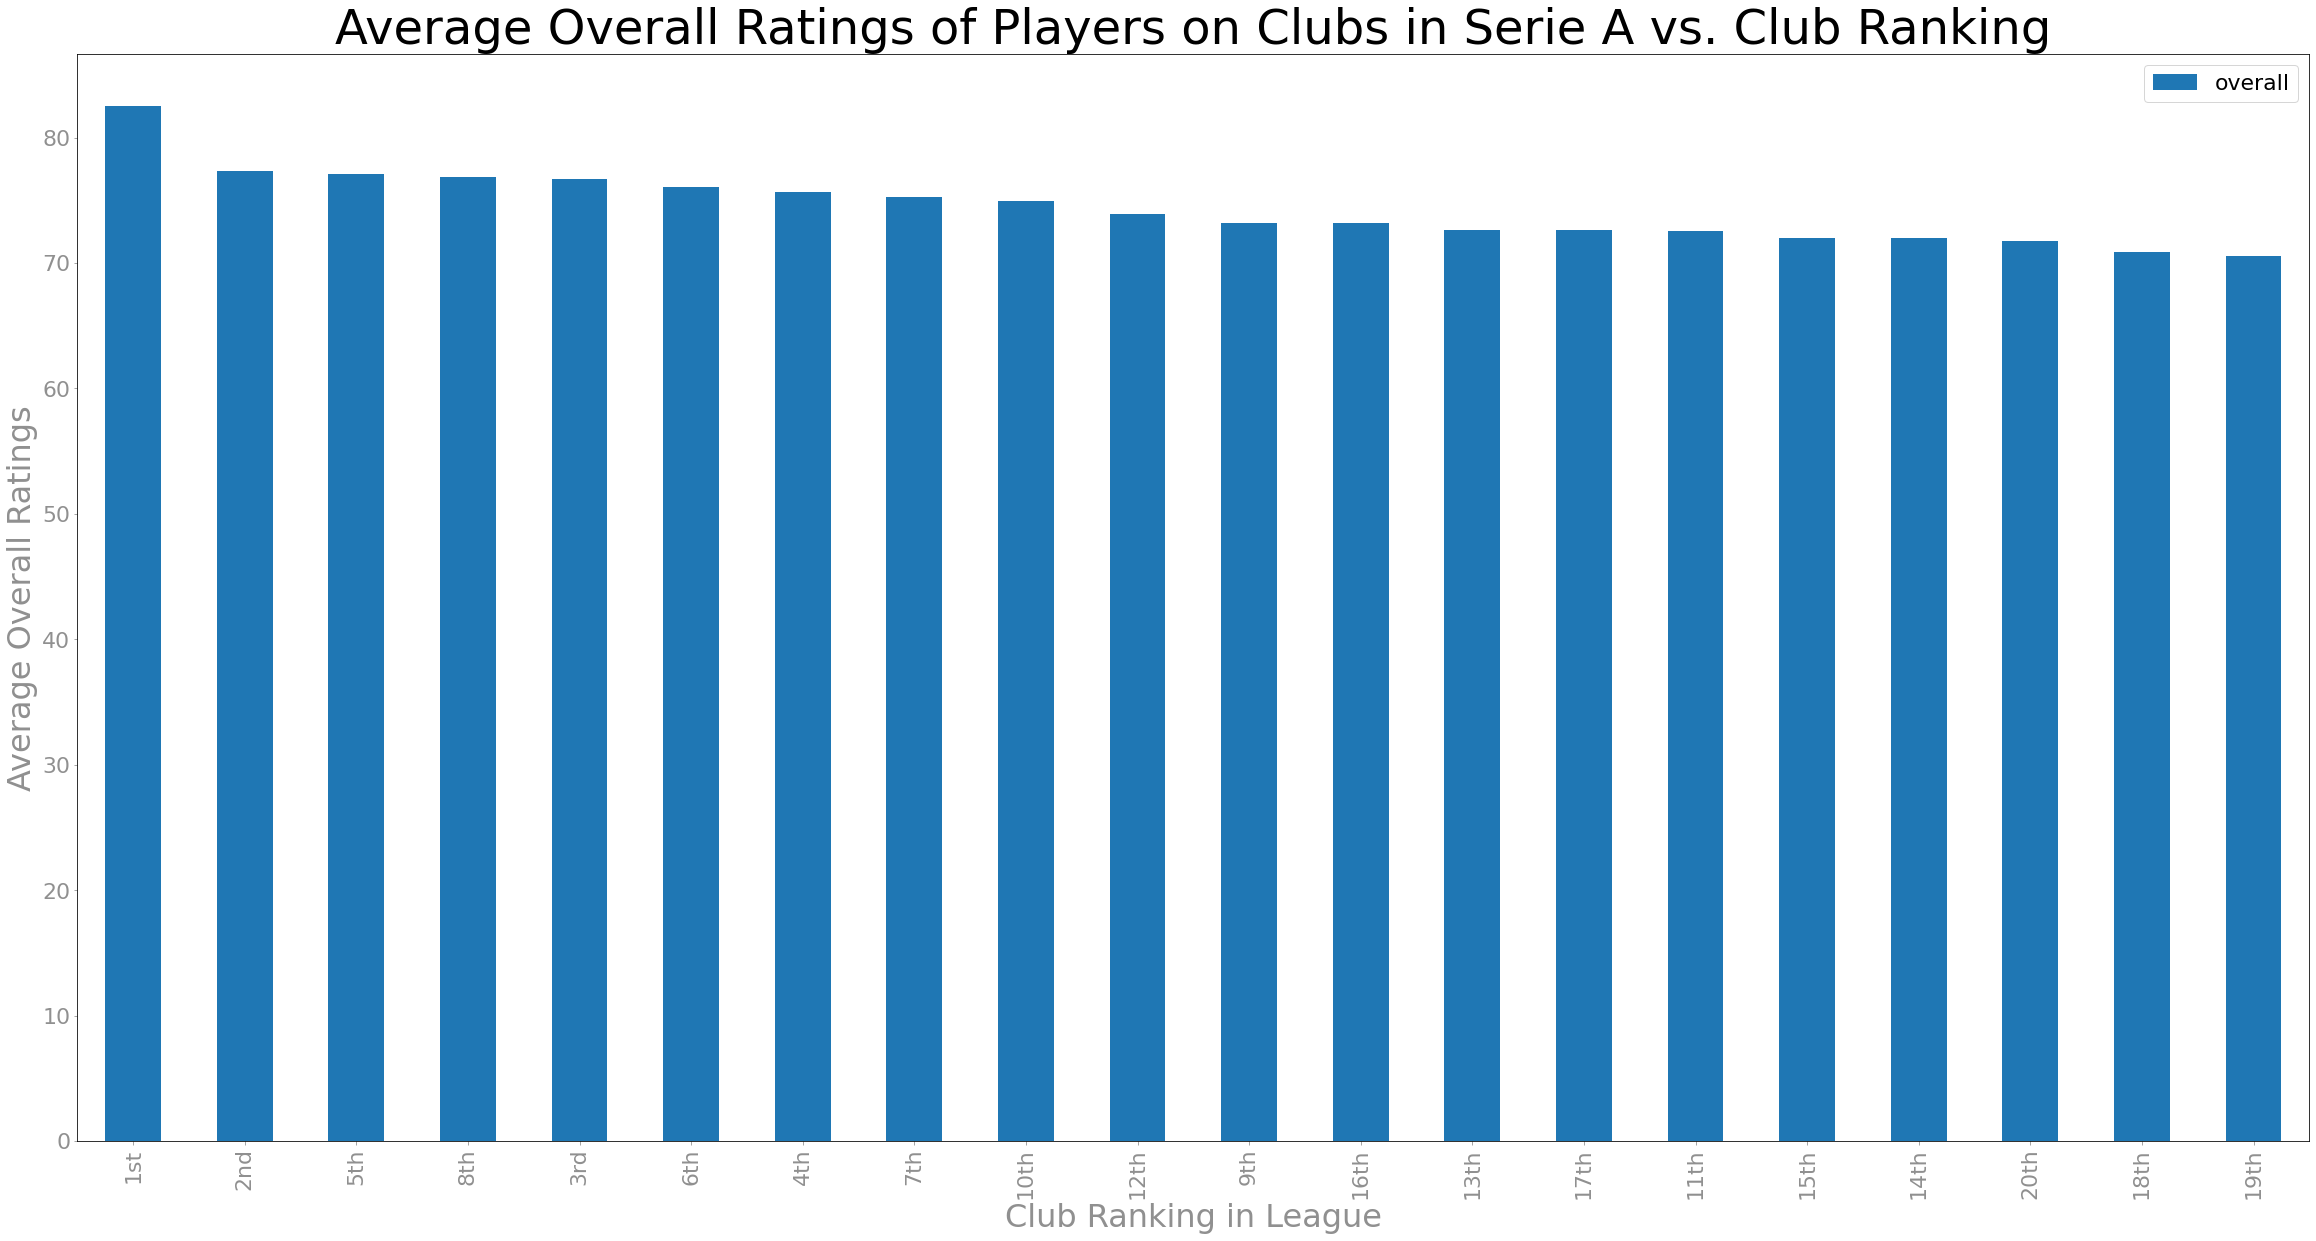

In [ ]:
# Serie A
np.quantile(serieA_df["goals"],.5) # 0.0
np.quantile(serieA_df["goals"],.9) # 6.0
serieA_df = serieA_df[(serieA_df["goals"] > 0) & (serieA_df["goals"] < 6)]
serieA_df = serieA_df.groupby(["league_rank"]).mean()
serieA_df = serieA_df.sort_values(by = "overall", ascending = False)
serieA_df.reset_index(inplace = True)
ax5 = serieA_df.plot.bar(x = "league_rank", y = "overall",figsize = (40,20))

ax5.set_ylabel('Average Overall Ratings',fontdict={'fontsize':32})
ax5.set_xlabel('Club Ranking in League',fontdict={'fontsize':32})

ax5.set_title('Average Overall Ratings of Players on Clubs in Serie A vs. Club Ranking',fontdict={'fontsize':48})

Text(0.5, 1.0, 'Average Overall Ratings of Players on Clubs in Premier League vs. Club Ranking')

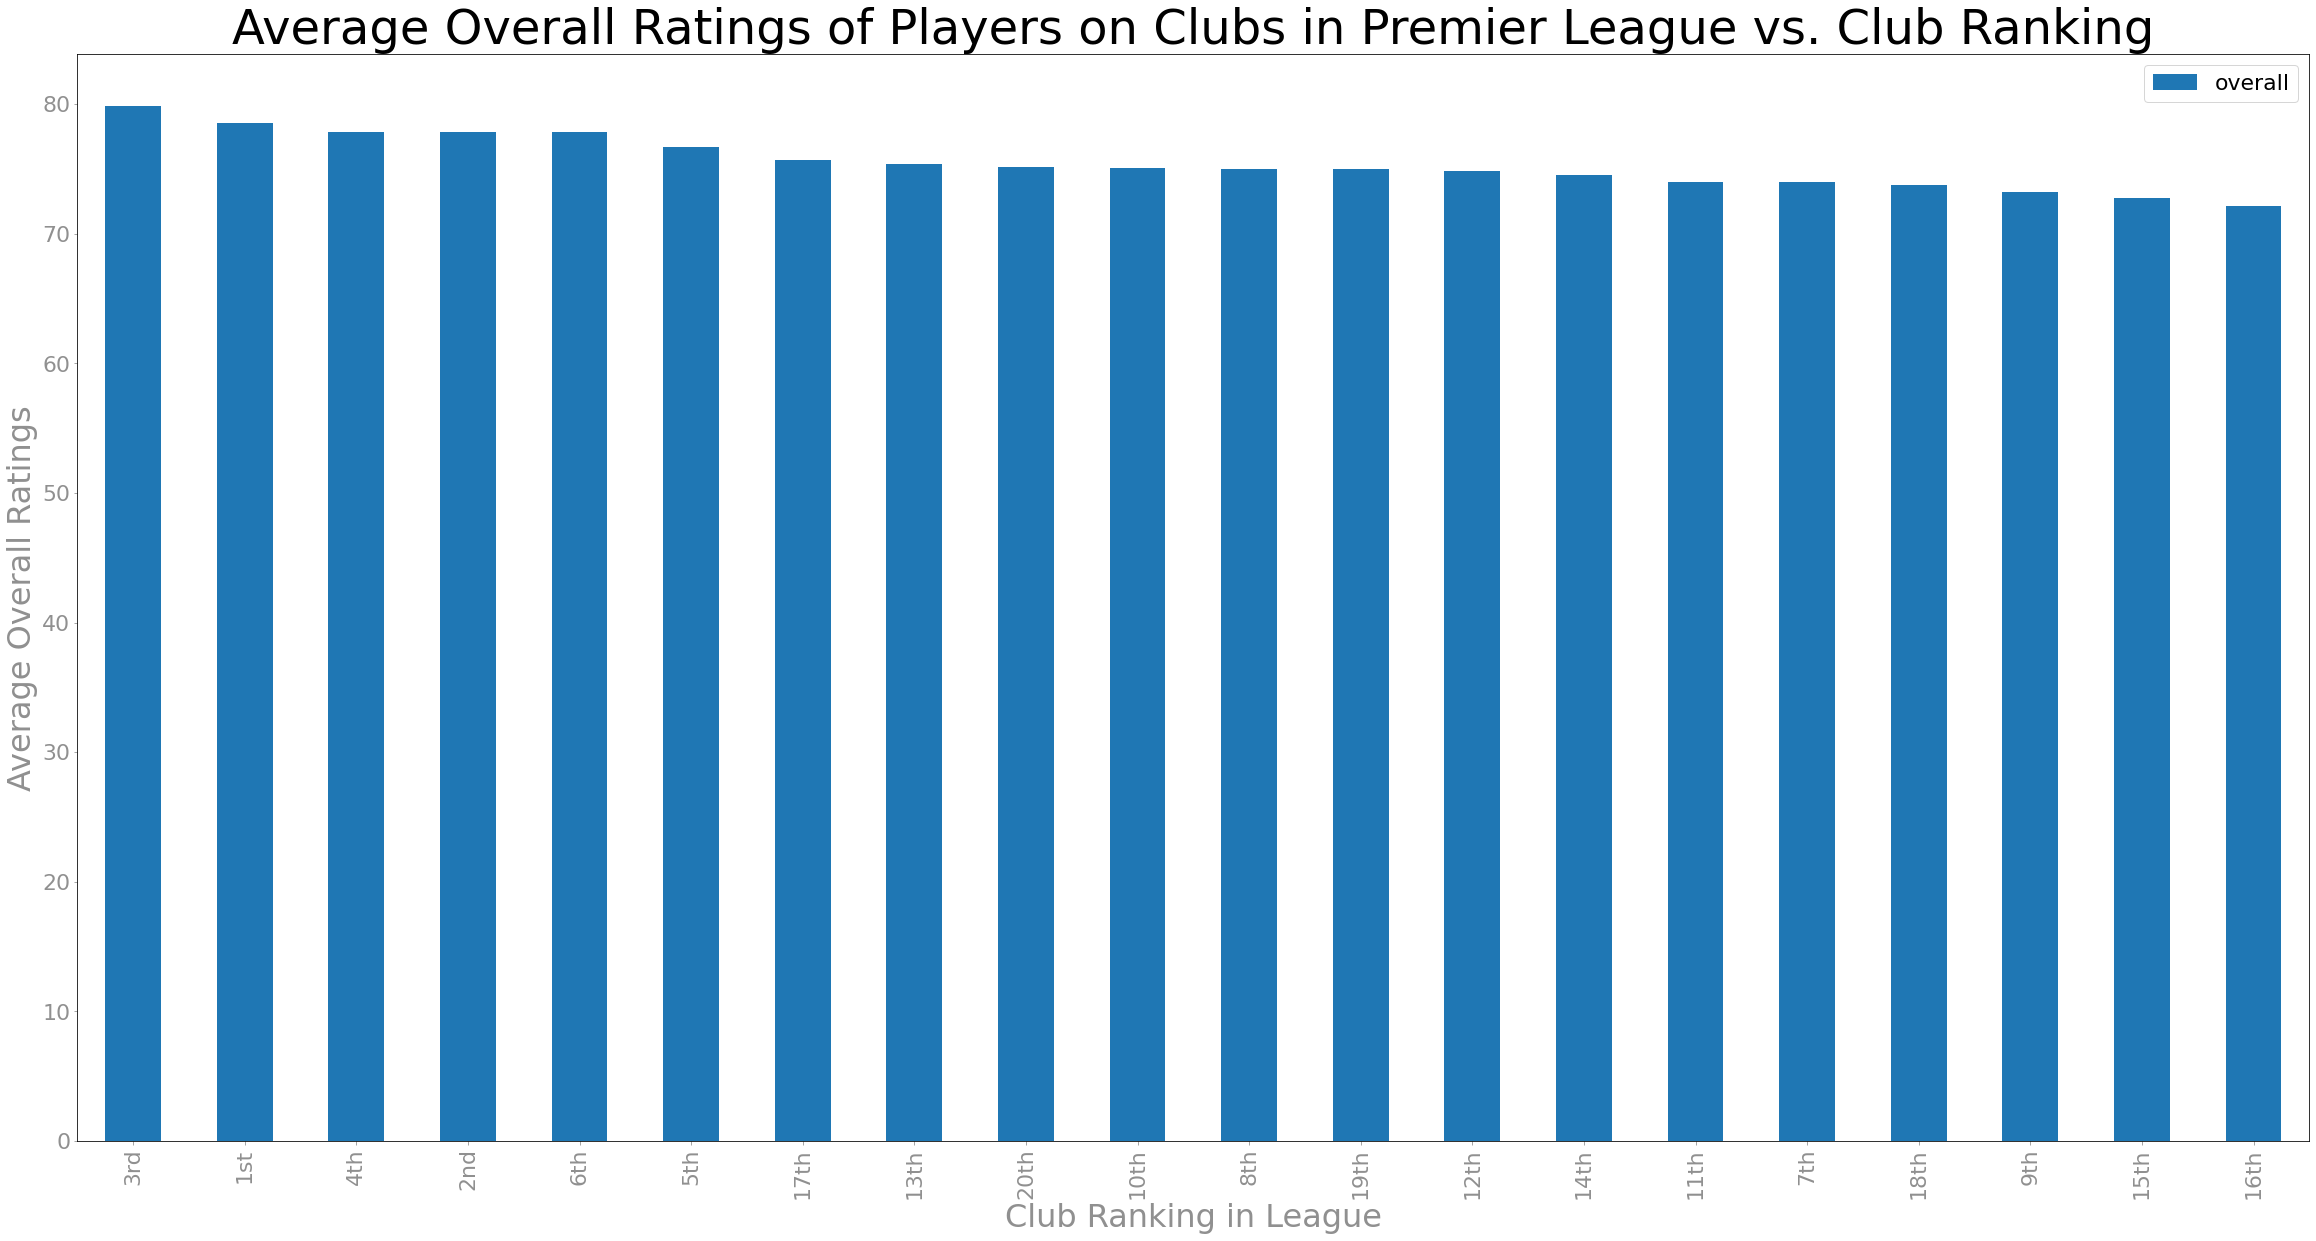

In [ ]:

# Premier League
np.quantile(premier_df["goals"],.5) # 2.0
premier_df = premier_df[(premier_df["goals"] > 2) & (premier_df["goals"] < 8)]
premier_df = premier_df.groupby(["league_rank"]).mean()
premier_df = premier_df.sort_values(by = "overall", ascending = False)
premier_df.reset_index(inplace = True)
ax6 = premier_df.plot.bar(x = "league_rank", y = "overall",figsize = (40,20))

ax6.set_ylabel('Average Overall Ratings',fontdict={'fontsize':32})
ax6.set_xlabel('Club Ranking in League',fontdict={'fontsize':32})

ax6.set_title('Average Overall Ratings of Players on Clubs in Premier League vs. Club Ranking',fontdict={'fontsize':48})

There is definitely a positive correlation between league rank and overall ratings for players. However, this trend is not perfectly linear and we see that there are instances of lower ranked teams having higher overall ratings. 

Looking at our data, we saw that there were certain characteristics which looked similar at face value but we wanted to see if there was a difference in how much they actually correlated with the scores that FIFA gave. One specific example of this was the number of goals vs the number of goals scored per minute played for each player. We decided to put this to the test and compare these two variables against the shooting score that FIFA assigned to these players.

Text(0.5, 1.0, 'Shooting Score vs Goals Scored')

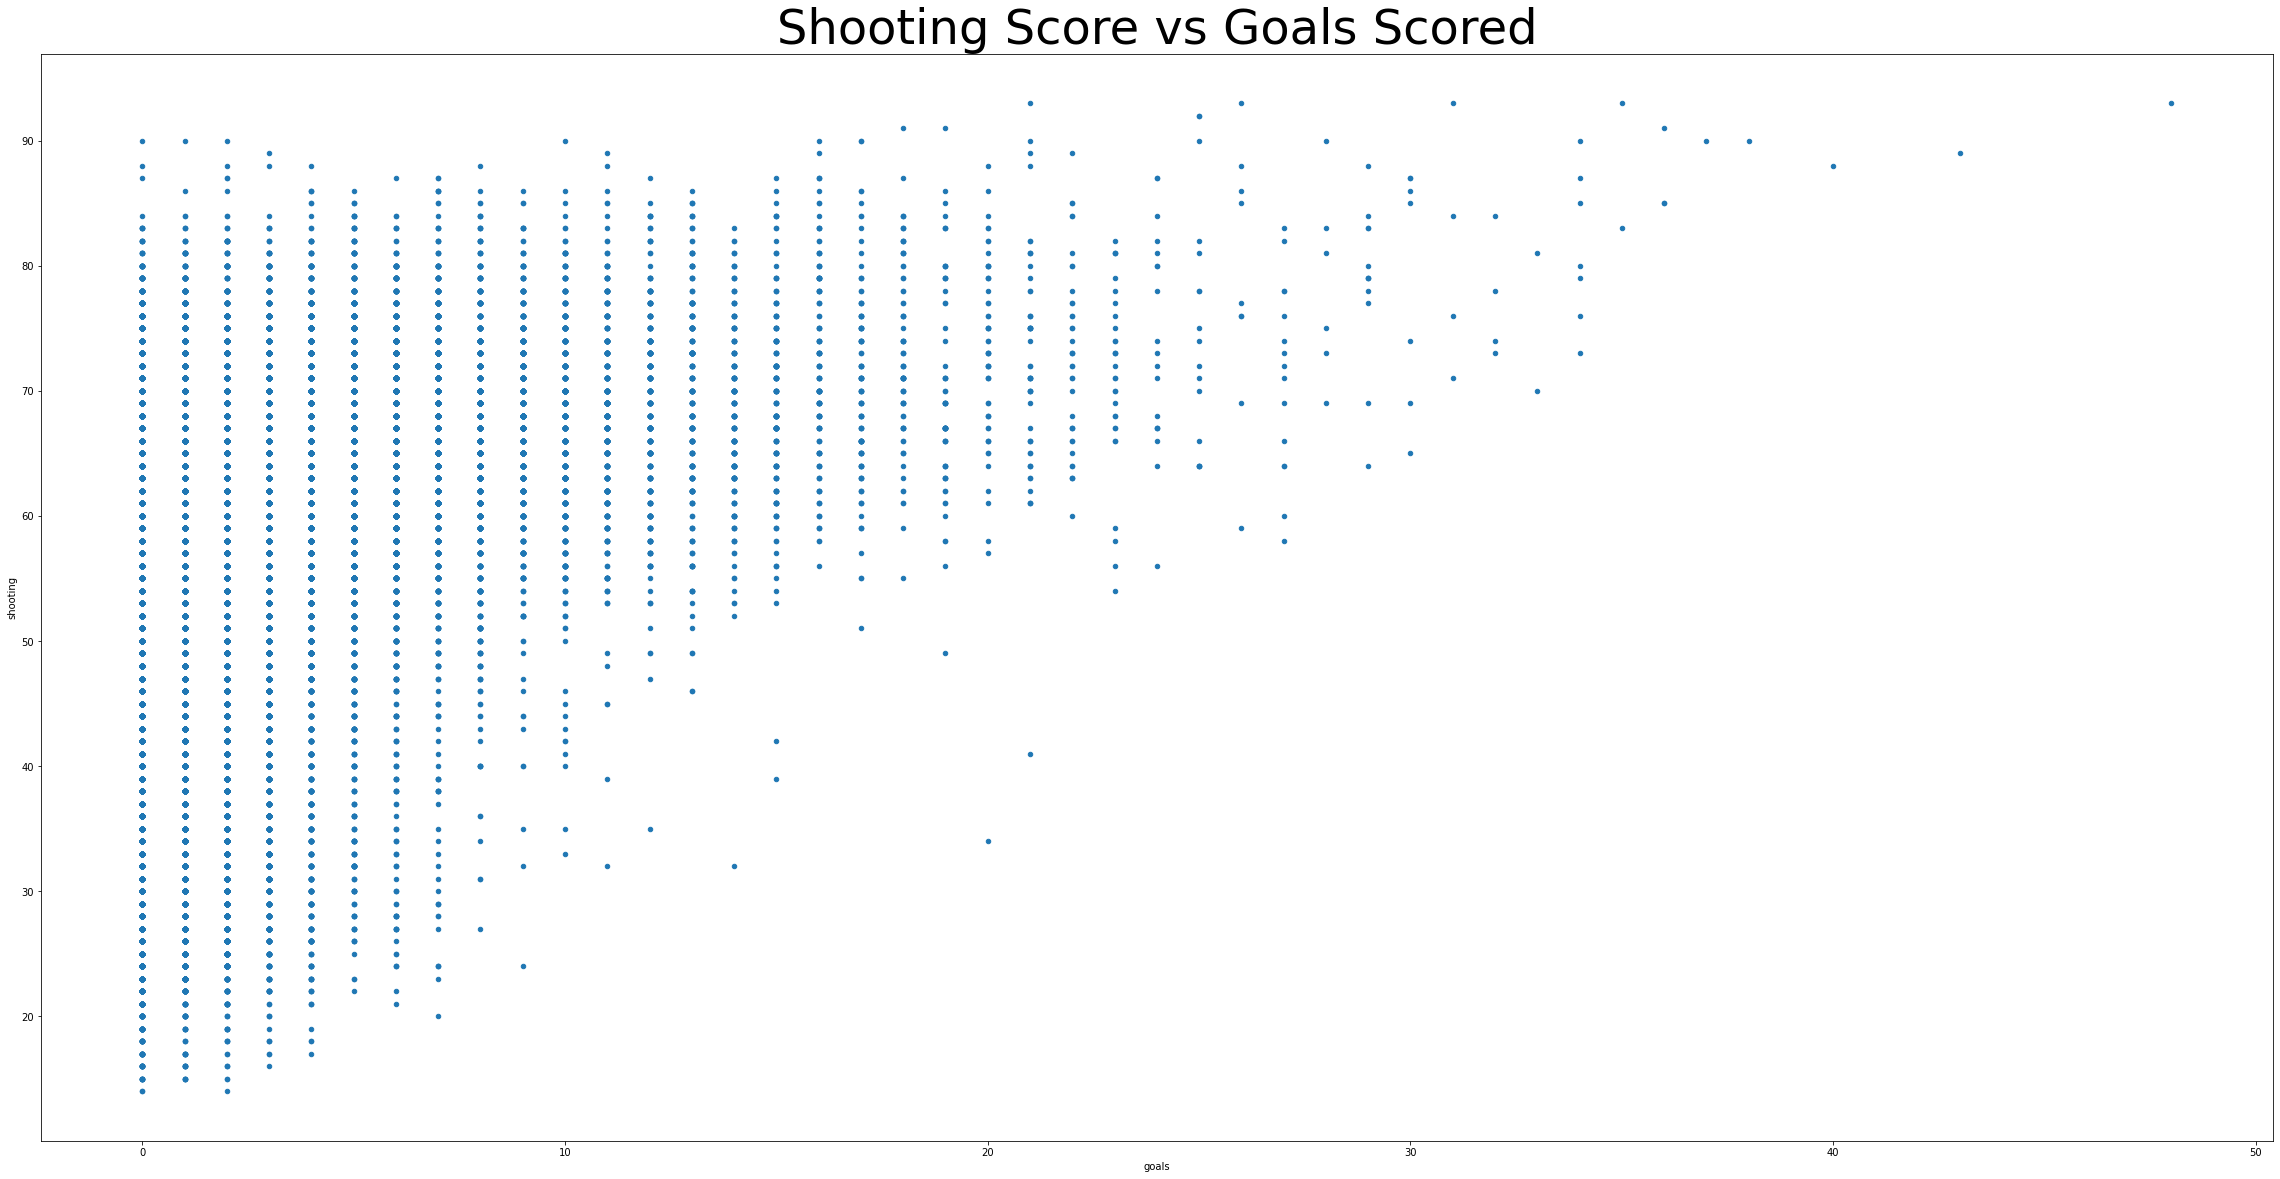

In [ ]:
# EDA - What really matters - number of goals or productivity of goals? 
# Scatter of Shooting Score vs Goals or Goals per Minute


# How do minutes played factor into ratings?
# Let's look at a plot of Shooting Ratings vs. Goals and Shooting Rating vs. Goals/Minute Played

scores_df = final_df[["stats_name","goals","minutes","shooting"]]
scores_df = scores_df[scores_df.goals != '']
scores_df.goals = scores_df.goals.astype(int)

scores_df.dropna(subset = ["goals","shooting"])

ax7 = scores_df.plot.scatter(x = "goals",y = "shooting", figsize=(40,20))

ax7.set_title('Shooting Score vs Goals Scored',fontdict={'fontsize':48})



Text(0.5, 1.0, 'Shooting Score vs Goals Scored per Minute')

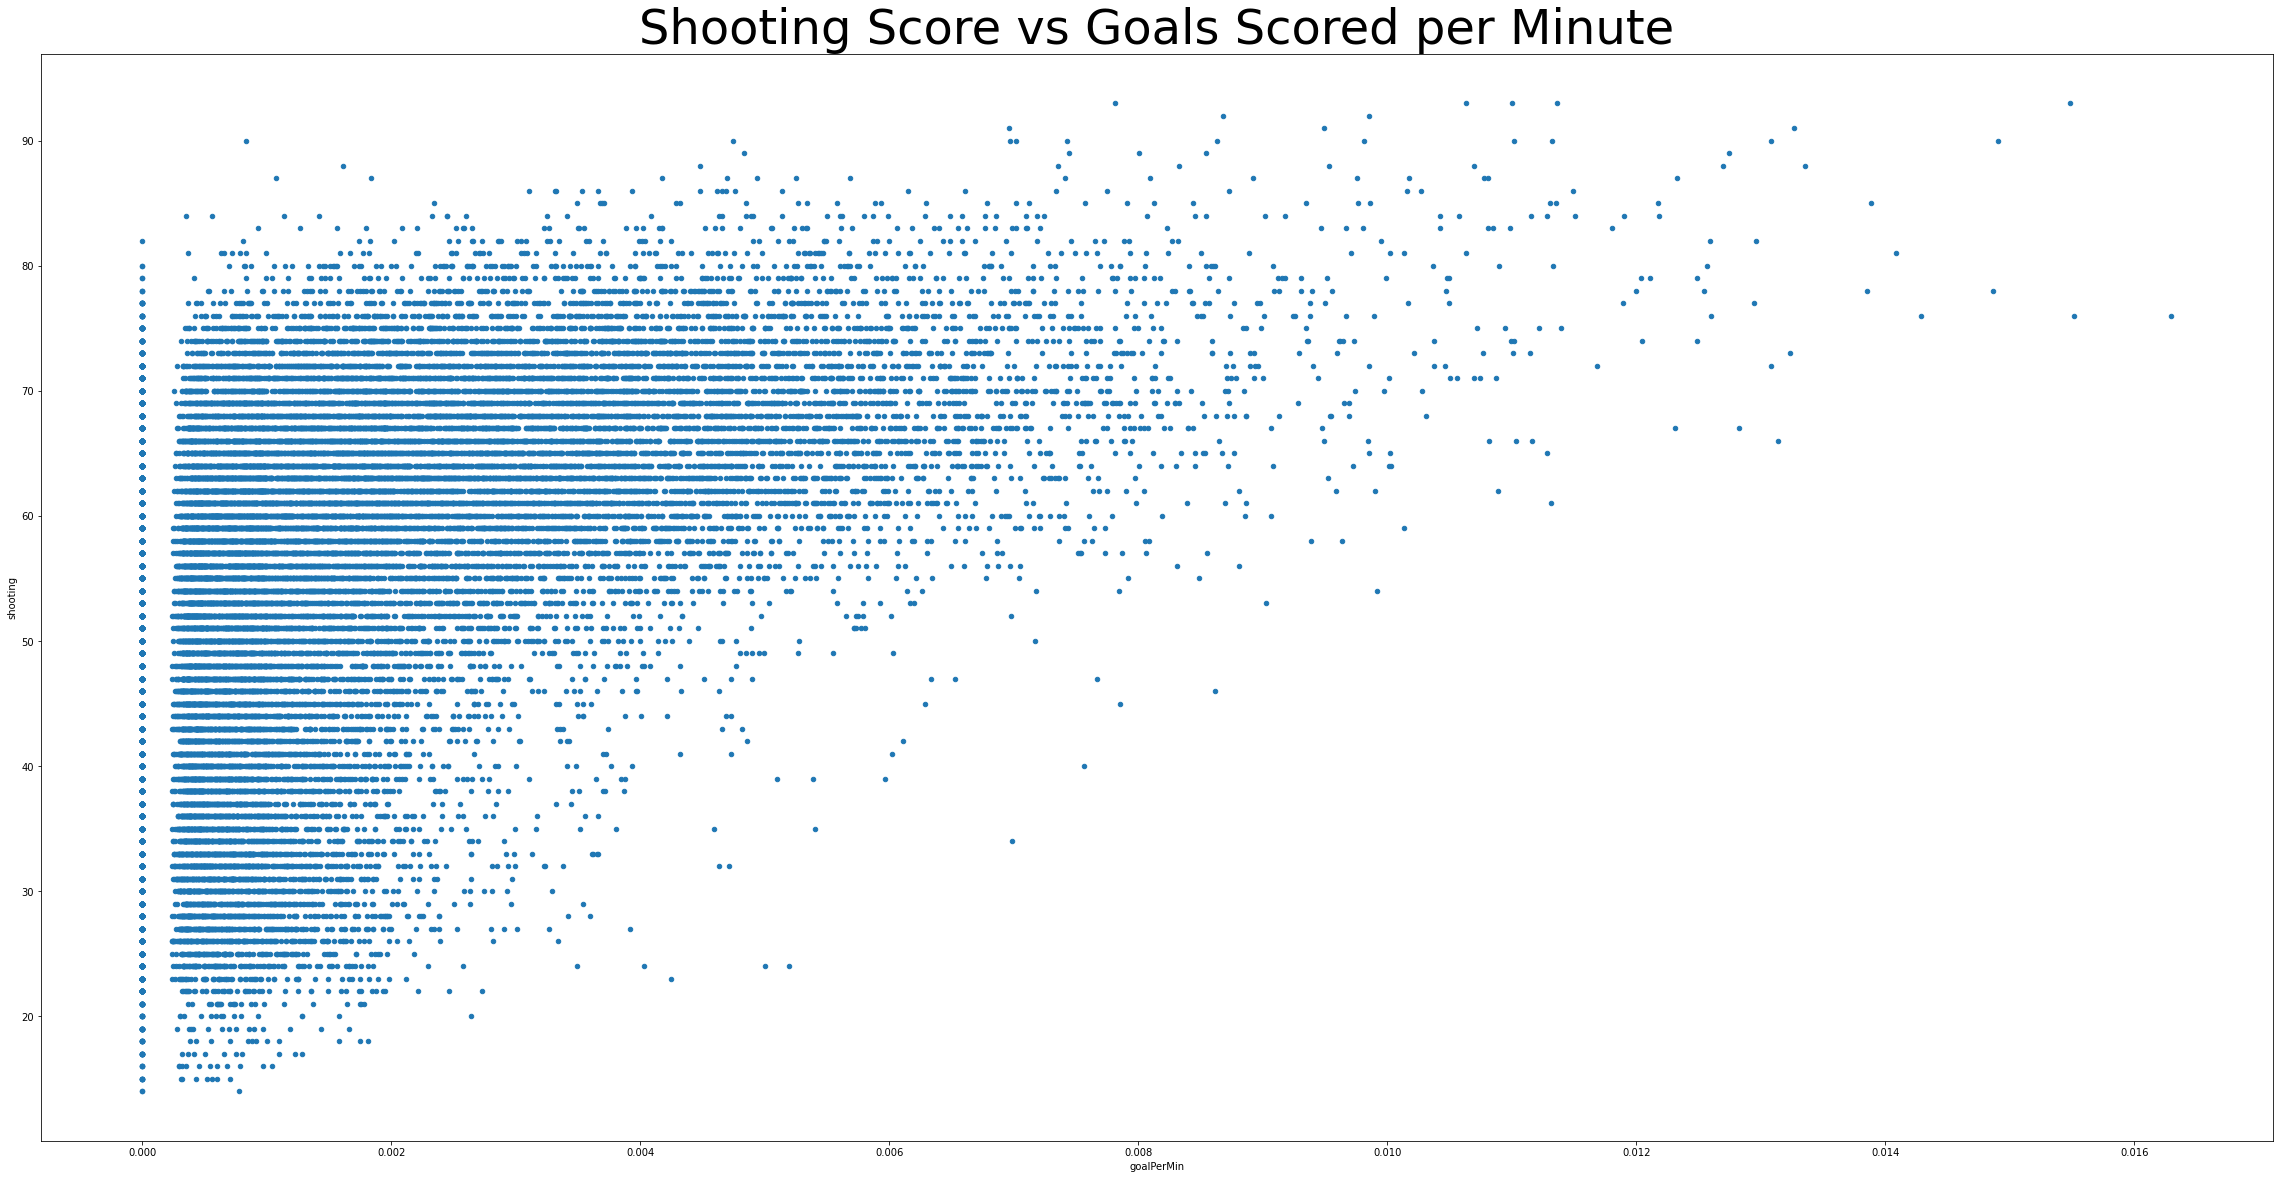

In [ ]:
scores_df["minutes"] = scores_df['minutes'].str.replace('[^\w\s]','')
scores_df = scores_df[scores_df.minutes != '']
scores_df.minutes = scores_df.minutes.astype(int)
scores_df = scores_df[scores_df.minutes > 1000]
scores_df['goalPerMin'] = scores_df.apply(lambda row: row.goals/(row.minutes), axis = 1)

ax8 = scores_df.plot.scatter(x = "goalPerMin",y = "shooting", figsize=(40,20))

ax8.set_title('Shooting Score vs Goals Scored per Minute',fontdict={'fontsize':48})



Hmmm... it seems odd that for both Shooting vs. Goals and Shooting vs. Goals Per Minute, we see players with essentially no goals have very high ratings. Let's take a look at some of these players to see if we can figure out what is going on.

In [ ]:
scores_df[(scores_df["shooting"]>80) & (scores_df["goals"]<2)]

,stats_name,goals,minutes,shooting,goalPerMin
19779,Paul Pogba,1,1204,81.0,0.000831
11115,Eden Hazard,1,1077,83.0,0.000929
3031,Andre Schurrle,1,1236,82.0,0.000809
4408,Ibai Gomez,1,1010,81.0,0.000990
3966,Giovani dos Santos,1,1390,81.0,0.000719
8092,Denis Suarez,1,1197,90.0,0.000835
25195,Toni Kroos,0,2221,82.0,0.000000
21039,Marco Asensio,1,1779,84.0,0.000562
14695,Ivan Rakitic,1,1589,81.0,0.000629
10291,Toni Kroos,1,2734,81.0,0.000366


These players are some of the biggest names in football! It looks like they each had a poor season. Could it be possible that FIFA does not simply look at a single season's stats to calculate ratings for a player? Let's look at the individual stats for some of these players across multiple seasons.

In [ ]:
final_df[final_df.stats_name == "Eden Hazard"]

,stats_name,kaggle_club,season,age_x,country,competition,league_rank,matches_played,starts,minutes,goals,assists,pk,pk_attempted,yellow_cards,red_cards,second_yellow_cards,fouls,fouls_drawn,offsides,crosses,interceptions,tackles_won,pk_won,pk_conceded,own_goals,min %,complete_matches,subs,unused_sub,team_ppm,team_goals,team_goals_allowed,team_plus-minus,team_plus-minus_90,team_plus-minus_net,height_cm,weight_kg,nationality,overall,...,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_marking,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes,ls,st,rs,lw,lf,cf,rf,rw,lam,cam,ram,lm,lcm,cm,rcm,rm,lwb,ldm,cdm,rdm,rwb,lb,lcb,cb,rcb,rb
11115,Eden Hazard,Real Madrid,2020,28,ESP,La Liga,1st,16,14,"1,077",1,3,0,0,0,0,0,12,50,2,18,10,7,3,0,0,31.5,3,2,3,2.44,27,5,+22,+1.84,+0.95,175,74,Belgium,91,...,54,41,87,89,88,91,34,27,22,11,12,6,8,8,83+3,83+3,83+3,89+3,88+3,88+3,88+3,89+3,89+3,89+3,89+3,89+3,83+3,83+3,83+3,89+3,66+3,63+3,63+3,63+3,66+3,61+3,49+3,49+3,49+3,61+3
2918,Eden Hazard,Chelsea,2016,24,ENG,Premier League,10th,31,25,"2,191",4,3,0,0,2,0,,15,,,,,,,,,64.1,19,6,0,1.32,36,32,+4,+0.16,+0.02,173,74,Belgium,89,...,54,41,86+2,86,86,NaN,25,27,22,11,12,6,8,8,82+2,82+2,82+2,88+2,87+2,87+2,87+2,88+2,88+2,88+2,88+2,87+2,80+2,80+2,80+2,87+2,64+2,61+2,61+2,61+2,64+2,58+2,47+2,47+2,47+2,58+2
9258,Eden Hazard,Chelsea,2018,26,ENG,Premier League,5th,34,28,"2,422",12,4,2,2,2,0,0,,,,,,,,,0,3.7,0,0,0,0.00,0,2,-2,-2.47,-2.51,173,76,Belgium,90,...,54,41,85,86,86,87+1,25,27,22,11,12,6,8,8,82+2,82+2,82+2,88+2,87+2,87+2,87+2,88+2,88+2,88+2,88+2,87+2,81+2,81+2,81+2,87+2,65+2,62+2,62+2,62+2,65+2,59+2,48+2,48+2,48+2,59+2
8506,Eden Hazard,Chelsea,2017,25,ENG,Premier League,1st,36,36,"2,982",16,5,2,3,3,0,0,19,101,8,87,28,14,1,0,0,87.2,11,0,0,2.42,72,29,+43,+1.30,-0.55,173,74,Belgium,88,...,54,41,84,86,86,86,25,27,22,11,12,6,8,8,81+3,81+3,81+3,87+3,86+3,86+3,86+3,87+3,87+3,87+3,87+3,86+3,79+3,79+3,79+3,86+3,64+3,60+3,60+3,60+3,64+3,58+3,47+3,47+3,47+3,58+3
15536,Eden Hazard,Chelsea,2019,27,ENG,Premier League,3rd,37,32,"2,923",16,15,4,4,2,0,0,12,104,11,82,13,6,1,0,0,85.5,24,5,0,1.86,52,35,+17,+0.52,-0.74,173,74,Belgium,91,...,54,41,87,89,86,91,34,27,22,11,12,6,8,8,83+3,83+3,83+3,89+3,88+3,88+3,88+3,89+3,89+3,89+3,89+3,89+3,82+3,82+3,82+3,89+3,66+3,63+3,63+3,63+3,66+3,60+3,49+3,49+3,49+3,60+3
2962,Eden Hazard,Chelsea,2015,23,ENG,Premier League,1st,38,38,"3,367",14,9,3,4,2,0,,13,,,,,,,,,98.5,26,0,0,2.29,71,30,+41,+1.10,+1.10,173,74,Belgium,88,...,54,41,84,86+1,86+1,NaN,25,27,22,11,12,6,8,8,81+2,81+2,81+2,86+2,84+2,84+2,84+2,86+2,87+2,87+2,87+2,86+2,78+2,78+2,78+2,86+2,62+2,64+2,64+2,64+2,62+2,54+2,46+2,46+2,46+2,54+2


In [ ]:
final_df[final_df.stats_name == "Paul Pogba"]

,stats_name,kaggle_club,season,age_x,country,competition,league_rank,matches_played,starts,minutes,goals,assists,pk,pk_attempted,yellow_cards,red_cards,second_yellow_cards,fouls,fouls_drawn,offsides,crosses,interceptions,tackles_won,pk_won,pk_conceded,own_goals,min %,complete_matches,subs,unused_sub,team_ppm,team_goals,team_goals_allowed,team_plus-minus,team_plus-minus_90,team_plus-minus_net,height_cm,weight_kg,nationality,overall,...,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_marking,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes,ls,st,rs,lw,lf,cf,rf,rw,lam,cam,ram,lm,lcm,cm,rcm,rm,lwb,ldm,cdm,rdm,rwb,lb,lcb,cb,rcb,rb
19779,Paul Pogba,Manchester United,2020,26,ENG,Premier League,3rd,16,13,"1,204",1,3,0,1,1,0,0,26,19,2,7,4,16,2,1,0,35.2,10,3,0,1.88,31,9,+22,+1.64,+1.32,191,84,France,88,...,78,64,83,88,83,87,63,67,65,5,6,2,4,3,81+3,81+3,81+3,82+3,83+3,83+3,83+3,82+3,84+3,84+3,84+3,83+3,84+3,84+3,84+3,83+3,76+3,77+3,77+3,77+3,76+3,74+3,72+3,72+3,72+3,74+3
8611,Paul Pogba,Juventus,2015,21,ITA,Serie A,1st,26,24,"2,108",8,3,0,0,4,0,,57,,,,,,,,,61.6,20,2,4,2.27,48,15,+33,+1.41,+0.38,188,80,France,83,...,85+1,69+3,77-1,83+2,67-1,NaN,63,79-2,83-2,5-1,6-1,2-1,4-1,3-1,80+1,80+1,80+1,80+1,81+1,81+1,81+1,80+1,82+1,82+1,82+1,81+1,82+1,82+1,82+1,81+1,78+1,79+1,79+1,79+1,78+1,78+1,79+1,79+1,79+1,78+1
18064,Paul Pogba,Manchester United,2018,24,ENG,Premier League,2nd,27,25,"2,148",6,10,0,0,5,1,0,44,52,3,39,21,16,0,0,0,62.8,19,2,0,2.19,49,20,+29,+1.22,+0.44,191,84,France,87,...,75+3,68-2,83-1,86-1,76,85+2,66-2,68-5,66-7,5,6,2,4,3,82+3,82+3,82+3,82+3,83+3,83+3,83+3,82+3,84+3,84+3,84+3,84+3,85+3,85+3,85+3,84+3,78+3,79+3,79+3,79+3,78+3,76+3,75+3,75+3,75+3,76+3
18481,Paul Pogba,Manchester United,2017,23,ENG,Premier League,6th,30,29,"2,608",5,4,0,0,7,0,0,63,71,3,39,37,40,0,1,0,76.3,26,1,1,1.97,46,21,+25,+0.86,+0.86,191,84,France,88,...,72-2,70-1,84+1,86,76,82,68,74-2,78,5,6,2,4,3,83+3,83+3,83+3,84+3,85+3,85+3,85+3,84+3,85+3,85+3,85+3,84+3,85+3,85+3,85+3,84+3,81+3,81+3,81+3,81+3,81+3,79+3,77+3,77+3,77+3,79+3
8414,Paul Pogba,Juventus,2016,22,ITA,Serie A,1st,35,33,"3,019",8,12,1,2,10,0,,87,,,,,,,,,88.3,31,2,1,2.43,67,17,+50,+1.49,+0.37,188,80,France,86,...,80-2,71+2,83+4,86+1,76+9,NaN,71+9,77-1,83+2,5,6,2,4,3,82+2,82+2,82+2,83+2,84+2,84+2,84+2,83+2,84+2,84+2,84+2,83+2,84+2,84+2,84+2,83+2,80+2,81+2,81+2,81+2,80+2,79+2,79+2,79+2,79+2,79+2
23118,Paul Pogba,Manchester United,2019,25,ENG,Premier League,6th,35,34,"3,006",13,9,7,10,6,0,0,54,69,5,42,14,37,1,0,0,87.9,28,1,2,1.80,56,43,+13,+0.39,+0.82,192,84,France,88,...,78,68,82,87,81,87,67,70,68,5,6,2,4,3,81+3,81+3,81+3,82+3,83+3,83+3,83+3,82+3,84+3,84+3,84+3,83+3,84+3,84+3,84+3,83+3,77+3,79+3,79+3,79+3,77+3,75+3,74+3,74+3,74+3,75+3


Exactly what we suspected. Both Paul Pogba and Eden Hazard had far fewer goals for one season than they normally do. It looks like FIFA takes into account a player's past performance and does not penalize them too much for a single bad season. Let's see if we get a similar trend for passing ratings.

Text(0.5, 1.0, 'Passing Score vs Assists')

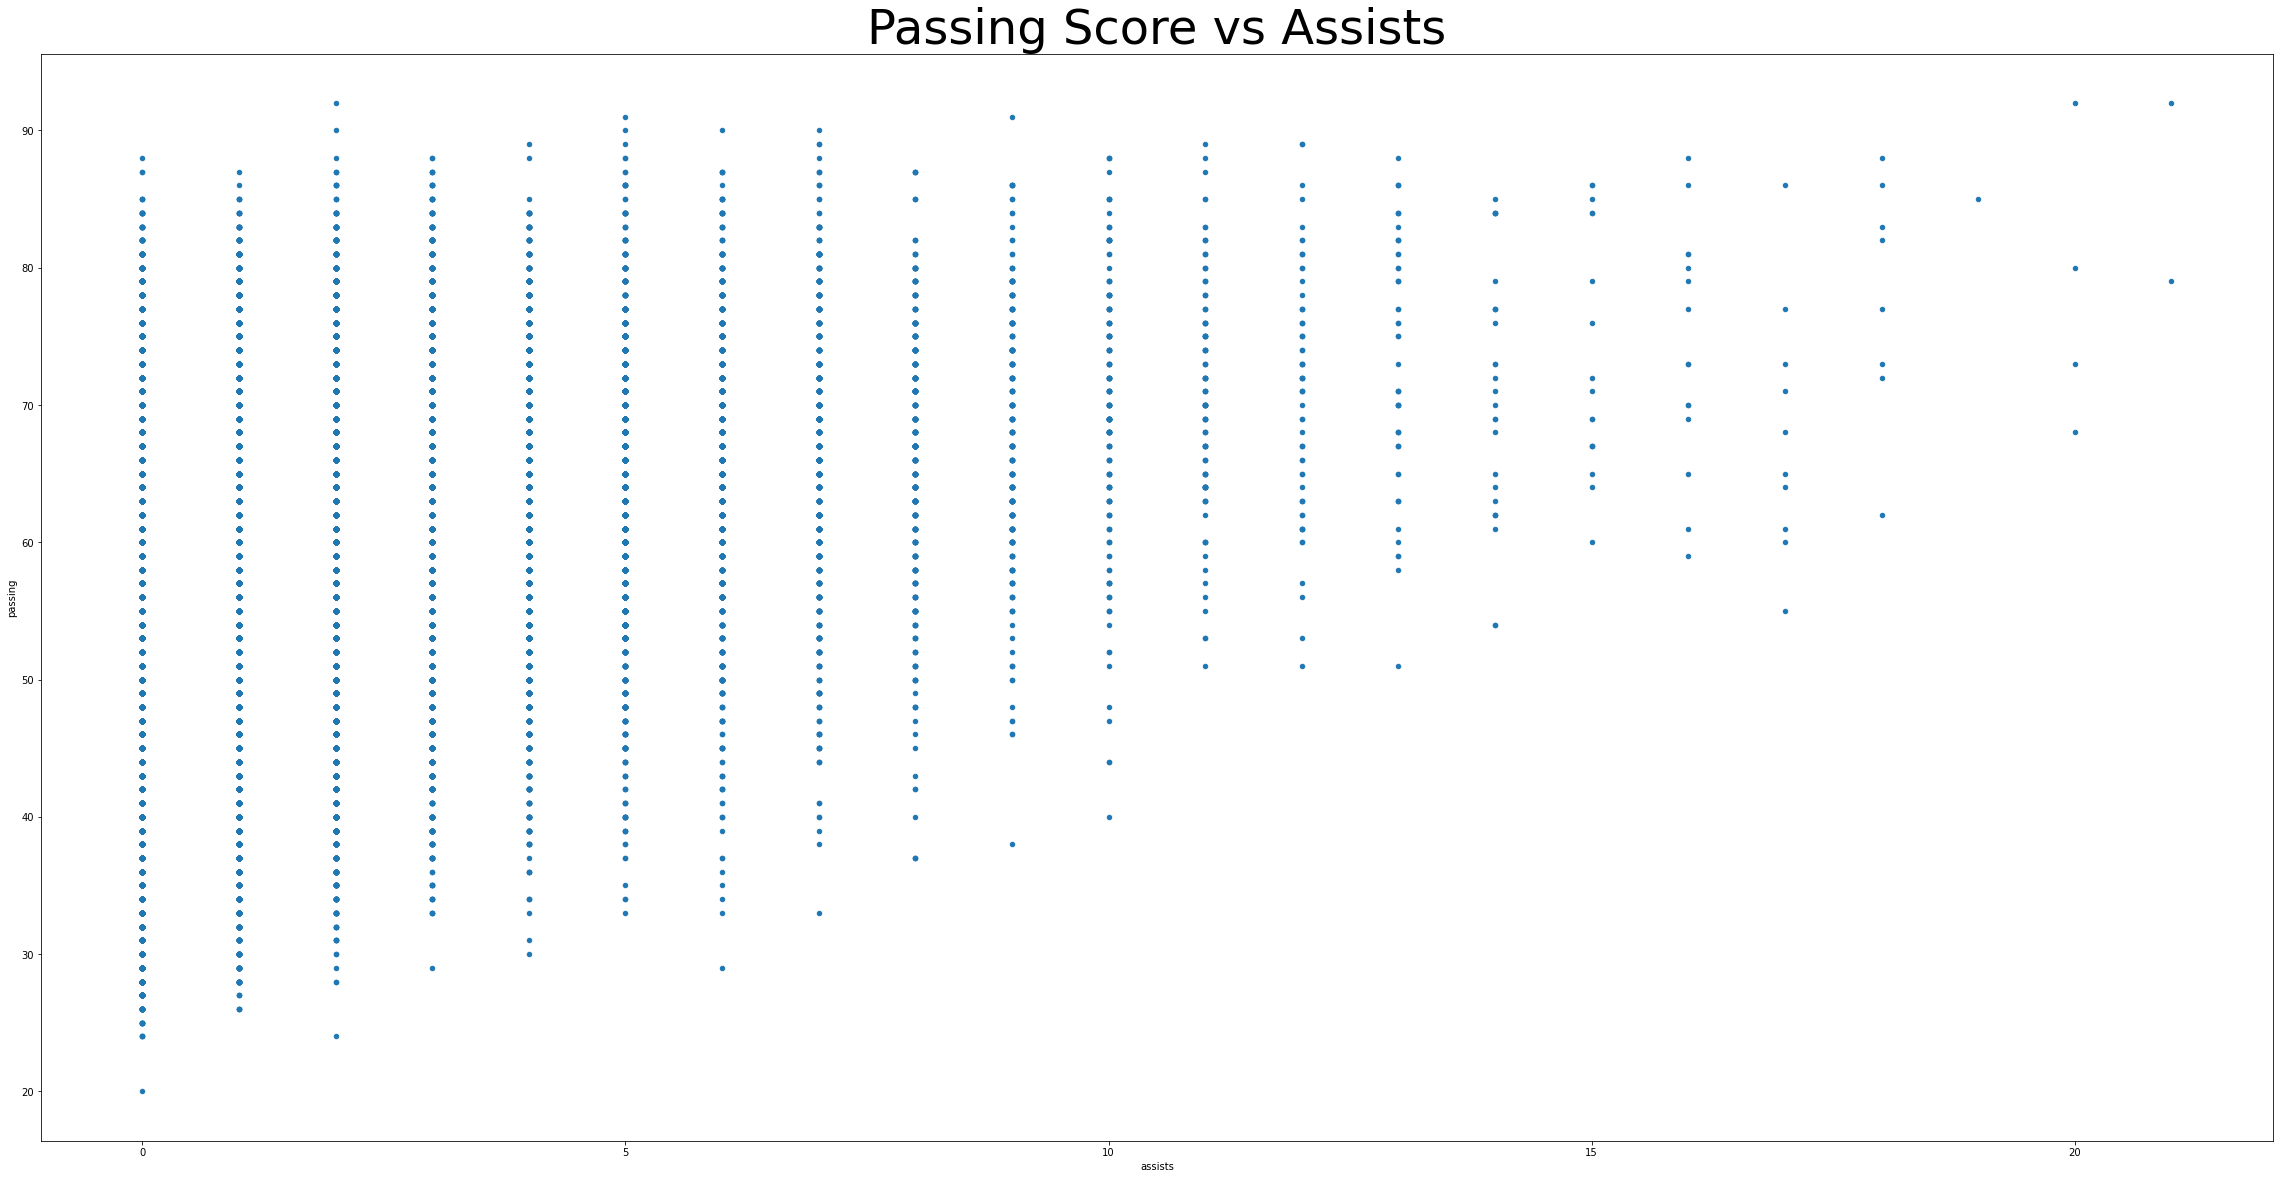

In [ ]:
# We can do the same thing for passing 

assists_df = final_df[["stats_name","assists","minutes","passing"]]


assists_df = assists_df[assists_df.assists != '']
assists_df.assists = assists_df.assists.astype(int)

assists_df.dropna(subset = ["assists","passing"])
ax9 = assists_df.plot.scatter(x = "assists",y = "passing", figsize=(40,20))

ax9.set_title('Passing Score vs Assists',fontdict={'fontsize':48})


/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:5170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


Text(0.5, 1.0, 'Passing Score vs Assists per Minute')

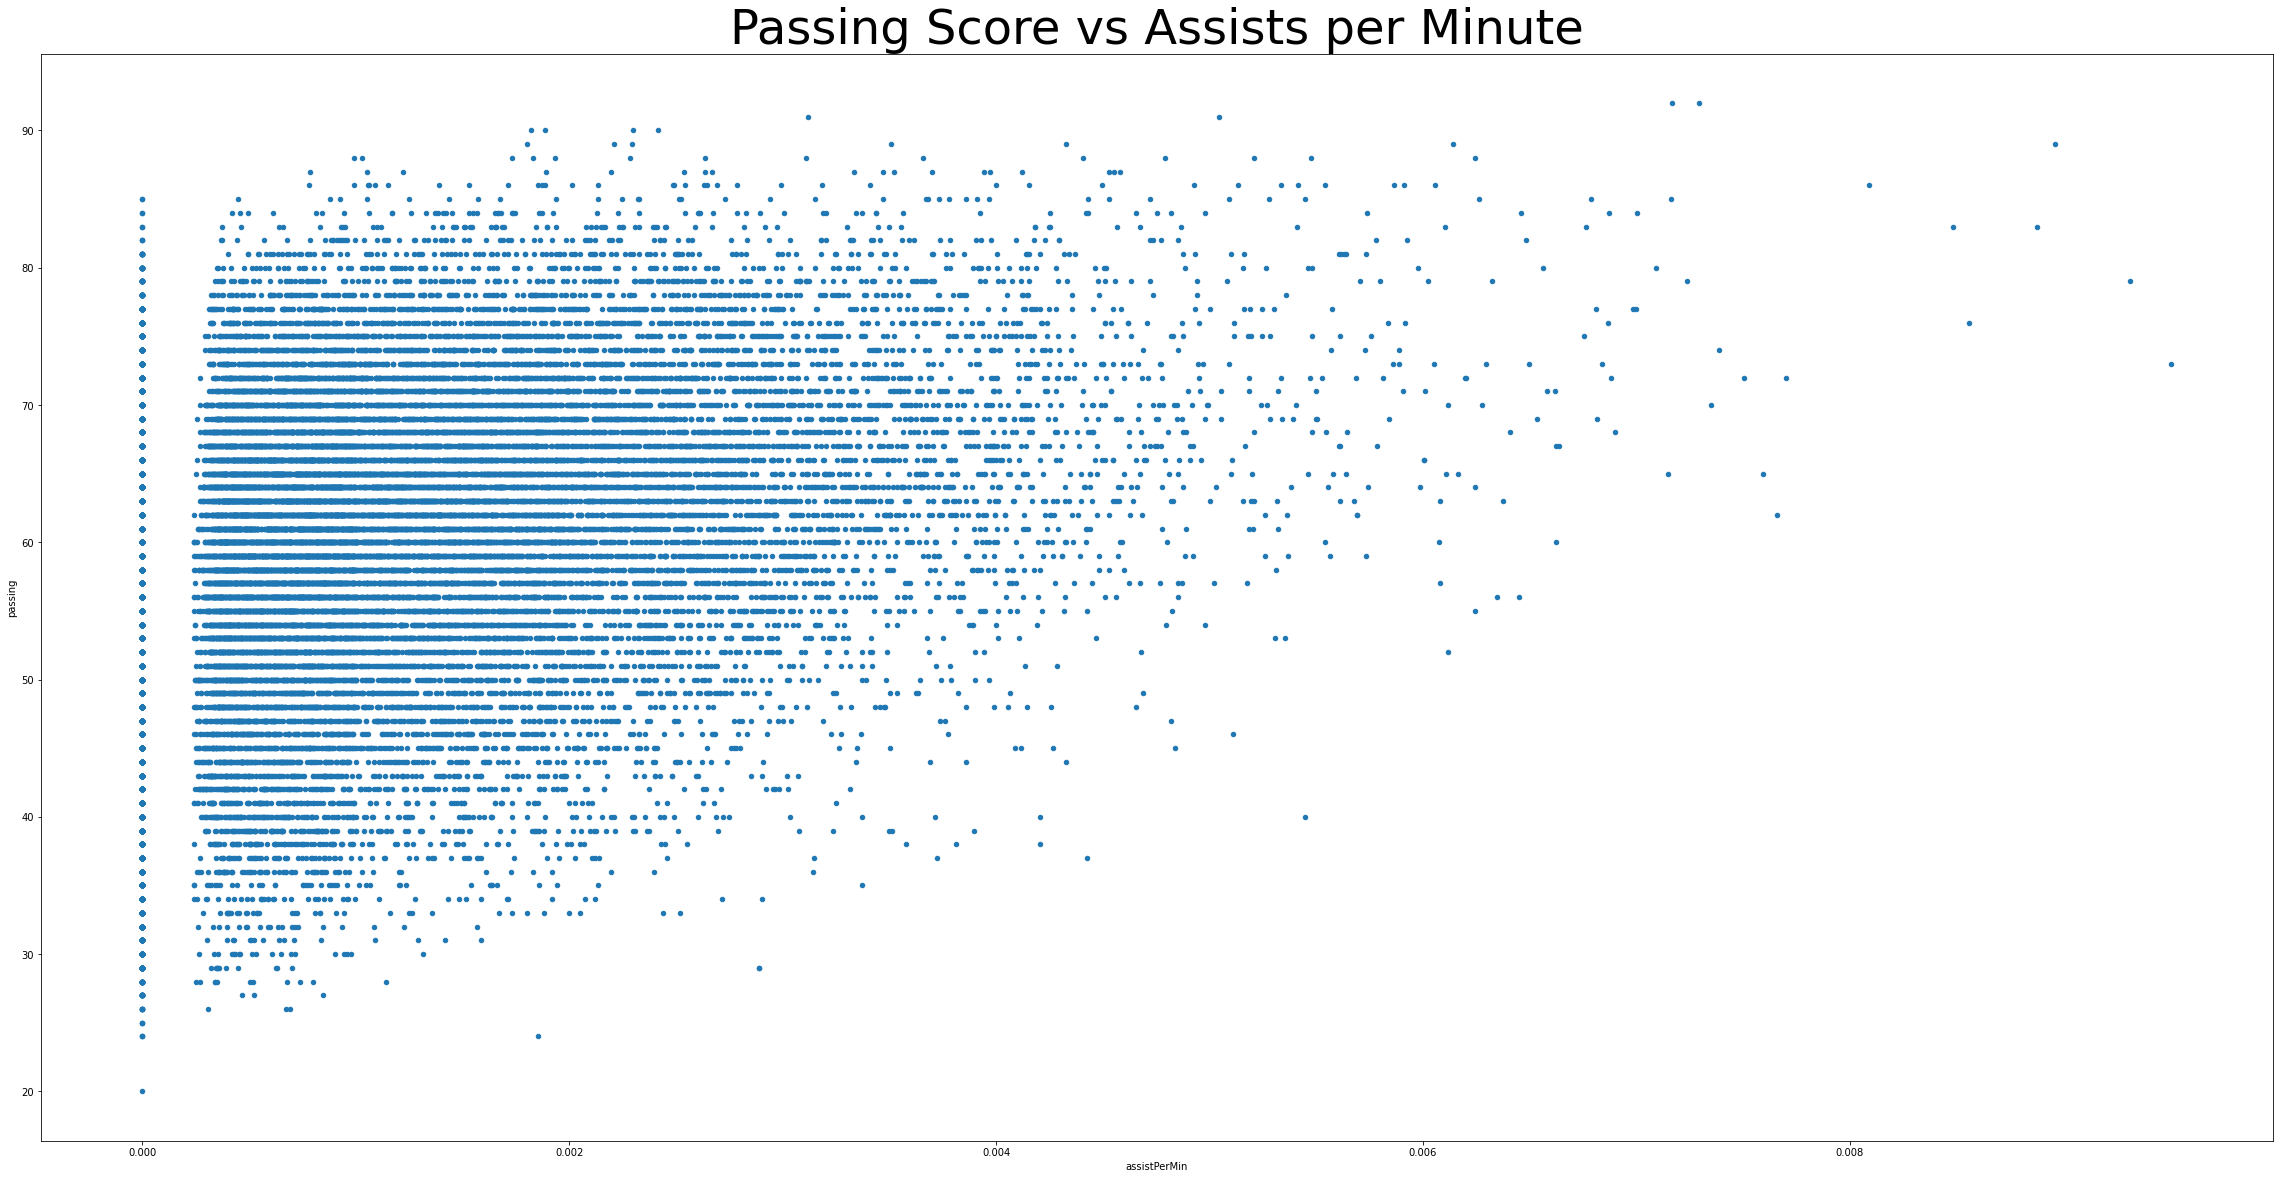

In [ ]:
assists_df["minutes"] = assists_df['minutes'].str.replace('[^\w\s]','')
assists_df = assists_df[assists_df.minutes != '']
assists_df.minutes = assists_df.minutes.astype(int)
new_assists_df = assists_df[assists_df.minutes > 1000]
new_assists_df['assistPerMin'] = new_assists_df.apply(lambda row: row.assists/(row.minutes), axis = 1)

ax10 = new_assists_df.plot.scatter(x = "assistPerMin",y = "passing",figsize=(40,20))

ax10.set_title('Passing Score vs Assists per Minute',fontdict={'fontsize':48})


Looks like a similar trend to shooting ratings...

In [ ]:
assists_df[(assists_df["passing"]>=85) & (assists_df["assists"]<1)]

,stats_name,assists,minutes,passing
17817,Mario Gotze,0,521,85.0
1236,Bastian Schweinsteiger,0,1202,85.0
6151,Rodrigo Fernandes,0,48,87.0
5272,Borja Valero,0,2564,85.0
6150,Joelson Fernandes,0,67,87.0
9082,Cesc Fabregas,0,180,88.0
23166,Pedro Leon,0,425,85.0


In [ ]:
final_df[final_df.stats_name == "Cesc Fabregas"]

,stats_name,kaggle_club,season,age_x,country,competition,league_rank,matches_played,starts,minutes,goals,assists,pk,pk_attempted,yellow_cards,red_cards,second_yellow_cards,fouls,fouls_drawn,offsides,crosses,interceptions,tackles_won,pk_won,pk_conceded,own_goals,min %,complete_matches,subs,unused_sub,team_ppm,team_goals,team_goals_allowed,team_plus-minus,team_plus-minus_90,team_plus-minus_net,height_cm,weight_kg,nationality,overall,...,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_marking,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes,ls,st,rs,lw,lf,cf,rf,rw,lam,cam,ram,lm,lcm,cm,rcm,rm,lwb,ldm,cdm,rdm,rwb,lb,lcb,cb,rcb,rb
6789,Cesc Fabregas,AS Monaco,2020,32,FRA,Ligue 1,9th,18,12,930,0,3,0,0,1,1,0,11,8,1,15,7,9,0,0,0,36.9,2,6,5,1.56,22,21,+1,+0.10,+0.15,179,77,Spain,81,...,45,50,70,88,78,92,64,59,58,6,10,8,15,15,72+3,72+3,72+3,75+3,75+3,75+3,75+3,75+3,78+3,78+3,78+3,75+3,78+3,78+3,78+3,75+3,67+3,69+3,69+3,69+3,67+3,65+3,62+3,62+3,62+3,65+3
5688,Cesc Fabregas,Chelsea,2017,29,ENG,Premier League,1st,29,13,"1,339",5,12,0,0,8,0,0,,,,,,,,,0,4.5,1,0,0,3.00,3,2,+1,+1.00,+0.67,175,74,Spain,86,...,45,50-4,80,91-1,80,92,62,63-1,62,6,10,8,15,15,78+3,78+3,78+3,81+3,81+3,81+3,81+3,81+3,84+3,84+3,84+3,82+3,84+3,84+3,84+3,82+3,73+3,73+3,73+3,73+3,73+3,71+3,65+3,65+3,65+3,71+3
5675,Cesc Fabregas,Chelsea,2018,30,ENG,Premier League,5th,32,25,"2,307",2,4,0,0,5,2,1,25,22,5,63,19,39,0,0,0,67.5,15,7,4,1.72,40,26,+14,+0.55,-0.26,180,77,Spain,86,...,45,50,78,91,80,92,60,63,62,6,10,8,15,15,77+3,77+3,77+3,80+3,81+3,81+3,81+3,80+3,83+3,83+3,83+3,82+3,83+3,83+3,83+3,82+3,73+3,73+3,73+3,73+3,73+3,70+3,65+3,65+3,65+3,70+3
1752,Cesc Fabregas,Chelsea,2015,27,ENG,Premier League,1st,34,33,"2,883",3,18,0,0,11,1,,30,,,,,,,,,84.3,24,1,0,2.26,63,26,+37,+1.16,+0.48,179,85,Spain,84,...,45,61,86-1,92-1,86,NaN,62,66,62,6,10,8,15,15,79+1,79+1,79+1,82+1,81+1,81+1,81+1,82+1,84+1,84+1,84+1,83+1,83+1,83+1,83+1,83+1,74+1,76+1,76+1,76+1,74+1,70+1,67+1,67+1,67+1,70+1
1774,Cesc Fabregas,Chelsea,2016,28,ENG,Premier League,10th,37,33,"2,895",5,7,2,2,5,0,,38,,,,,,,,,84.6,25,4,0,1.32,54,45,+9,+0.28,+0.79,175,74,Spain,87,...,45,61,81-2,93,80,NaN,62,66,62,6,10,8,15,15,78+2,78+2,78+2,81+2,82+2,82+2,82+2,81+2,84+2,84+2,84+2,83+2,85+2,85+2,85+2,83+2,75+2,75+2,75+2,75+2,75+2,72+2,67+2,67+2,67+2,72+2
9082,Cesc Fabregas,Chelsea,2019,31,ENG,Premier League,3rd,6,1,180,0,0,0,0,1,0,0,1,3,0,0,2,9,0,0,0,5.3,1,5,9,1.33,2,2,0,0.00,-0.67,180,77,Spain,84,...,45,50,75,91,78,92,64,59,58,6,10,8,15,15,74+3,74+3,74+3,77+3,78+3,78+3,78+3,77+3,80+3,80+3,80+3,78+3,80+3,80+3,80+3,78+3,68+3,70+3,70+3,70+3,68+3,66+3,62+3,62+3,62+3,66+3


Similar to the shooting rating trend, a player's passing rating is heavily influenced by their past performance. Specifically, players seem to not be penalized too much for having one or two poor seasons. 

Football being one of the most popular sports in the world leads to some of the top athletes becoming incredibly wealthy. We wanted to see how this wealth is distributed amongst players in different overall rating ranges. 

/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:5170: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



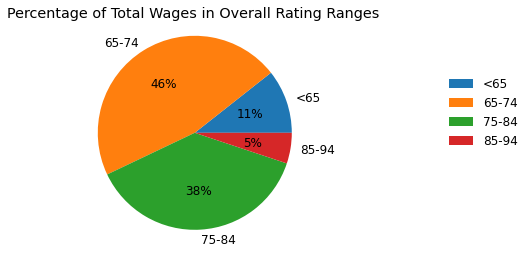

In [ ]:
wage_df = final_df[["stats_name","overall","wage_eur"]]
wage_df.wage_eur = wage_df.wage_eur.astype(float)

wage1 = wage_df[(wage_df["overall"]>=85) & (wage_df["overall"]<95)]
wage2 = wage_df[(wage_df["overall"]>=75) & (wage_df["overall"]<85)]
wage3 = wage_df[(wage_df["overall"]>=65) & (wage_df["overall"]<75)]
wage4 = wage_df[(wage_df["overall"]<65)]
sum1 = wage1.wage_eur.sum()
sum2 = wage2.wage_eur.sum()
sum3 = wage3.wage_eur.sum()
sum4 = wage4.wage_eur.sum()

# Pie chart of what percentage of total wages is made up by players in certain overall rating ranges

import matplotlib.pyplot as plt

fig, ax = plt.subplots()
plt.rcParams['font.sans-serif'] = 'Arial'
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['text.color'] = 'black'
plt.rcParams['axes.labelcolor']= '#909090'
plt.rcParams['xtick.color'] = '#909090'
plt.rcParams['ytick.color'] = '#909090'
plt.rcParams['font.size']=12
labels = '<65', '65-74', '75-84', '85-94'
sizes = [sum1, sum2, sum3, sum4]


percentages = [91, 9]
explode=(0,0,0,0)
ax.pie(sizes, explode=explode, labels=labels 
       , autopct='%1.0f%%', 
       shadow=False, startangle=0,   
       pctdistance=0.6,labeldistance=1.1)
ax.axis('equal')
ax.set_title("Percentage of Total Wages in Overall Rating Ranges") 
ax.legend(frameon=False, bbox_to_anchor=(1.5,0.8))

From the pie chart, most of the money in soccer is dealt to players rated between 65 and 84. The small percentage attributed to players with ratings between 85 and 94 is due to the fact that there are far fewer players in this rating range.

Many times, the success of players is attributed to their genetics. We wanted to investigate this and see if we can find the ideal body type for a soccer player. First, let's look at the overall ratings versus player heights and player weights. 

/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:5170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


Text(0.5, 1.0, 'Overall Score vs Height')

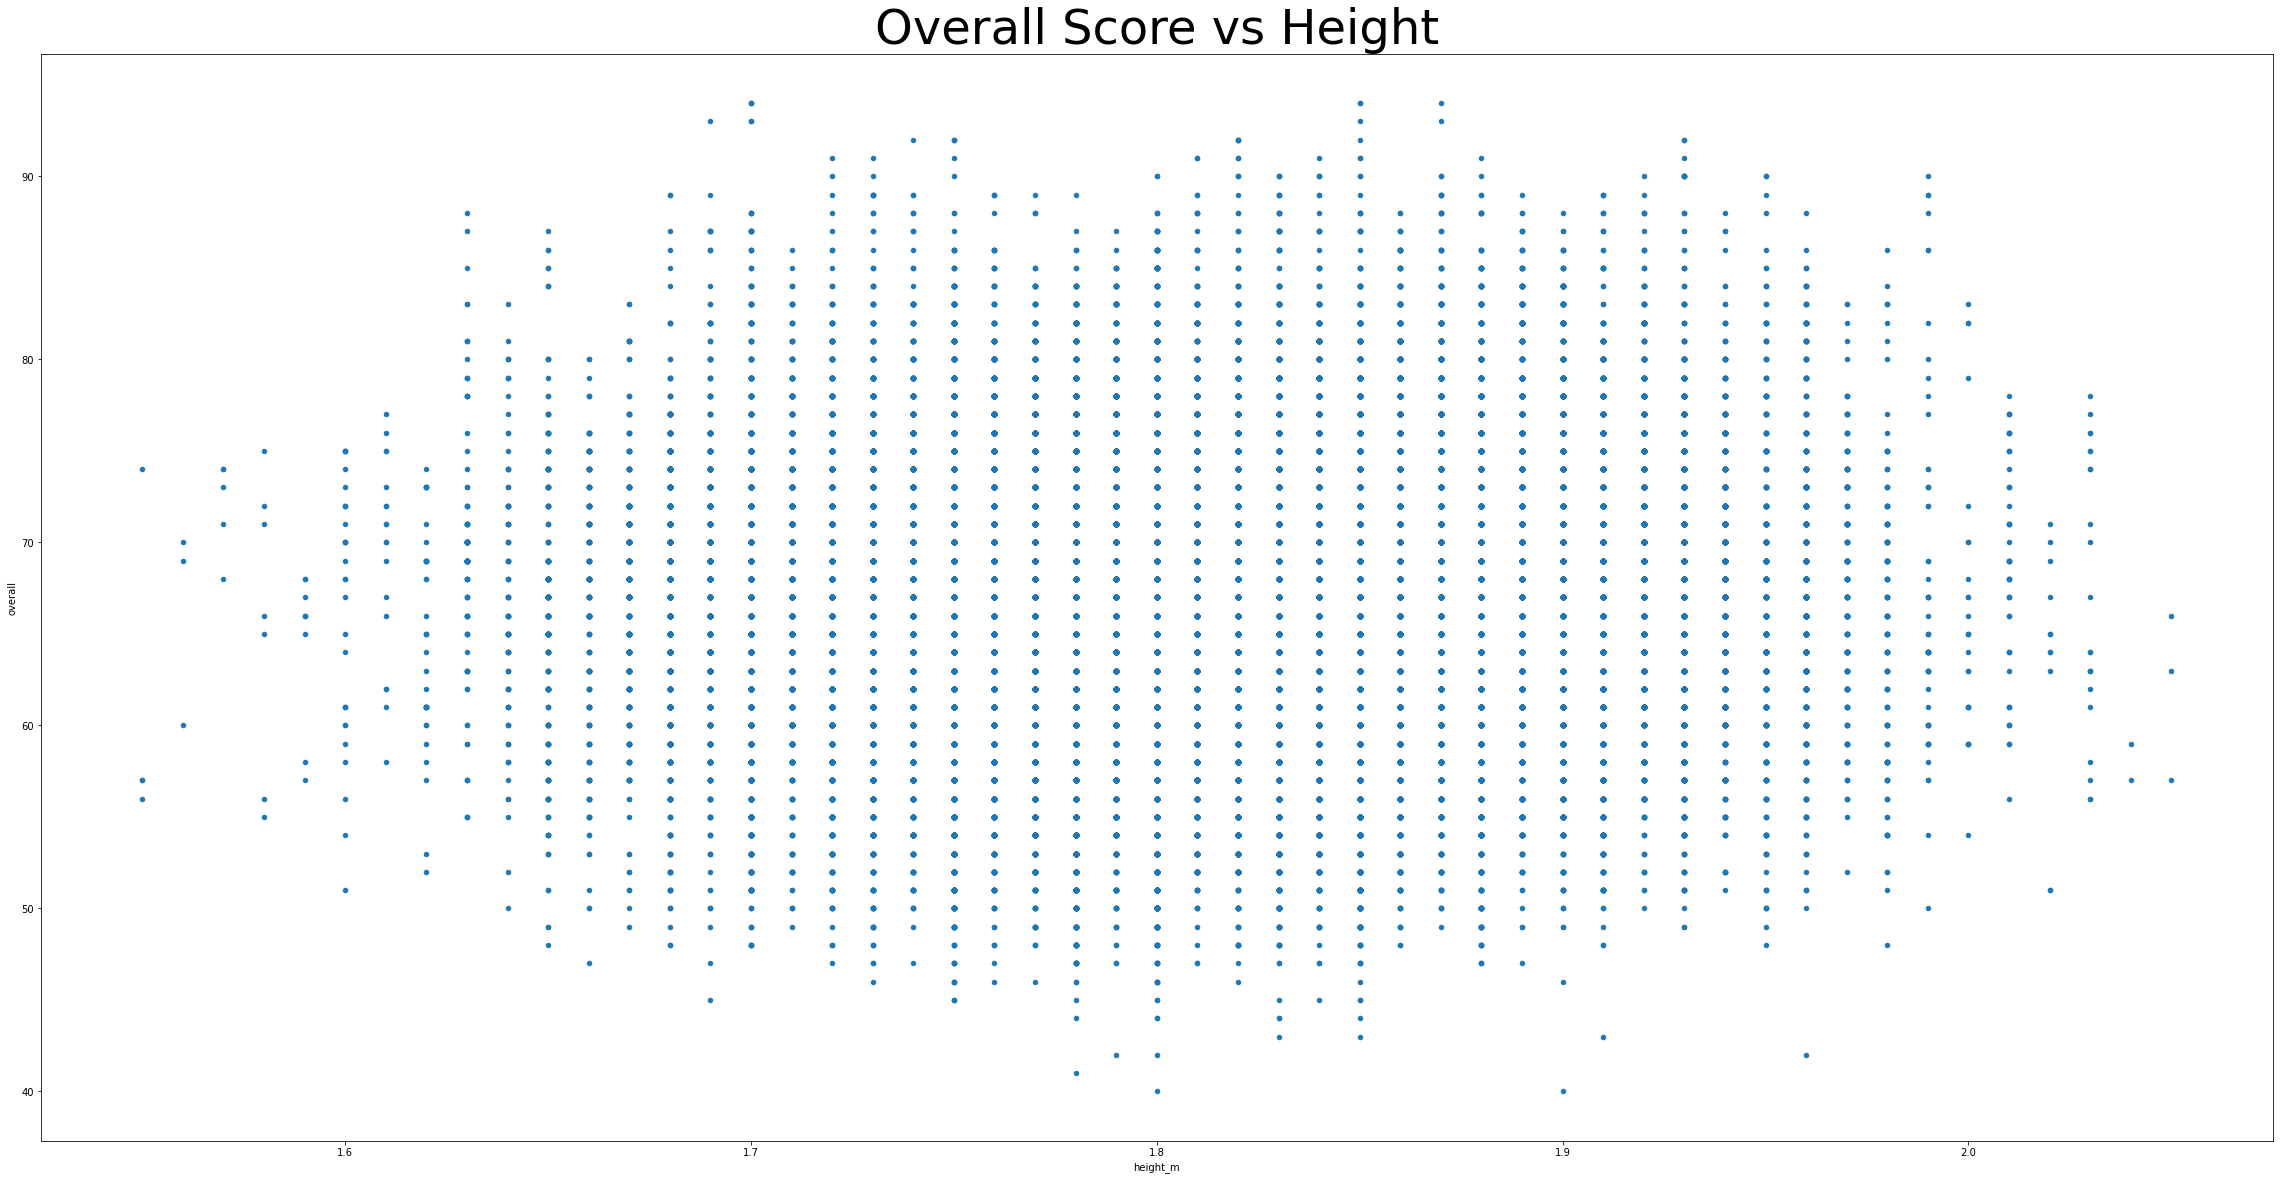

In [ ]:
# EDA 
# Rating vs. Height
body_df = final_df[["stats_name","height_cm","weight_kg","overall","shooting","passing"]]
# Can we find the ideal body type of a Soccer Player
body_df.height_cm = body_df.height_cm/100
body_df = body_df.rename(columns = {"height_cm": "height_m"})
# Let's first look at plots of Overall Rating vs. Height and Overall Rating vs. Weight
ax11 = body_df.plot.scatter(x = "height_m", y = "overall", figsize=(40,20))
ax11.set_title('Overall Score vs Height',fontdict={'fontsize':48})

We see that most soccer players are between 1.6 meters and 2.2 meters. Contrary to a sport like basketball, we do not see any positive correlation between player ability and height. This would most likely differ if we separated the data based on player position. For example, goalkeepers would greatly benefit from increased height and we would most likely see a positive correlation between height and overall ratings for these players. 

Text(0.5, 1.0, 'Overall Score vs Weight')

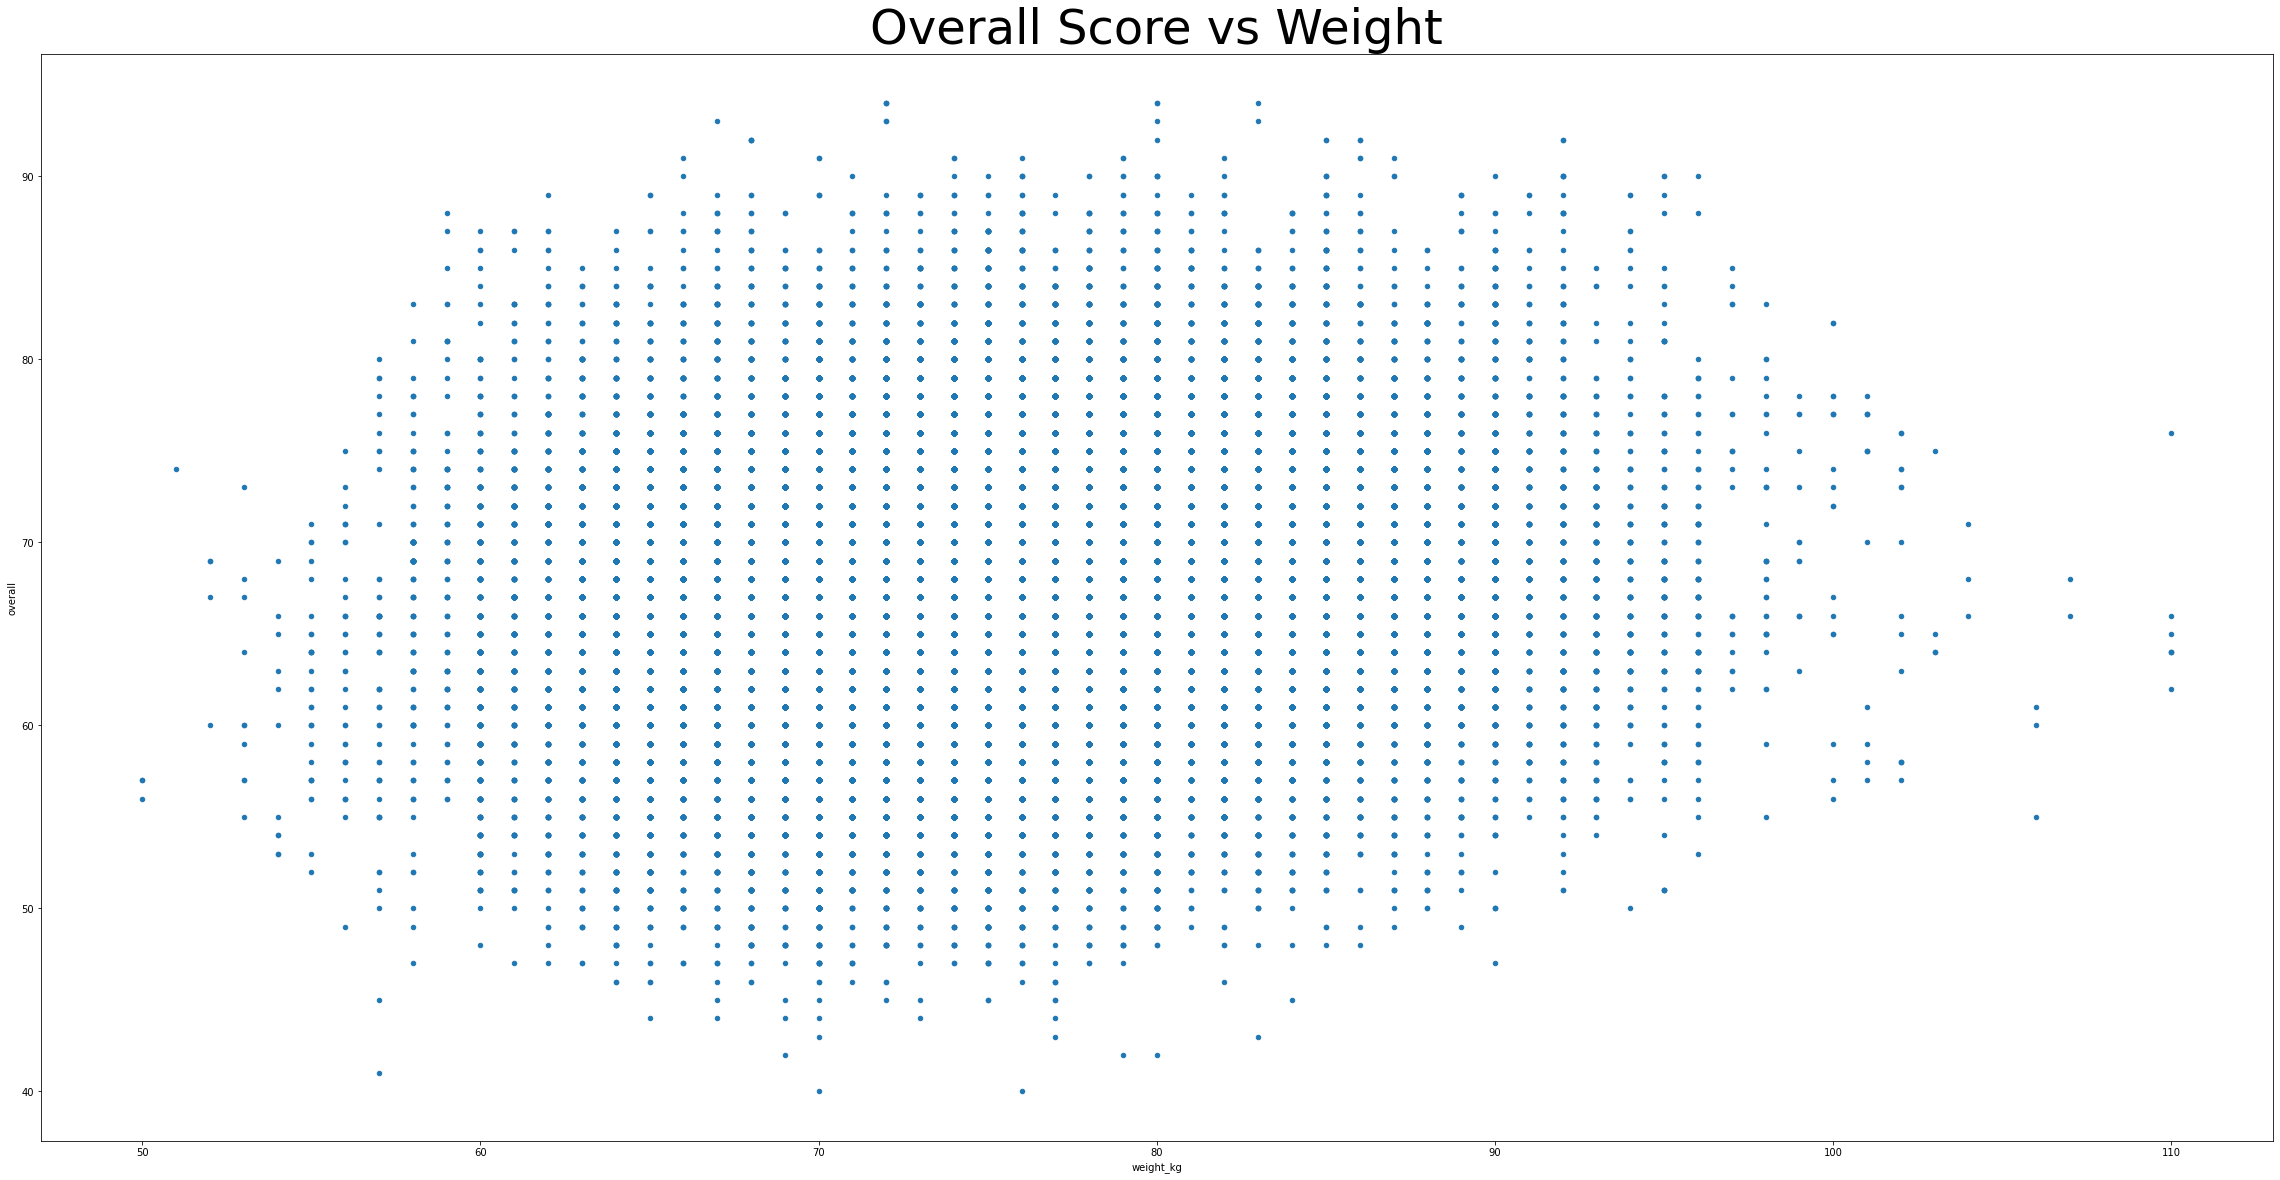

In [ ]:
# Rating vs. Weight
ax12 = body_df.plot.scatter(x = "weight_kg", y = "overall",figsize=(40,20))
ax12.set_title('Overall Score vs Weight',fontdict={'fontsize':48})

We see that the majority of soccer players are between 60 and 100 kg. Although there is no clear trend, we can see that players who fall near the extremes of this range tend to have lower ratings. 

Next, let's look at overall ratings vs. Body Mass Index (BMI). We calcuated BMI using a ratio between mass (kg) and height (m)

Text(0.5, 1.0, 'Overall Score vs BMI')

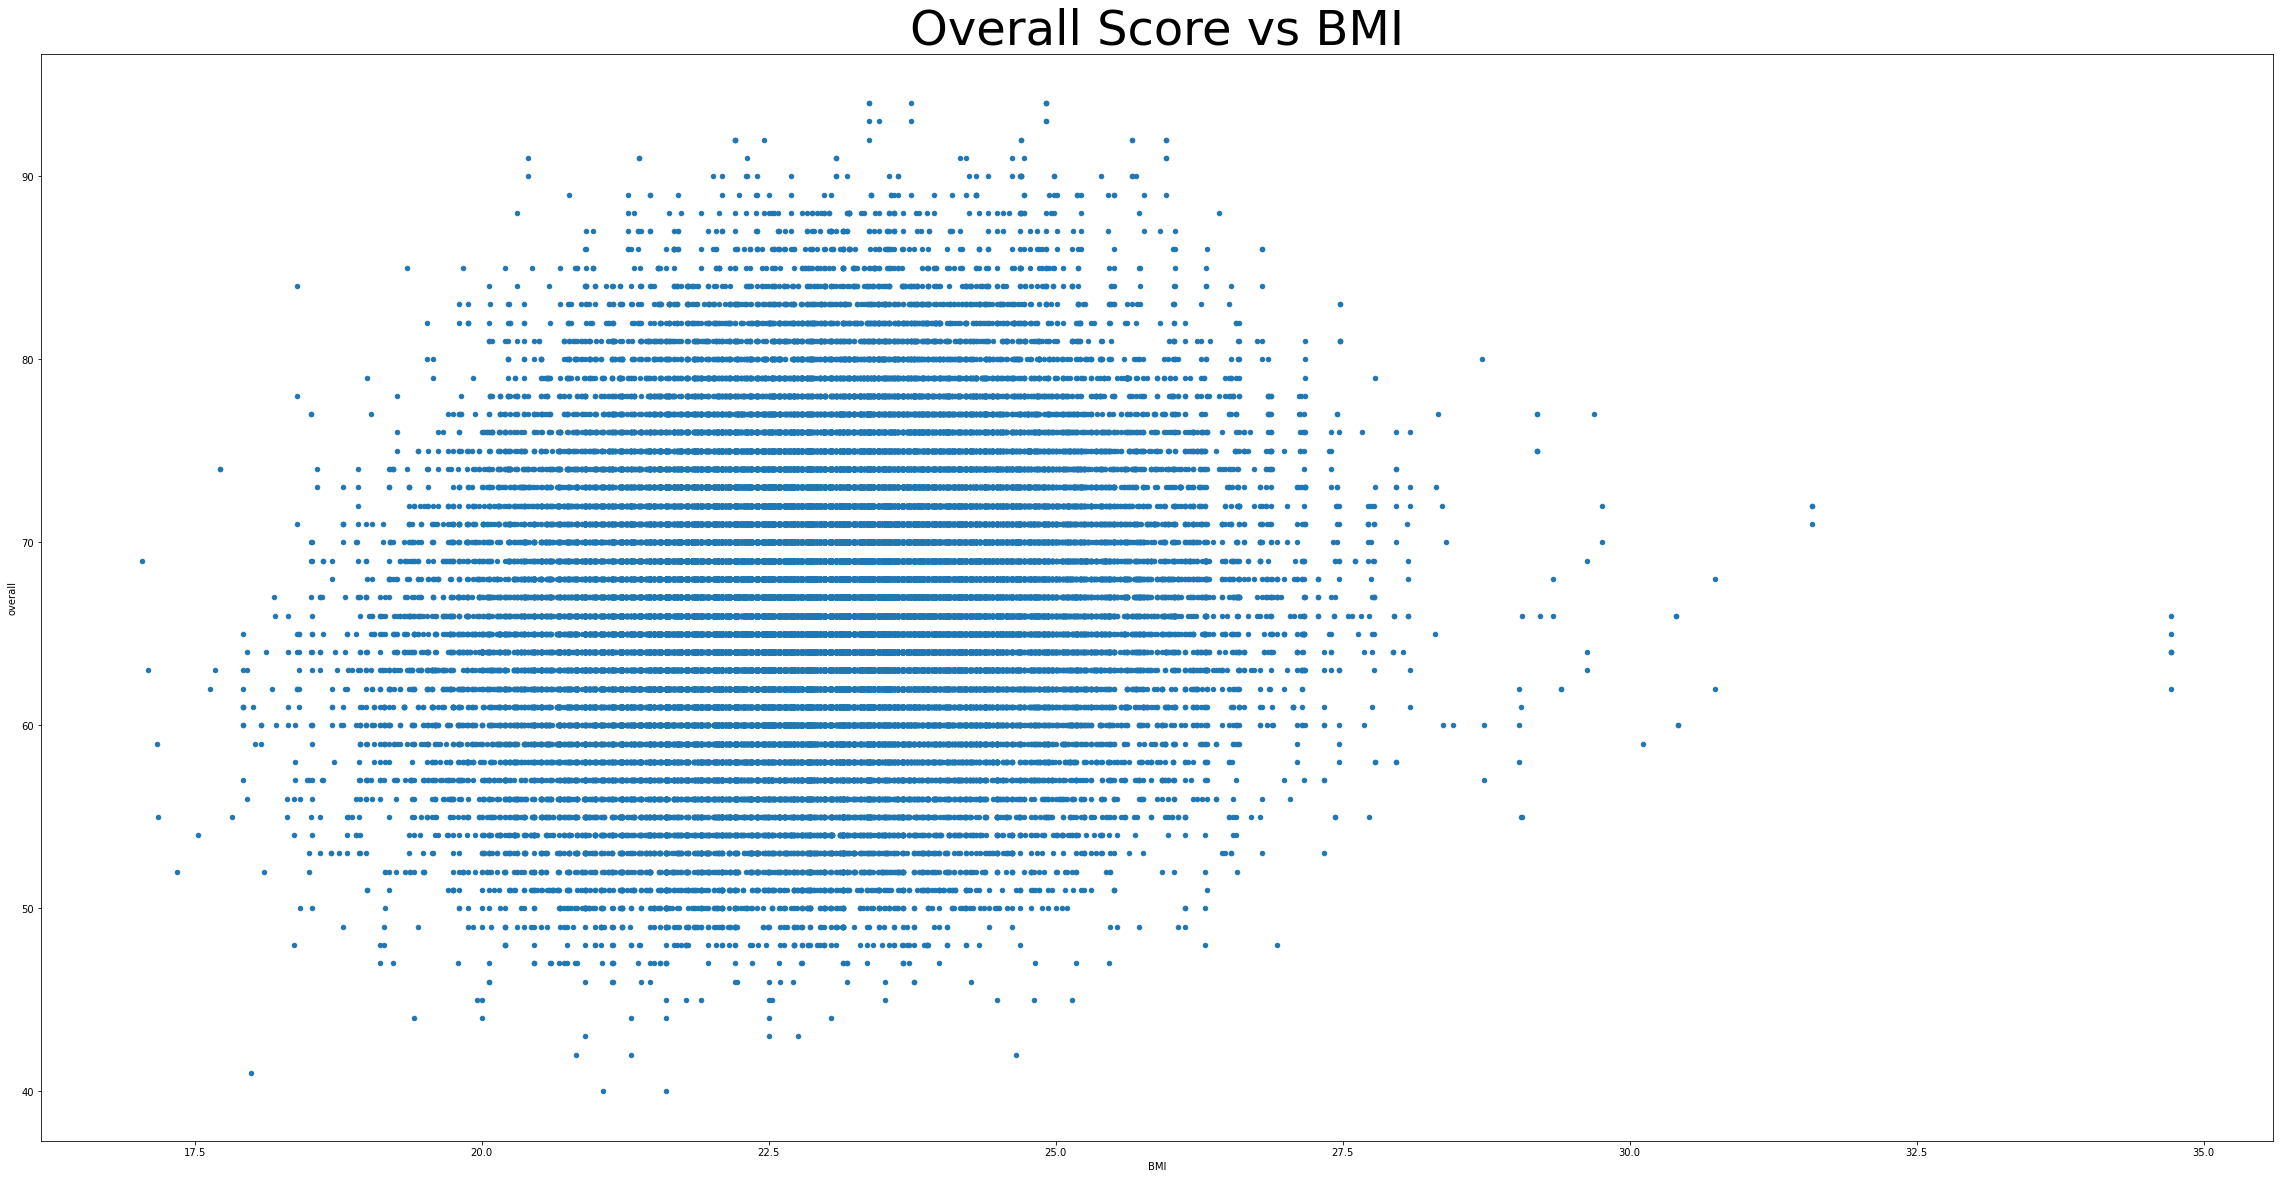

In [ ]:
# BMI? (mass[kg]/height[m])

body_df['BMI'] = body_df.apply(lambda row: row.weight_kg/((row.height_m)**2), axis = 1)
ax13 = body_df.plot.scatter(x = "BMI", y = "overall",figsize=(40,20))
ax13.set_title('Overall Score vs BMI',fontdict={'fontsize':48})

We see that the majority of soccer players have a BMI between 18 and 27. Again, we would probably see more of a trend if we segmented the data based on player position.

## Getting Data Into the Desired Format


Our final dataframe contains many categorical variables ("club team", "country", "League", etc.), so we need to create dummy variables for them. 
Currently, all of the numeric data are cast as strings and need to be convered to integers and floats. In addition, we want to get rid of rows with missing data. A couple of key decisions within the data transformation that we wanted to point out were: 1. We needed to use n-1 dummy variables for the number of categories within a variable in order to reduce collinearity as much as possible since if all the variables are 0, it will represent the nth variable automatically. 2. We also made sure to drop any values that the video game FIFA had already calculated since that would be utilizing inherent FIFA calculations within our model which would be defeating the purpose.

In [ ]:
import pandas as pd
features = final_df.copy()


# Dropping all ratings that FIFA created
features.drop(features.iloc[:, 45:133], inplace = True, axis = 1) 
features.drop(columns="stats_name", inplace=True)
features.drop(columns="potential", inplace=True)

# Creating Dummy Variables for all Categorical Data 
dummies_kaggle_clubs = pd.get_dummies(features['kaggle_club'],drop_first=True).rename(columns=lambda x: 'Category_' + str(x))
dummies_country = pd.get_dummies(features['country'],drop_first=True).rename(columns=lambda x: 'Category_' + str(x))
dummies_competition = pd.get_dummies(features['competition'],drop_first=True).rename(columns=lambda x: 'Category_' + str(x))
dummies_nationality = pd.get_dummies(features['nationality'],drop_first=True).rename(columns=lambda x: 'Category_' + str(x))
dummies_player_positions = pd.get_dummies(features['player_positions'],drop_first=True).rename(columns=lambda x: 'Category_' + str(x))
dummies_preferred_foot = pd.get_dummies(features['preferred_foot'],drop_first=True).rename(columns=lambda x: 'Category_' + str(x))
dummies_seasons = pd.get_dummies(features['season'],drop_first=True).rename(columns=lambda x: 'Category_' + str(x))


features = pd.concat([features,dummies_seasons,dummies_kaggle_clubs,dummies_country,dummies_competition,dummies_nationality,dummies_player_positions,dummies_preferred_foot], axis=1)
features.drop(['kaggle_club'], inplace=True, axis=1)
features.drop(['country'], inplace=True, axis=1)
features.drop(['competition'], inplace=True, axis=1)
features.drop(['nationality'], inplace=True, axis=1)
features.drop(['player_positions'], inplace=True, axis=1)
features.drop(['preferred_foot'], inplace=True, axis=1)
features.drop(['second_yellow_cards'], inplace=True, axis=1)
features.drop(['pk_attempted'], inplace=True, axis=1)
features.drop(['pk_won'], inplace=True, axis=1)
features.drop(['pk_conceded'], inplace=True, axis=1)
features.drop(['own_goals'], inplace=True, axis=1)
features.drop(['season'], inplace=True, axis=1)




To ensure that our model was robust, we deleted rows if they had any columns with missing data. In addition, most of the colums were string types and we needed to convert them to ints and floats. 

In [ ]:
# Drop any rows with missing data
features = features.dropna()
features["minutes"] = features['minutes'].str.replace('[^\w\s]','')

features = features[features.minutes != ""]
features = features[features.assists != ""]
features = features[features.yellow_cards != ""]
features = features[features.red_cards != ""]
features = features[features.goals != ""]
features = features[features.pk != ""]
features = features[features.fouls != ""] # lost a lot ~15,000
features = features[features.fouls_drawn != ""] # lost ~10,000
features = features[features.offsides != ""]
features = features[features.crosses != ""]
features = features[features.interceptions != ""]
features = features[features.tackles_won != ""]
features = features[features.complete_matches != ""]
features = features[features.subs != ""]
features = features[features.unused_sub != ""]
features = features[features.team_ppm != ""]
features = features[features.team_goals != ""]
features = features[features.team_goals_allowed != ""]
features = features.rename(columns = {"team_plus-minus":"team_plus_minus", "team_plus-minus_90":"team_plus_minus_90", "team_plus-minus_net":"team_plus_minus_net"})
features = features[features.team_plus_minus != ""]
features = features[features.team_plus_minus_90 != ""]
features = features[features.team_plus_minus_net != ""]
features = features[features.starts != ""]
features = features[features.matches_played != ""]
features = features[features.league_rank!= ""]

features['league_rank'] = features['league_rank'].str.extract('(\d+)', expand=False)


# Converting all the scraped data from String to Integers
features.minutes = features.minutes.astype(int)
features.assists = features.assists.astype(int)
features.yellow_cards = features.yellow_cards.astype(int)
features.red_cards = features.red_cards.astype(int)
features.goals = features.goals.astype(int)
features.pk = features.pk.astype(int)
features.fouls = features.fouls.astype(int)
features.fouls_drawn = features.fouls_drawn.astype(int)
features.offsides = features.offsides.astype(int)
features.crosses = features.crosses.astype(int)
features.interceptions = features.interceptions.astype(int)
features.tackles_won = features.tackles_won.astype(int)
features.complete_matches = features.complete_matches.astype(int)
features.subs = features.subs.astype(int)
features.unused_sub = features.unused_sub.astype(int)
features.team_ppm = features.team_ppm.astype(float)
features.team_goals = features.team_goals.astype(int)
features.team_goals_allowed = features.team_goals_allowed.astype(int)
features.team_plus_minus = features.team_plus_minus.astype(int)
features.team_plus_minus_90 = features.team_plus_minus_90.astype(float)
features.team_plus_minus_net = features.team_plus_minus_net.astype(float)
features.matches_played = features.matches_played.astype(int)
features.starts = features.starts.astype(int)
features.league_rank = features.league_rank.astype(int)

features

# Modeling

Now that our data is in the right format, we can start modeling. We are going to start with linear regression and then add regularization with the Ridge and Lasso methods. 

The first step that we took when creating our model was to split the data first into two dataframes: features and labels. The features included the cleaned values of all the variables we wanted to act as predictors within our model, and the label was a dataframe of the values we wanted to predict, which was the Overall Score assigned by the FIFA video game. We decided to utilize the same training to testing split as the class homework assignments, which was 80% to 20%. This seemed to give us adequate data to be able to train our data on since we dropped some rows to account for data attrition in the previous step. 

In [ ]:
# Splitting up data into label and features
features2 = features.copy()

label = features2["overall"]
features = features.drop(columns="overall")

### Linear Regression

In [ ]:
# Splitting up data into training and testing data
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(features, label, test_size=.2, train_size=.8)

# Linear Regression 
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

reg = LinearRegression().fit(x_train,y_train)
y_pred = reg.predict(x_test)
mse_test = mean_squared_error(y_test,y_pred)
reg.score(x_test,y_test)

0.7881764569157005

After running the simple linear regression model, we were surprised to see that the R^2 value after comparing the predicted test values versus the actual test values was roughly 79%, and we were excited to see how this could be improved by utilizing other methods to create a fit. However, we were wary of the possibility of overfitting, especially given the abundance of predictor variables that we had after creating many dummy variables. 

To overcome this, we added regularization given the three methods we learned in class: Lasso, Ridge, and Elastic Net. 

In [ ]:
# Add Regularization to avoid overfitting
# Compute predictions using each of the models
# Lasso
from sklearn import linear_model
lr1 = linear_model.Lasso(alpha = 0.5)

lasso = lr1.fit(x_train,y_train)
y_pred = lasso.predict(x_test)
mse_test_lasso = mean_squared_error(y_test,y_pred)

In [ ]:
# Ridge
lr2 = linear_model.Ridge(alpha = 0.2,normalize = True)

ridge = lr2.fit(x_train,y_train)
y_pred = ridge.predict(x_test)
mse_test_ridge = mean_squared_error(y_test,y_pred)
lr2.score(x_test,y_test)

0.7808282265864492

In [ ]:
# Elastic Net
lr3 = linear_model.ElasticNet(alpha = 0.3)

elasticNet = lr3.fit(x_train,y_train)
y_pred = elasticNet.predict(x_test)
mse_test_elastic = mean_squared_error(y_test,y_pred)
lr3.score(x_test,y_test)

0.5979528348374622

After running the three regularization methods, we saw that the Ridge Regression method gave us a score of roughly 79% again which was good to see. However, ElasticNet and the Lasso approaches both yielded us with much lower scores.

### Principal Component Analysis

We then proceeded to conduct principal component analysis in order to reduce the dimensionality of our model since we are aware that it is usually better to try to reduce the number of features in a model as much possible to reduce the possibility of overfitting and other issues.

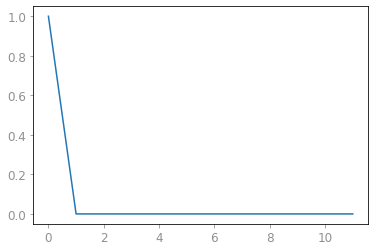

In [ ]:
import numpy as np
from sklearn.decomposition import PCA
# Your code goes here
pca = PCA(n_components=12)
pca.fit(x_train)

plt.plot(pca.explained_variance_ratio_)

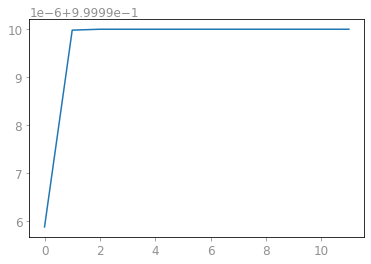

In [ ]:
x = np.cumsum(pca.explained_variance_ratio_)
plt.plot(x)

After conducting PCA, we can see that it seems like we have one feature that accounts for all of the variation in our labels. However, for the purpose of analyzing more than just one feature, we decided to include more than one component. We decided that we wanted to keep only 10 components moving forward, so we transformed our feature dataframes accordingly. 

In [ ]:
# Your code goes here
pca = PCA(n_components=10)
pca_x_train = pca.fit_transform(x_train)
pca_x_test = pca.transform(x_test)

### Grid Search

We knew that the next model that we wanted to try was the Random Forest Regression Model. We decided to conduct a Grid Search to find the optimal parameters to ensure our Random Forest Model worked properly. Specifically, we decided to test through various max_depth options, but we decided not to toggle the n_estimators in the interest of time since this is a very time intensive operation.

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
# Your code goes here
# Only tune the max depth of the trees in the RF hyperparameter.

param_grid = {
    'max_depth':[50,100,150,200], 
    'n_estimators':[140]
    }

rf = RandomForestRegressor()
grd = GridSearchCV(rf,param_grid)
grd.fit(pca_x_train,y_train)
#ypred = fit.predict(x_test)
#mse = mean_squared_error(y_test, y_pred)
#mse



GridSearchCV(cv=None, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='deprecated', n

In [ ]:
grd.best_estimator_

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=100, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=140, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

After running this Grid Search, we see that the optimal max_depth out of the options we tested was 200, so we will be utilizing this as the max_depth parameter in the Random Forest and Gradient Boosted Regressions.

### Random Forest Regression

In [ ]:
from sklearn.ensemble import RandomForestRegressor

# Set n_estimators = 140
regr = RandomForestRegressor(n_estimators = 140, max_depth=200)
z = regr.fit(pca_x_train,y_train)

y_pred = z.predict(pca_x_test)

mse_test_rand = mean_squared_error(y_test, y_pred)
mse_test_rand

# n = 10
# max_depth = 200 -> 1.1742361576
# max_depth = 125 -> 1.171548745390249
# max_depth = 80 -> 1.1742940526196202
# max_depth = 300 -> 1.1796413715357679

# n = 15
# max_depth = 200 -> 3.226648099005517

3.333419729153437

In [ ]:
regr.score(pca_x_test,y_test)

0.9245059446159657

After running the Random Forest Regression, we were very pleased to see that the score of this model was a whopping 92.5%! Even after utilizing the new training set with the reduced dimensions, we were able to get a model with much higher predictive power than the linear model we had calculated previously.

After creating such a powerful model, we were very curious to see what variables were the most significant in helping predict the overall score, so we decided to graph the top 10 features in the random forest model.

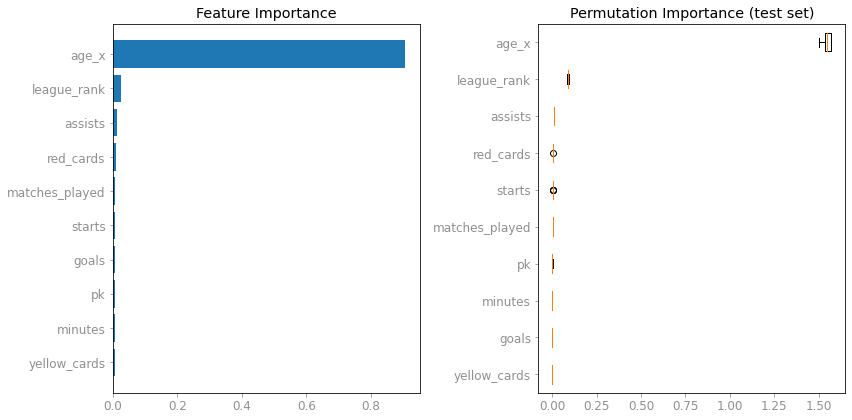

In [ ]:
from sklearn.inspection import permutation_importance
feature_importance = regr.feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
fig = plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, np.array(features.columns)[sorted_idx])
plt.title('Feature Importance')

result = permutation_importance(regr, pca_x_test, y_test, n_repeats=10,
                                random_state=42, n_jobs=2)
sorted_idx = result.importances_mean.argsort()
plt.subplot(1, 2, 2)
plt.boxplot(result.importances[sorted_idx].T,
            vert=False, labels=np.array(features.columns)[sorted_idx])
plt.title("Permutation Importance (test set)")
fig.tight_layout()
plt.show()

Our results were extremely shocking: the overwhelmingly highest feature which was affecting the FIFA overall score was the age of the player according to our model.

### Gradient Boosted Regression

In [ ]:
# Gradient Boosted Regression
from sklearn.ensemble import GradientBoostingRegressor

params = {'n_estimators' : 140, 'max_depth' : 200, 'learning_rate': 1, 'criterion': 'mse'}
gradient_boosting_regressor_model = GradientBoostingRegressor(**params)
grad = gradient_boosting_regressor_model.fit(pca_x_train,y_train)

In [ ]:
grad.score(pca_x_test,y_test)

0.8483746692566756

After conducting the gradient boosted regression, we were slightly disappointed to see that it actually performed slightly worse than the random forest regression model. We decided to again see the feature importance of the variables although we expected them to be the same as the random forest regression.

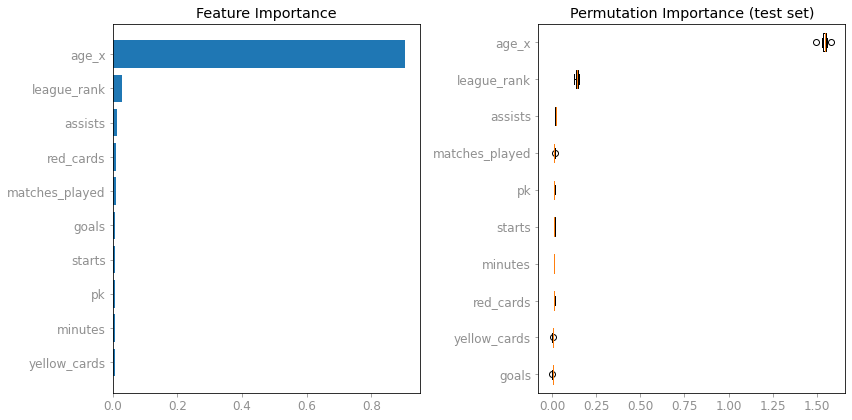

In [ ]:
from sklearn.inspection import permutation_importance
feature_importance = grad.feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
fig = plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, np.array(features.columns)[sorted_idx])
plt.title('Feature Importance')

result = permutation_importance(grad, pca_x_test, y_test, n_repeats=10,
                                random_state=42, n_jobs=2)
sorted_idx = result.importances_mean.argsort()
plt.subplot(1, 2, 2)
plt.boxplot(result.importances[sorted_idx].T,
            vert=False, labels=np.array(features.columns)[sorted_idx])
plt.title("Permutation Importance (test set)")
fig.tight_layout()
plt.show()

Our prediction ended up being correct that the feature importance of the gradient boosted model was very similar to, if not the exact same as, the random forest model. This continued to baffle us, but we were not surprised that the GBM and the RF models had the same feature importance, because they are both models utilizing decision trees and have similarities in the way that they work. 

We wanted to look a little deeper into our results at this point and decided to visualize the overall ratings versus the age of the player to see if there were any obvious trends. 

Text(0.5, 1.0, 'Overall Score vs Age')

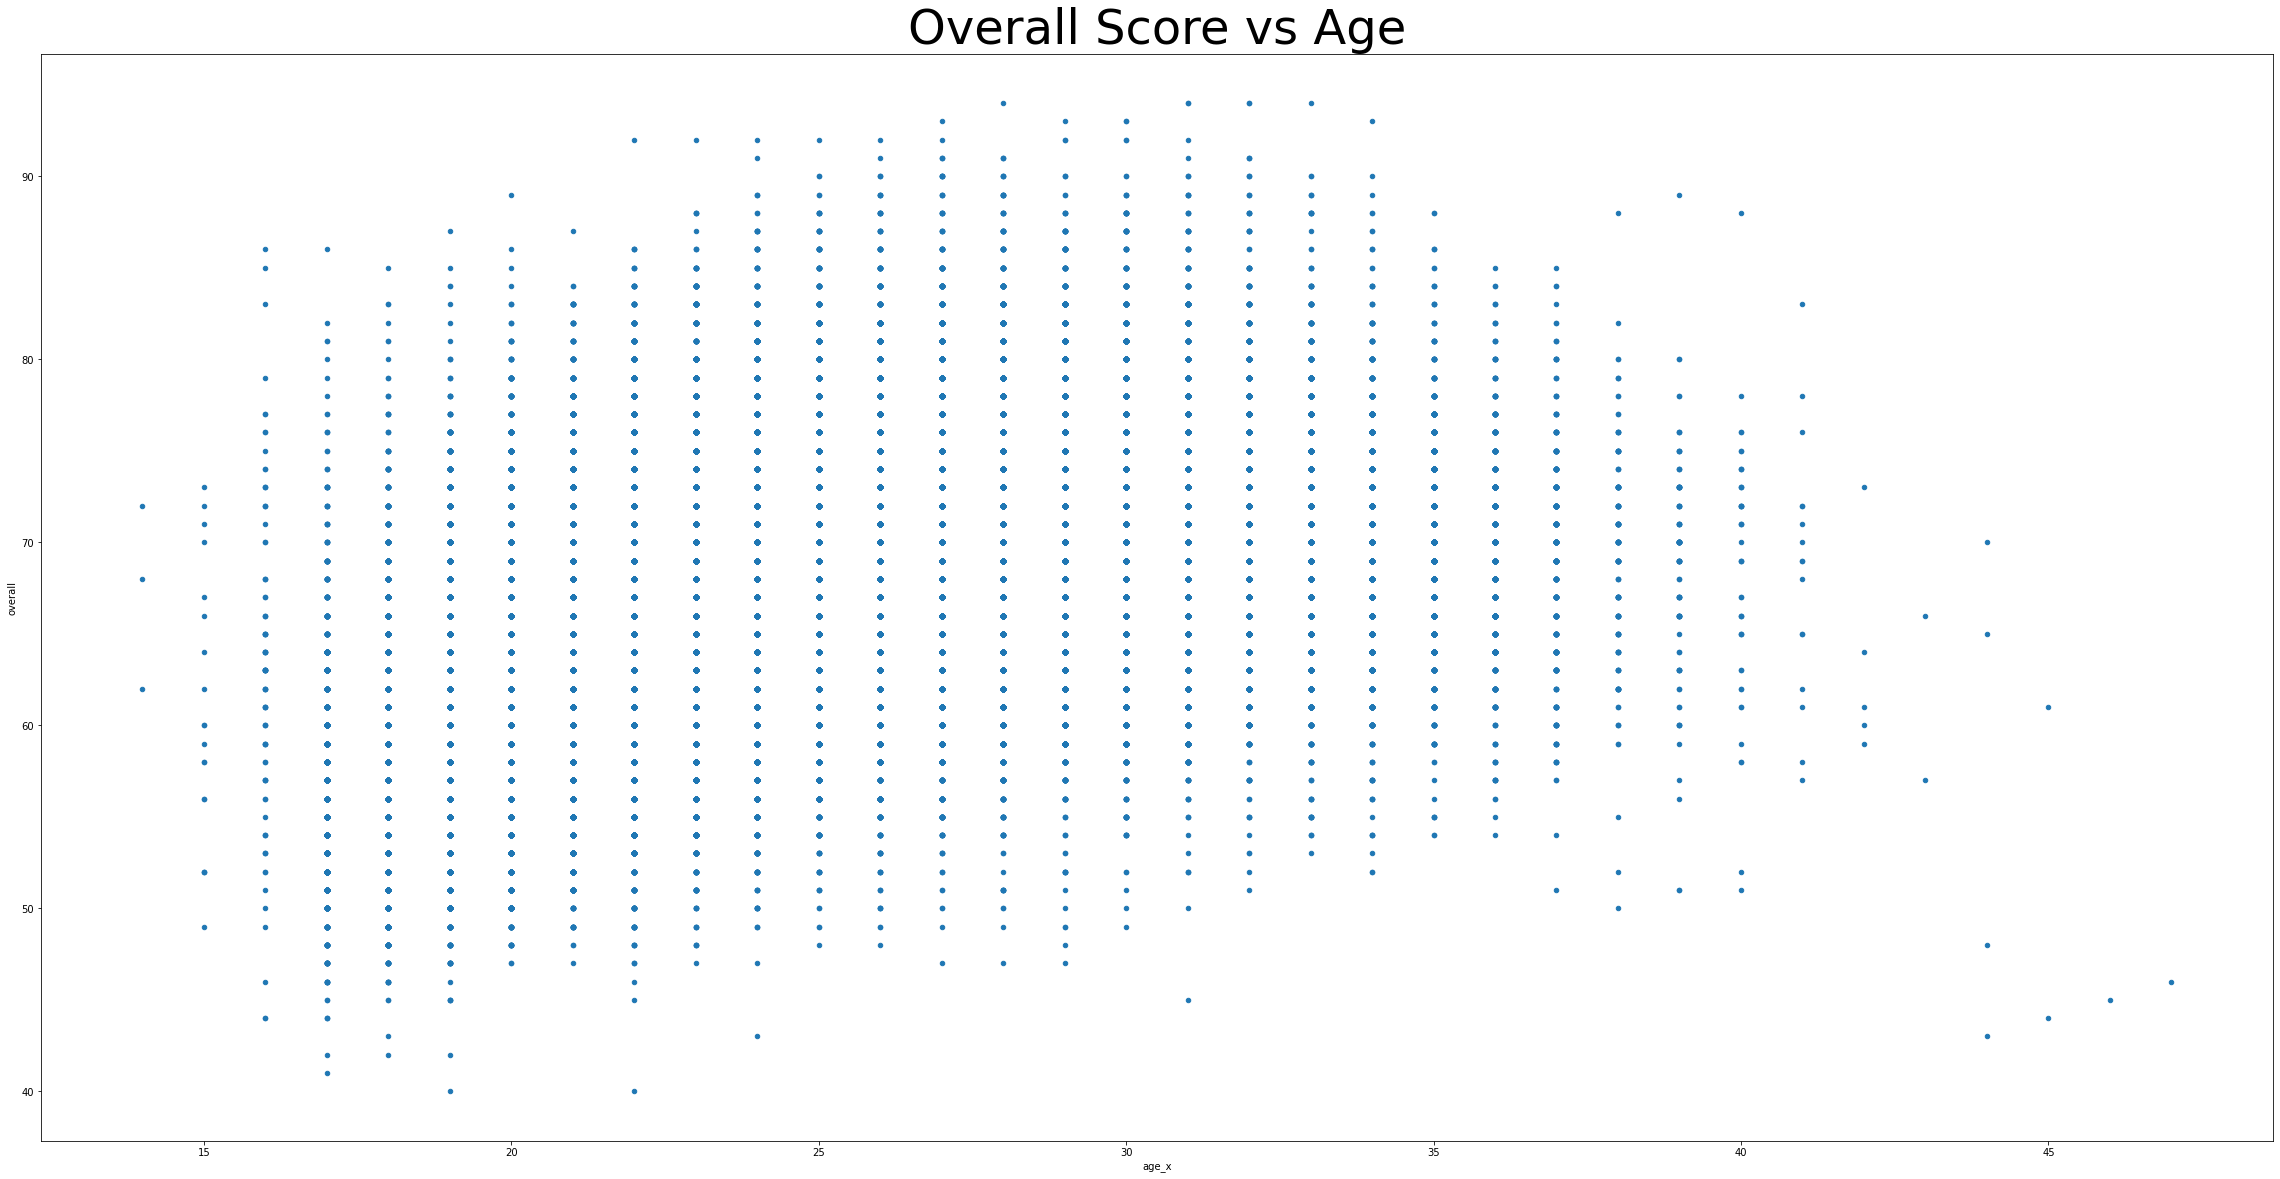

In [ ]:
ax15 = final_df[["age_x","overall"]].plot.scatter(x="age_x",y = "overall", figsize=(40,20))
ax15.set_title('Overall Score vs Age',fontdict={'fontsize':48})

We don't see any clear trend between age and overall rating. Let's see if we see a trend between the two after controlling on goals, minutes played, assists, and matches played.  

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:4582: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stabl

Text(0, 0.5, 'Overall')

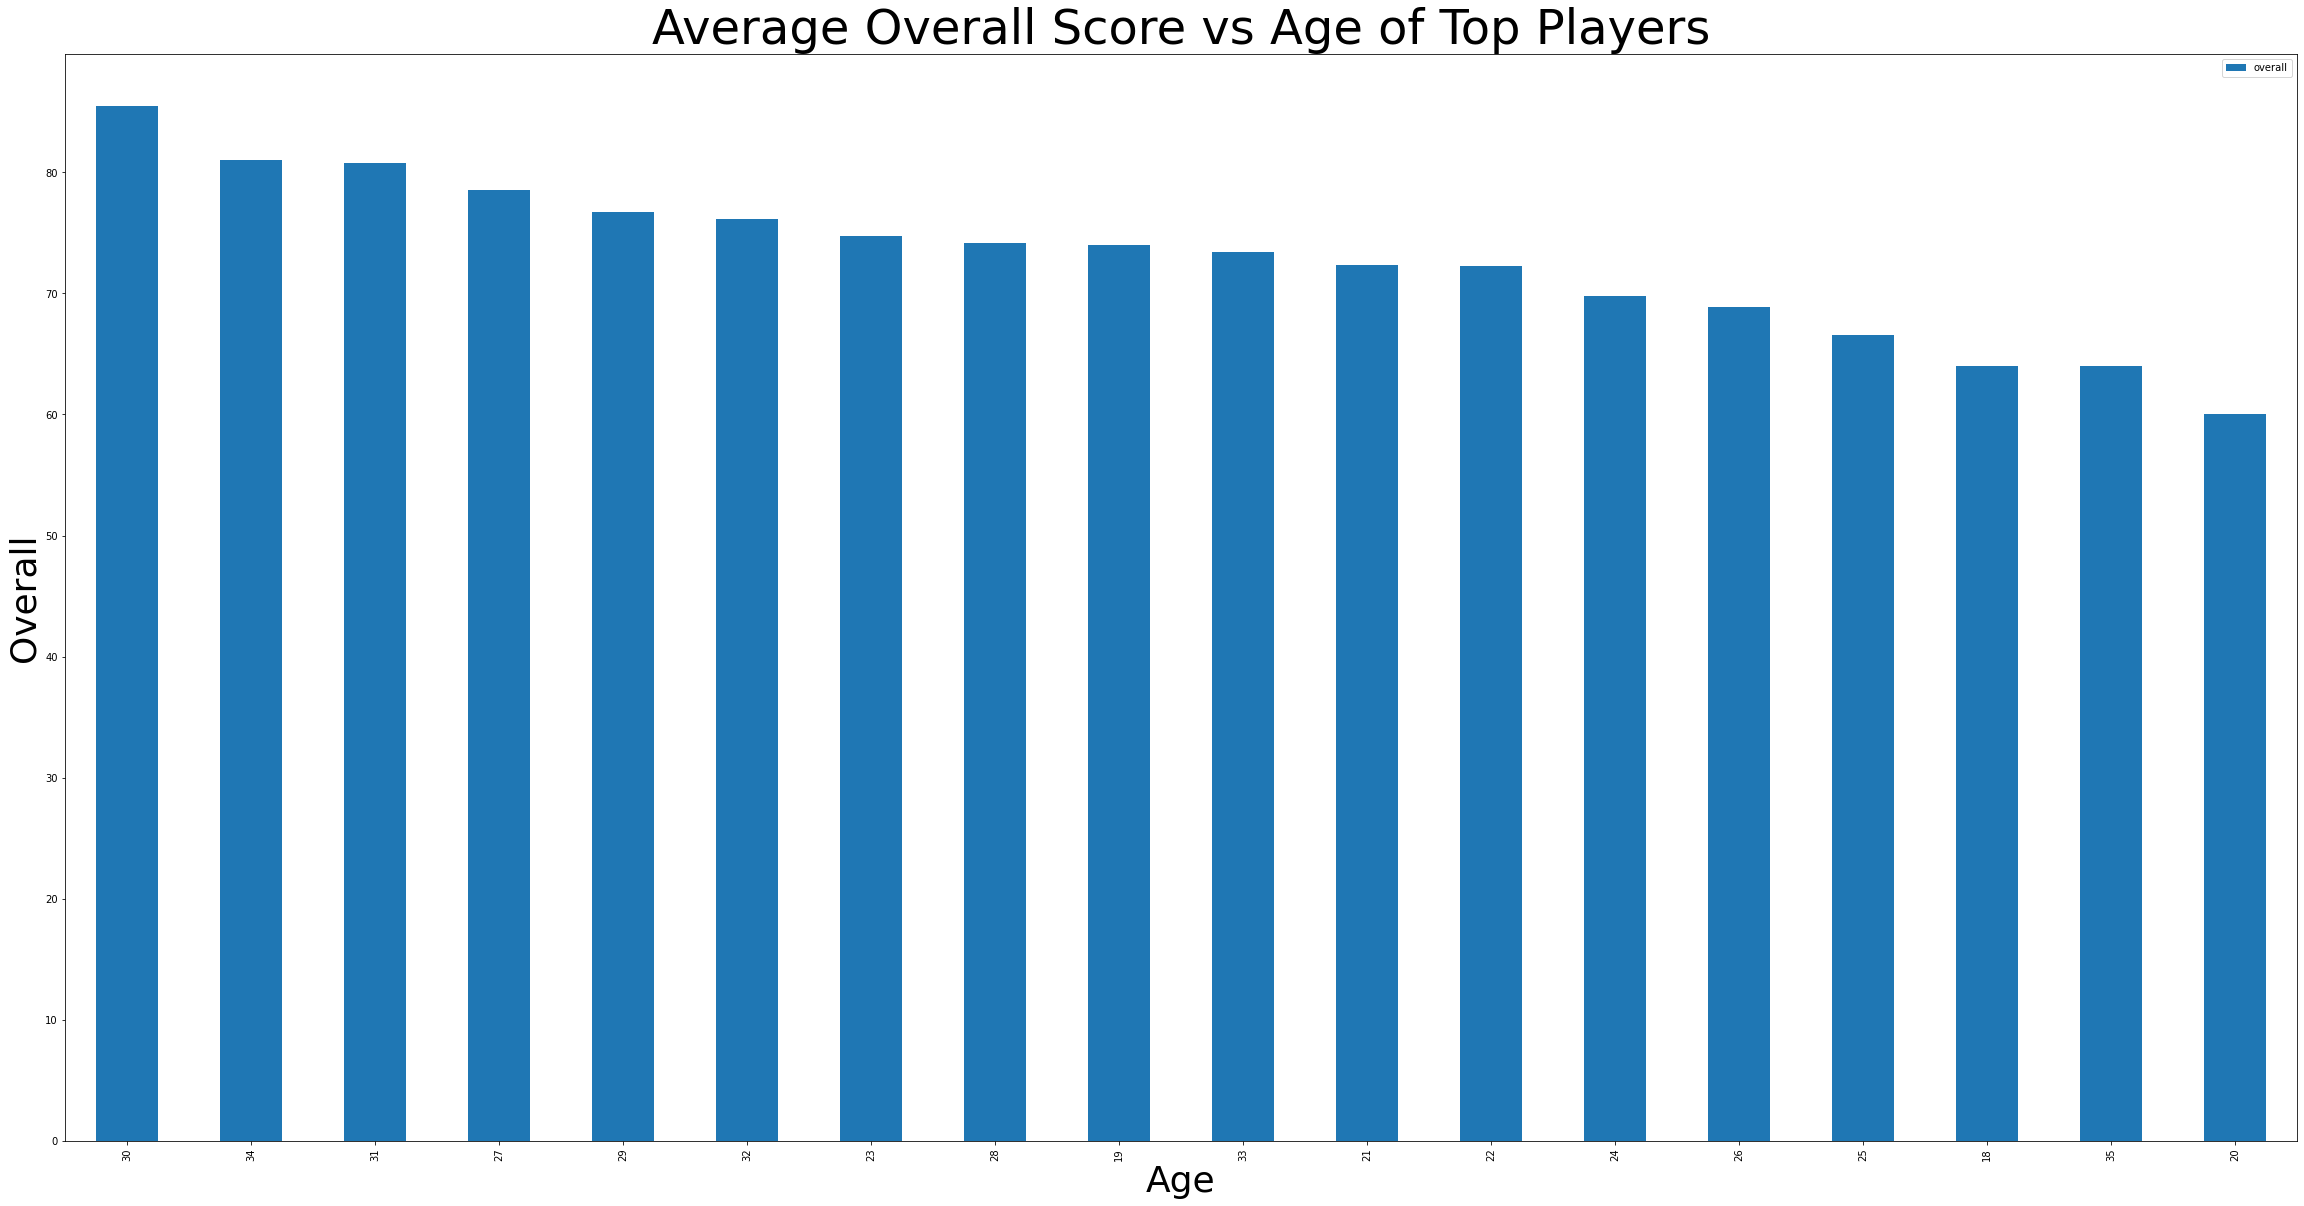

In [ ]:
# EDA 
# How does Fifa use Age in its ratings

age_rating_df = final_df[["age_x","overall","goals","minutes","assists","complete_matches"]]
age_rating_df.loc[age_rating_df.goals == '', "goals"] = 0
age_rating_df.loc[age_rating_df.minutes == '', "minutes"] = 0
age_rating_df.loc[age_rating_df.assists == '', "assists"] = 0
age_rating_df.loc[age_rating_df.complete_matches == '', "complete_matches"] = 0
age_rating_df["goals"] = age_rating_df["goals"].astype(int)
age_rating_df["minutes"].replace(',','',regex=True,inplace=True)
age_rating_df["minutes"] = age_rating_df["minutes"].astype(int)
age_rating_df["assists"] = age_rating_df["assists"].astype(int)
age_rating_df["complete_matches"] = age_rating_df["complete_matches"].astype(int)

top_age_rating_df = age_rating_df
np.quantile(top_age_rating_df["goals"],.99) # 15.0 
np.quantile(top_age_rating_df["minutes"],.9) # 2691.0
np.quantile(top_age_rating_df["assists"],.9) # 3
np.quantile(top_age_rating_df["complete_matches"],.9) # 26.0

top_age_rating_df = top_age_rating_df[top_age_rating_df.goals > 15]
top_age_rating_df = top_age_rating_df[top_age_rating_df.minutes > 2691]
top_age_rating_df = top_age_rating_df[top_age_rating_df.assists > 3]
top_age_rating_df = top_age_rating_df[top_age_rating_df.complete_matches > 26]

top_age_rating_df = top_age_rating_df.groupby('age_x').mean()
top_age_rating_df.reset_index(inplace=True)
top_age_rating_df.sort_values(by = "overall", ascending = False,inplace=True)
ax16 = top_age_rating_df.plot.bar(x = "age_x", y = "overall",figsize = (40,20))
ax16.set_title('Average Overall Score vs Age of Top Players',fontdict={'fontsize':48})
ax16.set_xlabel("Age",fontdict={'fontsize':36})
ax16.set_ylabel("Overall",fontdict={'fontsize':36})

It looks like top players tend to fall within the ages of 27 and 34 as 7 of the top 8 ages fall within this range. This slightly positive trend looks like it could explain a little bit of what we see from the feature importance analysis. 

We were interested in seeing if FIFA weighted features with different importances across different years of the game. Now that we know that the Random Forest Model provides the best results, let's stratify the data by year and look at feature importance for each dataset.


In [ ]:
features_2016 = features2[features2.Category_2016 == 1]
features_2017 = features2[features2.Category_2017 == 1]
features_2018 = features2[features2.Category_2018 == 1]
features_2019 = features2[features2.Category_2019 == 1]
features_2020 = features2[features2.Category_2020 == 1]

label_2016 = features_2016[["overall"]]
label_2017 = features_2017[["overall"]]
label_2018 = features_2018[["overall"]]
label_2019 = features_2019[["overall"]]
label_2020 = features_2020[["overall"]]

features_2016 = features_2016.drop(columns = "overall")
features_2017 = features_2017.drop(columns = "overall")
features_2018 = features_2018.drop(columns = "overall")
features_2019 = features_2019.drop(columns = "overall")
features_2020 = features_2020.drop(columns = "overall")

In [ ]:
x_train_2016, x_test_2016, y_train_2016, y_test_2016 = train_test_split(features_2016, label_2016, test_size=.2, train_size=.8)
pca_x_train_2016 = pca.fit_transform(x_train_2016)
pca_x_test_2016 = pca.transform(x_test_2016)

regr_2016 = RandomForestRegressor(n_estimators = 140, max_depth=200)
z = regr_2016.fit(pca_x_train_2016,y_train_2016)

y_pred_2016 = z.predict(pca_x_test_2016)

mse_test_rand_2016 = mean_squared_error(y_test_2016, y_pred_2016)
#mse_test_rand_2016

regr_2016.score(pca_x_test_2016,y_test_2016)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



0.9211922812205594

In [ ]:
x_train_2017, x_test_2017, y_train_2017, y_test_2017 = train_test_split(features_2017, label_2017, test_size=.2, train_size=.8)
pca_x_train_2017 = pca.fit_transform(x_train_2017)
pca_x_test_2017 = pca.transform(x_test_2017)

regr_2017 = RandomForestRegressor(n_estimators = 140, max_depth=200)
z = regr_2017.fit(pca_x_train_2017,y_train_2017)

y_pred_2017 = z.predict(pca_x_test_2017)

mse_test_rand_2017 = mean_squared_error(y_test_2017, y_pred_2017)
#mse_test_rand_2017

regr_2017.score(pca_x_test_2017,y_test_2017)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



0.9269736242582203

In [ ]:
x_train_2018, x_test_2018, y_train_2018, y_test_2018 = train_test_split(features_2018, label_2018, test_size=.2, train_size=.8)
pca_x_train_2018 = pca.fit_transform(x_train_2018)
pca_x_test_2018 = pca.transform(x_test_2018)

regr_2018 = RandomForestRegressor(n_estimators = 140, max_depth=200)
z = regr_2018.fit(pca_x_train_2018,y_train_2018)

y_pred_2018 = z.predict(pca_x_test_2018)

mse_test_rand_2018 = mean_squared_error(y_test_2018, y_pred_2018)
#mse_test_rand_2018

regr_2018.score(pca_x_test_2018,y_test_2018)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



0.9283896029109772

In [ ]:
x_train_2019, x_test_2019, y_train_2019, y_test_2019 = train_test_split(features_2019, label_2019, test_size=.2, train_size=.8)
pca_x_train_2019 = pca.fit_transform(x_train_2019)
pca_x_test_2019 = pca.transform(x_test_2019)

regr_2019 = RandomForestRegressor(n_estimators = 140, max_depth=200)
z = regr_2019.fit(pca_x_train_2019,y_train_2019)

y_pred_2019 = z.predict(pca_x_test_2019)

mse_test_rand_2019 = mean_squared_error(y_test_2019, y_pred_2019)
#mse_test_rand_2019

regr_2019.score(pca_x_test_2019,y_test_2019)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



0.9341533027744633

In [ ]:
x_train_2020, x_test_2020, y_train_2020, y_test_2020 = train_test_split(features_2020, label_2020, test_size=.2, train_size=.8)
pca_x_train_2020 = pca.fit_transform(x_train_2020)
pca_x_test_2020 = pca.transform(x_test_2020)

regr_2020 = RandomForestRegressor(n_estimators = 140, max_depth=200)
z = regr_2020.fit(pca_x_train_2020,y_train_2020)

y_pred_2020 = z.predict(pca_x_test_2020)

mse_test_rand_2020 = mean_squared_error(y_test_2020, y_pred_2020)
#mse_test_rand_2020

regr_2020.score(pca_x_test_2020,y_test_2020)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



0.9378300861018236

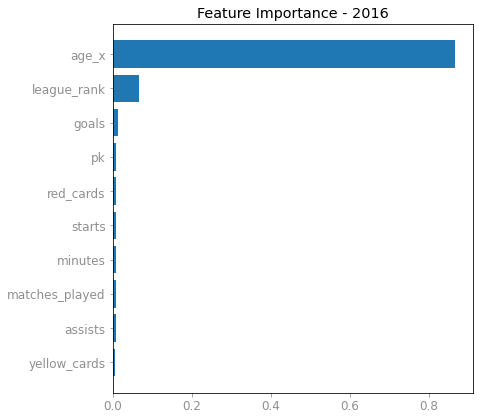

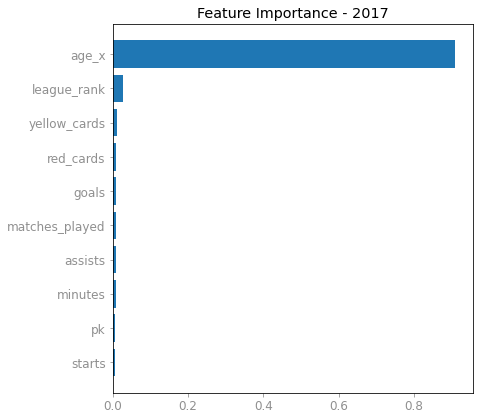

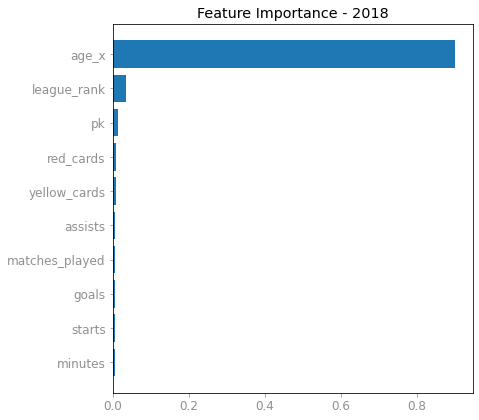

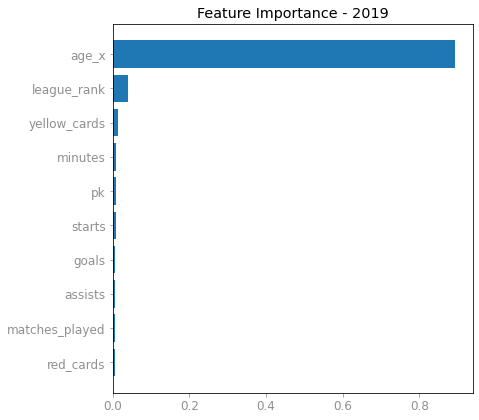

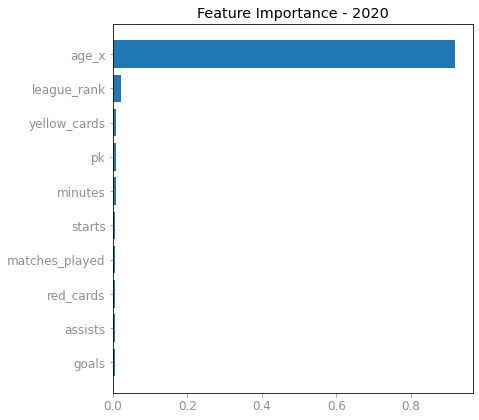

In [ ]:
feature_importance_2016 = regr_2016.feature_importances_
sorted_idx = np.argsort(feature_importance_2016)
pos = np.arange(sorted_idx.shape[0]) + .5
fig = plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.barh(pos, feature_importance_2016[sorted_idx], align='center')
plt.yticks(pos, np.array(features_2016.columns)[sorted_idx])
plt.title('Feature Importance - 2016')

fig.tight_layout()


feature_importance_2017 = regr_2017.feature_importances_
sorted_idx = np.argsort(feature_importance_2017)
pos = np.arange(sorted_idx.shape[0]) + .5
fig = plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.barh(pos, feature_importance_2017[sorted_idx], align='center')
plt.yticks(pos, np.array(features_2017.columns)[sorted_idx])
plt.title('Feature Importance - 2017')

fig.tight_layout()

feature_importance_2018 = regr_2018.feature_importances_
sorted_idx = np.argsort(feature_importance_2018)
pos = np.arange(sorted_idx.shape[0]) + .5
fig = plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.barh(pos, feature_importance_2018[sorted_idx], align='center')
plt.yticks(pos, np.array(features_2018.columns)[sorted_idx])
plt.title('Feature Importance - 2018')

fig.tight_layout()


feature_importance_2019 = regr_2019.feature_importances_
sorted_idx = np.argsort(feature_importance_2019)
pos = np.arange(sorted_idx.shape[0]) + .5
fig = plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.barh(pos, feature_importance_2019[sorted_idx], align='center')
plt.yticks(pos, np.array(features_2019.columns)[sorted_idx])
plt.title('Feature Importance - 2019')

fig.tight_layout()

feature_importance_2020 = regr_2020.feature_importances_
sorted_idx = np.argsort(feature_importance_2020)
pos = np.arange(sorted_idx.shape[0]) + .5
fig = plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.barh(pos, feature_importance_2020[sorted_idx], align='center')
plt.yticks(pos, np.array(features_2020.columns)[sorted_idx])
plt.title('Feature Importance - 2020')

fig.tight_layout()


plt.show()

Across different seasons, we see very similar results from the Feature Importance plots showing that FIFA stays pretty consistent from year to year in what they value in their overall ratings. However, we did notice that the relative importance of the league rank predictor variable varies across seasons. It looks like FIFA weighted the ranking of a player's team more heavily in 2016 than it did in future years. 


# Challenges and Future Steps

Throughout the course of this project, we faced many challenges. 

1) Our first issue concerned gathering data on soccer players - there were no pre-built datasets with all of the statistics of players spanning the last few years. Therefore, we had to scrape the data from Football Reference. To do this, we used Beatiful Soup which took considerably longer than just downloading the data from a file.

2) Our next major obstacle consisted of figuring out a way to combine our Kaggle dataframe with our Football Reference dataframe. We decided to use a Jaccard Join, but we had problems obtaining accurate matches between names because the two dataframes usually varied in how they formatted the same name. After extensive trial and error, we found that creating a short_name column in the Football Reference dataframe to match the short names in the Kaggle dataframe provided the best join results.

3) The next issue we faced was that all of the numeric data in our dataframes was cast as strings and many of our rows contained missing data. In order to continue to the modeling portion of our project, we had to convert all of the strings to numeric types and drop any rows with missing data. 

4) To handle the categorical variables in our model, we had to create dummy variables. However, we were worried that we would be overfitting our model because the addition of dummy variables greatly increased the parameters in our model. To address this, we used Principal Component Analysis to reduce the dimensionality of our model. 

5) Our fifth major problem which leads into one of the future steps we could take with this project is that we believe that some of our predictors have collinearity which could be skewing the feature importances. If we had more time and resources, we would investigate potential interaction terms amongst predictors to see if we can improve the model even more. One example of this is we would be curious to see the interaction between the age variable and minutes played (or matches played) because younger players are potentially able to handle more playing time. We believe the lack of interaction terms in our current model is why our results indicate that age is a disproportionately more important feature when predicting FIFA overall ratings. 


We would also be interested in looking at relationships after stratifying our data based on player positions. We touched on this briefly in our EDA section, but we would expect variations in all game statistics (goals, assists, penalty kicks, etc.) across different player positions as well as non-game statistics such as player wages and player body types. 

We would also be interested in applying more advanced machine learning models as we dive deeper into data science. We believe that we could toggle the parameters of our current models more effectively as we learn more about the backend of these algorithms.

Overall, we really enjoyed this project and were able to see a variety of interesting trends within the player data. Additionally, we were able to create a model which predicted FIFA overall ratings with more than 92% accuracy. We hope you enjoyed this project. 


Made by Aditya, Arjun, and Praneeth 😊